In [1]:
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import cv2
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

### Custom Windowing Technique Implementations

In [2]:
# Window functions
def hann_window(N):
    """Custom Hann window implementation"""
    n = np.arange(N)
    return 0.5 * (1 - np.cos(2 * np.pi * n / (N - 1)))

def hamming_window(N):
    """Custom Hamming window implementation"""
    n = np.arange(N)
    return 0.54 - 0.46 * np.cos(2 * np.pi * n / (N - 1))

def rectangular_window(N):
    """Rectangular window"""
    return np.ones(N)

### Data Loading and Visualization

In [3]:
def load_audio(file_path, sr=22050, duration=3.0):
    """Load and preprocess audio file"""
    try:
        y, sr = librosa.load(file_path, sr=sr, duration=duration)
        if len(y) < sr * duration:
            y = np.pad(y, (0, int(sr * duration - len(y))))
        else:
            y = y[:int(sr * duration)]
        return y, sr
    except Exception as e:
        print(f"Error loading {file_path}: {str(e)}")
        return None, None

In [4]:
def plot_waveforms_by_class(metadata_path, audio_base_path, fold=1):
    """Plot waveforms for each class in the dataset"""
    metadata = pd.read_csv(metadata_path)
    class_names = metadata['class'].unique()
    
    plt.figure(figsize=(15, 4*len(class_names)))
    
    for idx, class_name in enumerate(class_names):
        # Get first example of each class from specified fold
        sample = metadata[(metadata['class'] == class_name) & 
                         (metadata['fold'] == fold)].iloc[0]
        
        file_path = os.path.join(audio_base_path, f'fold{fold}', sample['slice_file_name'])
        y, sr = load_audio(file_path)
        
        plt.subplot(len(class_names), 1, idx+1)
        librosa.display.waveshow(y, sr=sr)
        plt.title(f'Class: {class_name}')
        plt.xlabel('Time (s)')
        plt.ylabel('Amplitude')
    
    plt.tight_layout()
    plt.show()

In [6]:
def generate_spectrogram(y, sr, window_type='hann', n_fft=2048, hop_length=512):
    """Generate spectrogram using specified window type"""
    # Select window
    if window_type == 'hann':
        window = hann_window(n_fft)
    elif window_type == 'hamming':
        window = hamming_window(n_fft)
    elif window_type == 'rectangular':
        window = rectangular_window(n_fft)
    else:
        raise ValueError(f"Unknown window type: {window_type}")
    
    # Compute STFT
    D = librosa.stft(y, n_fft=n_fft, hop_length=hop_length, window=window)
    # Convert to log-scale spectrogram
    S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
    return S_db

In [5]:
def plot_spectrograms_by_class(metadata_path, audio_base_path, fold=1):
    """
    Plot spectrograms for each class using different window types
    """
    metadata = pd.read_csv(metadata_path)
    classes = sorted(metadata['class'].unique())
    window_types = ['hann', 'hamming', 'rectangular']
    
    for class_name in classes:
        # Get first example of this class from specified fold
        sample = metadata[(metadata['class'] == class_name) & 
                         (metadata['fold'] == fold)].iloc[0]
        
        print(f"\nProcessing class: {class_name}")
        file_path = os.path.join(audio_base_path, f'fold{fold}', 
                                sample['slice_file_name'])
        
        audio, sr = load_audio(file_path)
        if audio is None:
            continue
            
        # Create subplot for this class
        plt.figure(figsize=(20, 5))
        plt.suptitle(f'Class: {class_name}', size=16)
        
        for i, window_type in enumerate(window_types):
            plt.subplot(1, 3, i+1)
            S_db = generate_spectrogram(audio, sr, window_type=window_type)
            img = librosa.display.specshow(S_db, x_axis='time', 
                                         y_axis='hz', sr=sr)
            plt.colorbar(img, format='%+2.0f dB')
            plt.title(f'{window_type} Window')
        
        plt.tight_layout()
        plt.show()

#### Preparing a dataset for Spectrogram Features

In [31]:
class SoundDataset(Dataset):
    """PyTorch Dataset for spectrograms"""
    def __init__(self, spectrograms, labels):
        self.specs = torch.FloatTensor(spectrograms)
        self.labels = torch.LongTensor(labels)
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return self.specs[idx], self.labels[idx]


def prepare_data_single_window(metadata_path, audio_base_path, window_type, train_folds, test_folds):
    """Prepare data for a single window type"""
    print(f"\nPreparing data for {window_type} window")
    metadata = pd.read_csv(metadata_path)
    
    X_train, y_train = [], []
    X_test, y_test = [], []
    
    # Process training folds
    print(f"Processing training folds: {train_folds}")
    for fold in train_folds:
        fold_data = metadata[metadata['fold'] == fold]
        for _, row in tqdm(fold_data.iterrows(), desc=f"Fold {fold}"):
            file_path = os.path.join(audio_base_path, f'fold{fold}', row['slice_file_name'])
            audio, sr = load_audio(file_path)
            if audio is not None:
                S_db = generate_spectrogram(audio, sr, window_type)
                # Resize and normalize
                S_db = cv2.resize(S_db, (128, 128))
                S_db = (S_db - S_db.min()) / (S_db.max() - S_db.min())
                X_train.append(S_db)
                y_train.append(row['classID'])
    
    # Process test folds
    print(f"\nProcessing test folds: {test_folds}")
    for fold in test_folds:
        fold_data = metadata[metadata['fold'] == fold]
        for _, row in tqdm(fold_data.iterrows(), desc=f"Fold {fold}"):
            file_path = os.path.join(audio_base_path, f'fold{fold}', row['slice_file_name'])
            audio, sr = load_audio(file_path)
            if audio is not None:
                S_db = generate_spectrogram(audio, sr, window_type)
                S_db = cv2.resize(S_db, (128, 128))
                S_db = (S_db - S_db.min()) / (S_db.max() - S_db.min())
                X_test.append(S_db)
                y_test.append(row['classID'])
    
    # Convert to numpy arrays
    X_train = np.array(X_train)
    X_test = np.array(X_test)
    y_train = np.array(y_train)
    y_test = np.array(y_test)
    
    print(f"\nFinal shapes:")
    print(f"X_train: {X_train.shape}")
    print(f"X_test: {X_test.shape}")
    
    return (X_train, y_train), (X_test, y_test)



#### K-fold Cross Validation Training Loop

In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, 
                num_epochs=20, device='cuda', early_stopping_patience=10):
    """Train the CNN model with early stopping"""
    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': []
    }
    
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0
        
        for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Lighter L2 regularization
            l2_lambda = 0.0001
            l2_reg = torch.tensor(0.).to(device)
            for param in model.parameters():
                l2_reg += torch.norm(param)
            loss += l2_lambda * l2_reg
            
            loss.backward()
            
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += predicted.eq(labels).sum().item()
        
        # Validation phase
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()
        
        # Update learning rate
        scheduler.step(val_loss/len(val_loader))
        
        # Record history
        train_loss = train_loss/len(train_loader)
        train_acc = 100.*train_correct/train_total
        val_loss = val_loss/len(val_loader)
        val_acc = 100.*val_correct/val_total
        
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        print(f'\nEpoch {epoch+1}/{num_epochs}:')
        print(f'Train Loss: {train_loss:.3f}, Train Acc: {train_acc:.2f}%')
        print(f'Val Loss: {val_loss:.3f}, Val Acc: {val_acc:.2f}%')
        
        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            best_model_state = model.state_dict()
        else:
            patience_counter += 1
            if patience_counter >= early_stopping_patience:
                print(f'\nEarly stopping triggered after epoch {epoch+1}')
                model.load_state_dict(best_model_state)
                break
    
    return model, history

def k_fold_train_single_window(metadata_path, audio_base_path, window_type, n_folds=10):
    """Train model using k-fold cross validation"""
    print(f"\nStarting {n_folds}-fold cross validation for {window_type} window")
    
    metadata = pd.read_csv(metadata_path)
    all_histories = []
    fold_results = []
    
    for fold in range(1, n_folds + 1):
        print(f"\nTraining on fold {fold} as validation set")
        
        # Prepare data
        train_folds = [f for f in range(1, n_folds + 1) if f != fold]
        test_folds = [fold]
        
        (X_train, y_train), (X_test, y_test) = prepare_data_single_window(
            metadata_path,
            audio_base_path,
            window_type,
            train_folds,
            test_folds
        )
        
        # Reshape for CNN
        X_train = X_train.reshape(-1, 1, 128, 128)
        X_test = X_test.reshape(-1, 1, 128, 128)
        
        # Create datasets and dataloaders
        train_dataset = SoundDataset(X_train, y_train)
        test_dataset = SoundDataset(X_test, y_test)
        
        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=32)
        
        # Initialize model and training components
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        model = CNN(num_classes=10, in_channels=1).to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3)
        
        # Train
        model, history = train_model(model, train_loader, test_loader, 
                                   criterion, optimizer, scheduler)
        
        all_histories.append(history)
        fold_results.append({
            'fold': fold,
            'final_val_acc': history['val_acc'][-1],
            'final_val_loss': history['val_loss'][-1]
        })
    
    # Calculate average results
    avg_val_acc = np.mean([res['final_val_acc'] for res in fold_results])
    std_val_acc = np.std([res['final_val_acc'] for res in fold_results])
    
    print(f"\nCross-validation results for {window_type} window:")
    print(f"Average validation accuracy: {avg_val_acc:.2f}% ± {std_val_acc:.2f}%")
    
    return fold_results, all_histories

def train_single_window(window_type, train_folds=[1,2,3,4,5,6,7,8,9], test_folds=[10]):
    """Train model for a single window type"""
    print(f"\nStarting training for {window_type} window")
    
    # Prepare data
    (X_train, y_train), (X_test, y_test) = prepare_data_single_window(
        'metadata/UrbanSound8K.csv',
        'audio',
        window_type,
        train_folds,
        test_folds
    )
    
    # Reshape for CNN
    X_train = X_train.reshape(-1, 1, 128, 128)
    X_test = X_test.reshape(-1, 1, 128, 128)
    
    # Create datasets and dataloaders
    train_dataset = SoundDataset(X_train, y_train)
    test_dataset = SoundDataset(X_test, y_test)
    
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32)
    
    # Initialize model and training components
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = CNN(num_classes=10, in_channels=1).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)  # Changed from AdamW
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)
    
    # Train
    model, history = train_model(model, train_loader, test_loader, 
                               criterion, optimizer, scheduler)
    
    return model, history

#### Plotting training histories

In [ ]:
def plot_training_history(history, title='Training History'):
    """Plot training and validation metrics"""
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train Accuracy')
    plt.plot(history['val_acc'], label='Val Accuracy')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

def plot_k_fold_histories(all_histories, window_type, n_folds=10):
    """
    Plot training and validation metrics for each fold in k-fold cross-validation
    with accuracy and loss in separate side-by-side plots
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Calculate mean metrics across all folds
    max_epochs = max(len(h['train_acc']) for h in all_histories)
    epochs = range(max_epochs)
    
    # Initialize arrays for storing metrics
    all_train_accs = []
    all_val_accs = []
    all_train_losses = []
    all_val_losses = []
    
    # Store all histories first
    for history in all_histories:
        # Extend shorter sequences with their last value
        train_acc = list(history['train_acc'])
        val_acc = list(history['val_acc'])
        train_loss = list(history['train_loss'])
        val_loss = list(history['val_loss'])
        
        # Pad shorter sequences with their last value
        if len(train_acc) < max_epochs:
            train_acc.extend([train_acc[-1]] * (max_epochs - len(train_acc)))
            val_acc.extend([val_acc[-1]] * (max_epochs - len(val_acc)))
            train_loss.extend([train_loss[-1]] * (max_epochs - len(train_loss)))
            val_loss.extend([val_loss[-1]] * (max_epochs - len(val_loss)))
            
        all_train_accs.append(train_acc)
        all_val_accs.append(val_acc)
        all_train_losses.append(train_loss)
        all_val_losses.append(val_loss)
    
    # Calculate means
    mean_train_acc = np.mean(all_train_accs, axis=0)
    mean_val_acc = np.mean(all_val_accs, axis=0)
    mean_train_loss = np.mean(all_train_losses, axis=0)
    mean_val_loss = np.mean(all_val_losses, axis=0)
    
    # Plot mean accuracy
    axes[0, 0].plot(epochs, mean_train_acc, color='green', label='Train Accuracy')
    axes[0, 0].plot(epochs, mean_val_acc, color='red', label='Val Accuracy')
    axes[0, 0].set_title('Mean Accuracy')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].grid(True, linestyle='--', alpha=0.3)
    axes[0, 0].legend()
    axes[0, 0].set_ylim(0, 100)
    
    # Plot mean loss
    axes[0, 1].plot(epochs, mean_train_loss, color='blue', label='Train Loss')
    axes[0, 1].plot(epochs, mean_val_loss, color='orange', label='Val Loss')
    axes[0, 1].set_title('Mean Loss')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].grid(True, linestyle='--', alpha=0.3)
    axes[0, 1].legend()
    
    # Plot all folds accuracy
    for history in all_histories:
        hist_epochs = range(len(history['train_acc']))
        axes[1, 0].plot(hist_epochs, history['train_acc'], color='green', alpha=0.4)
        axes[1, 0].plot(hist_epochs, history['val_acc'], color='red', alpha=0.4)
    axes[1, 0].set_title('All Folds Accuracy')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Accuracy')
    axes[1, 0].grid(True, linestyle='--', alpha=0.3)
    axes[1, 0].legend(['Train Accuracy', 'Val Accuracy'])
    axes[1, 0].set_ylim(0, 100)
    
    # Plot all folds loss
    for history in all_histories:
        hist_epochs = range(len(history['train_loss']))
        axes[1, 1].plot(hist_epochs, history['train_loss'], color='blue', alpha=0.4)
        axes[1, 1].plot(hist_epochs, history['val_loss'], color='orange', alpha=0.4)
    axes[1, 1].set_title('All Folds Loss')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Loss')
    axes[1, 1].grid(True, linestyle='--', alpha=0.3)
    axes[1, 1].legend(['Train Loss', 'Val Loss'])
    
    plt.tight_layout()
    return fig


#### Convolutional Neural Network to train on spectrogram features

In [ ]:
class CNN(nn.Module):
    def __init__(self, num_classes=10, in_channels=1):
        super(CNN, self).__init__()
        self.features = nn.Sequential(
            # First conv block
            nn.Conv2d(in_channels, 32, 3, padding=1),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(32),
            nn.Dropout2d(0.2),  # Reduced dropout
            nn.MaxPool2d(2),
            
            # Second conv block
            nn.Conv2d(32, 64, 3, padding=1),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(64),
            nn.Dropout2d(0.2),
            nn.MaxPool2d(2),
            
            # Third conv block
            nn.Conv2d(64, 128, 3, padding=1),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(128),
            nn.Dropout2d(0.2),
            nn.MaxPool2d(2),
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 16 * 16, 512),
            nn.LeakyReLU(0.1),
            nn.BatchNorm1d(512),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )
        
        # Weight initialization
        self.apply(self._init_weights)
        
    def _init_weights(self, m):
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='leaky_relu')
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
                
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [43]:
import seaborn as sns

def compare_window_results(window_results):
    """Compare results across different window types"""
    comparison_df = pd.DataFrame()
    
    for window_type, results in window_results.items():
        fold_accuracies = [res['final_val_acc'] for res in results[0]]
        comparison_df[window_type] = fold_accuracies
    
    # Calculate statistics
    stats_df = pd.DataFrame({
        'Mean Accuracy': comparison_df.mean(),
        'Std Accuracy': comparison_df.std()
    })
    
    print("\nWindow Type Comparison:")
    print(stats_df)
    
    # Boxplot with stripplot
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=comparison_df, width=0.6, showfliers=False)
    sns.stripplot(data=comparison_df, size=8, jitter=True, alpha=0.6)
    plt.title('Accuracy Distribution by Window Type')
    plt.ylabel('Validation Accuracy (%)')
    plt.xticks(rotation=45)
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()
    
    return stats_df

In [9]:
# Set paths
metadata_path = 'UrbanSound8k/metadata/UrbanSound8K.csv'
audio_base_path = 'UrbanSound8k/audio'


Plotting waveforms for each class...


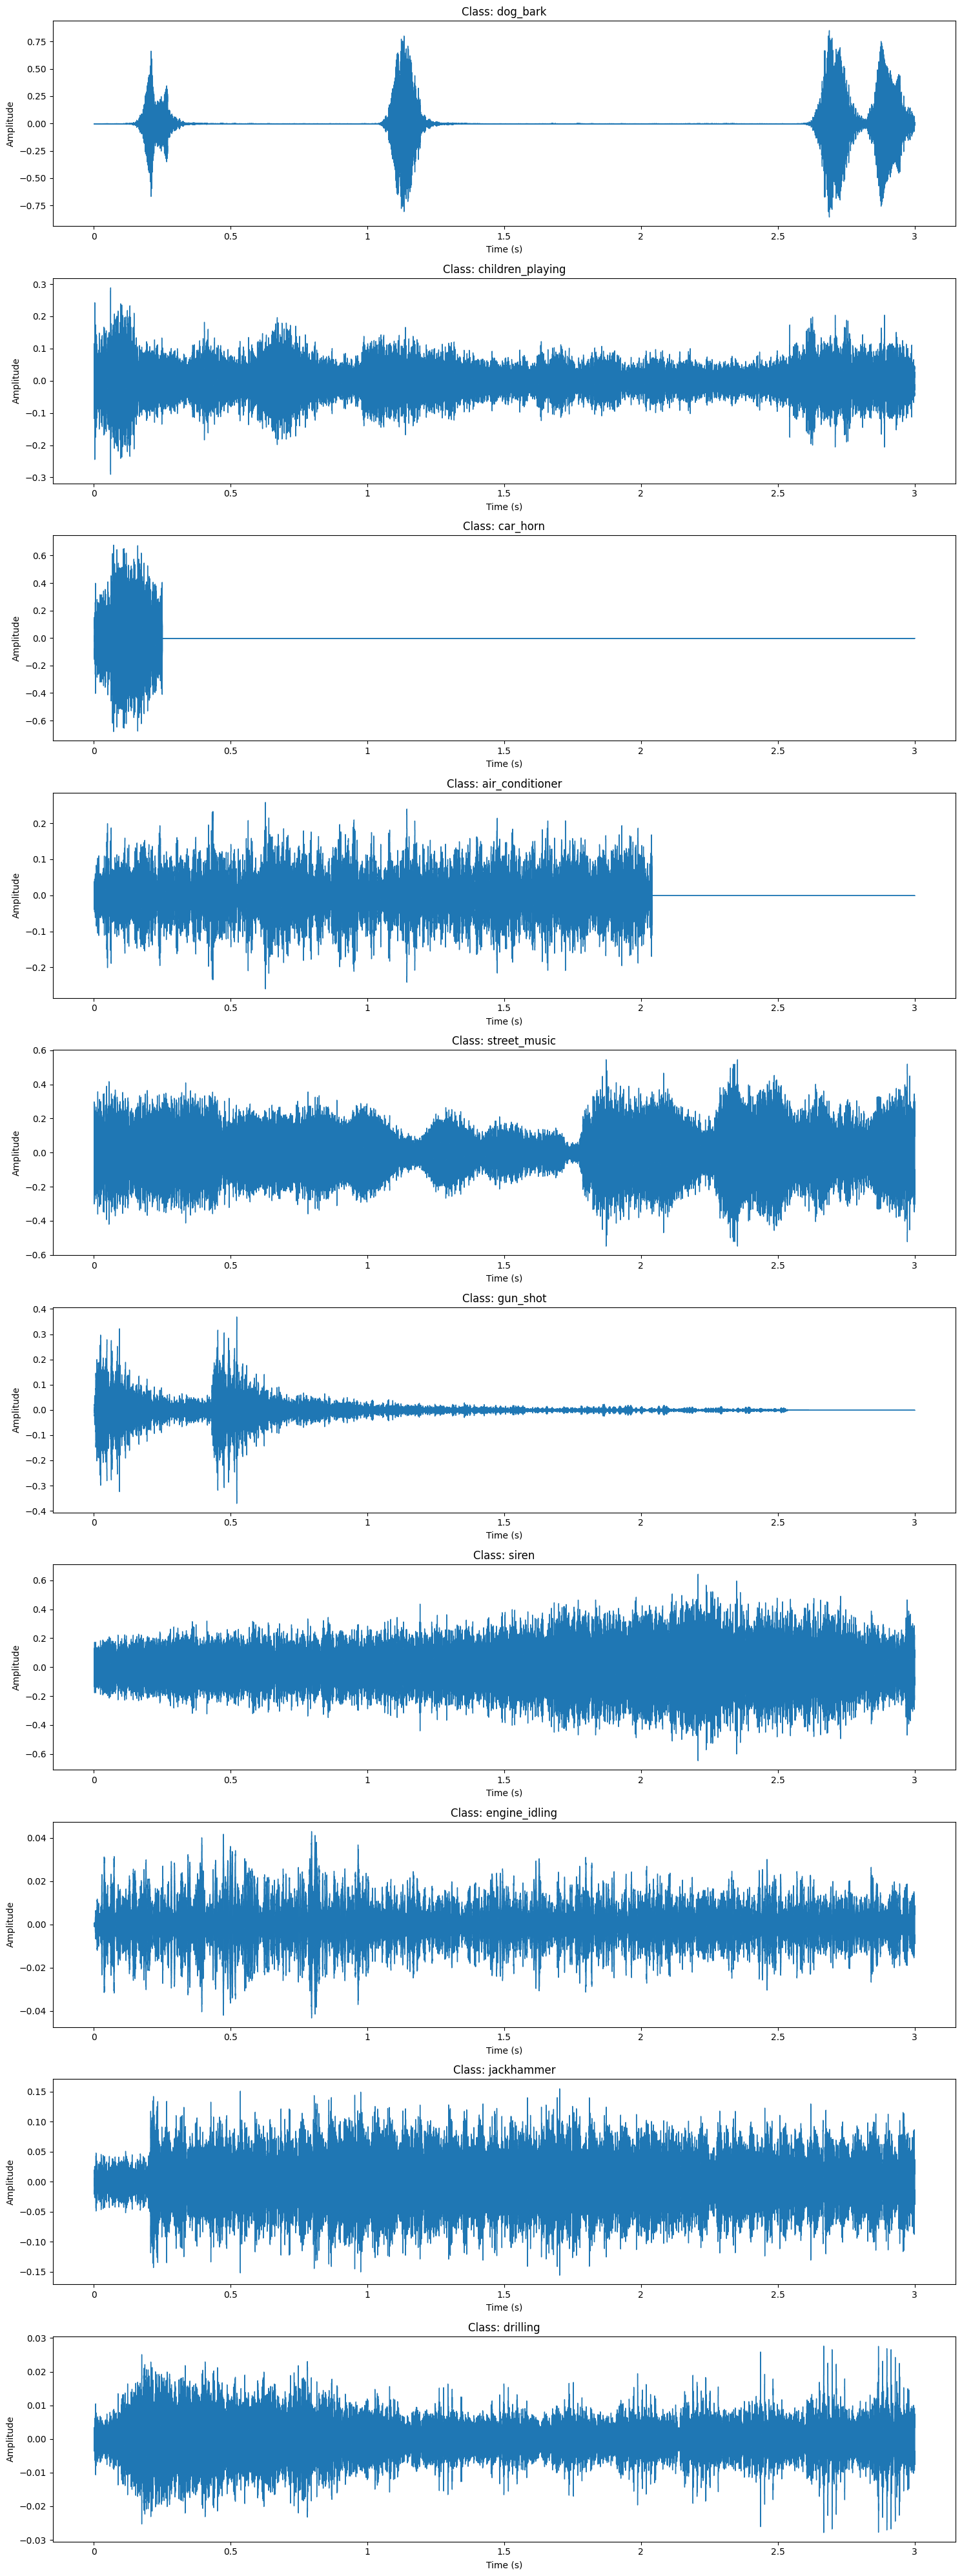

In [10]:
# 1. Visualize waveforms
print("Plotting waveforms for each class...")
plot_waveforms_by_class(metadata_path, audio_base_path)


Processing class: air_conditioner


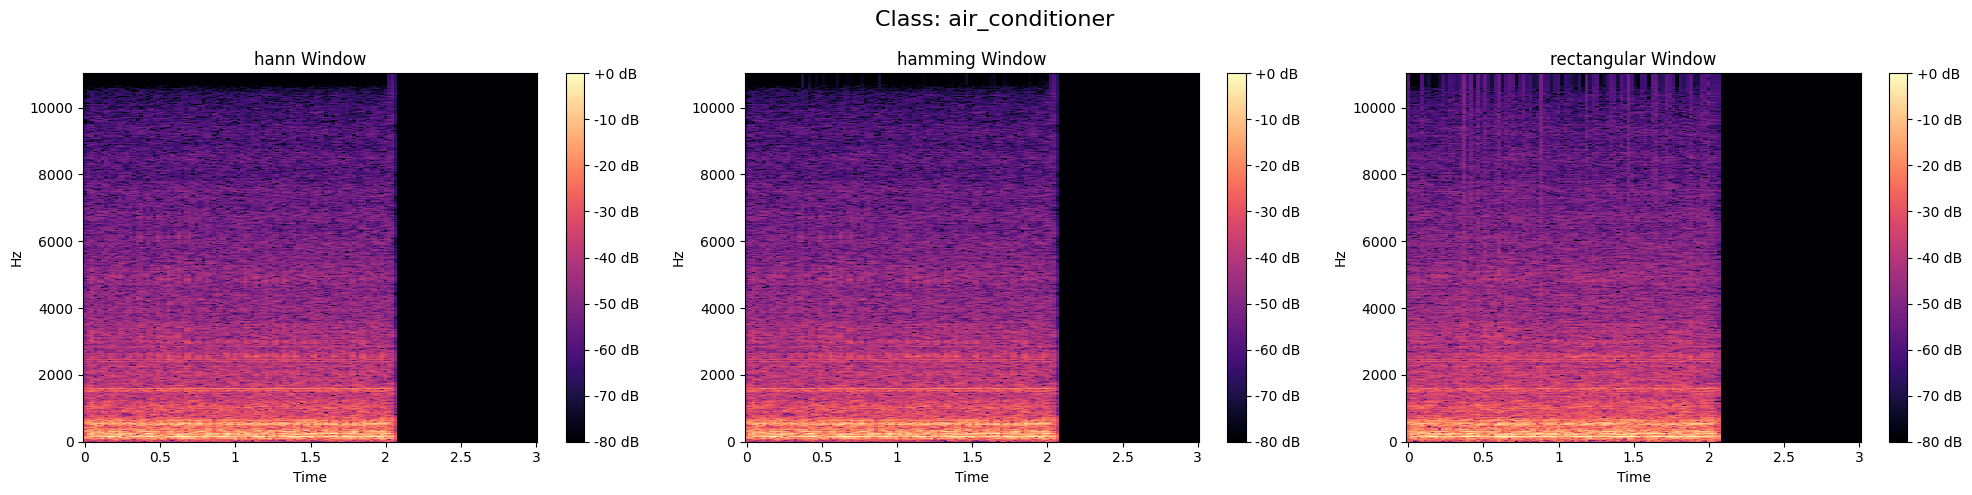


Processing class: car_horn


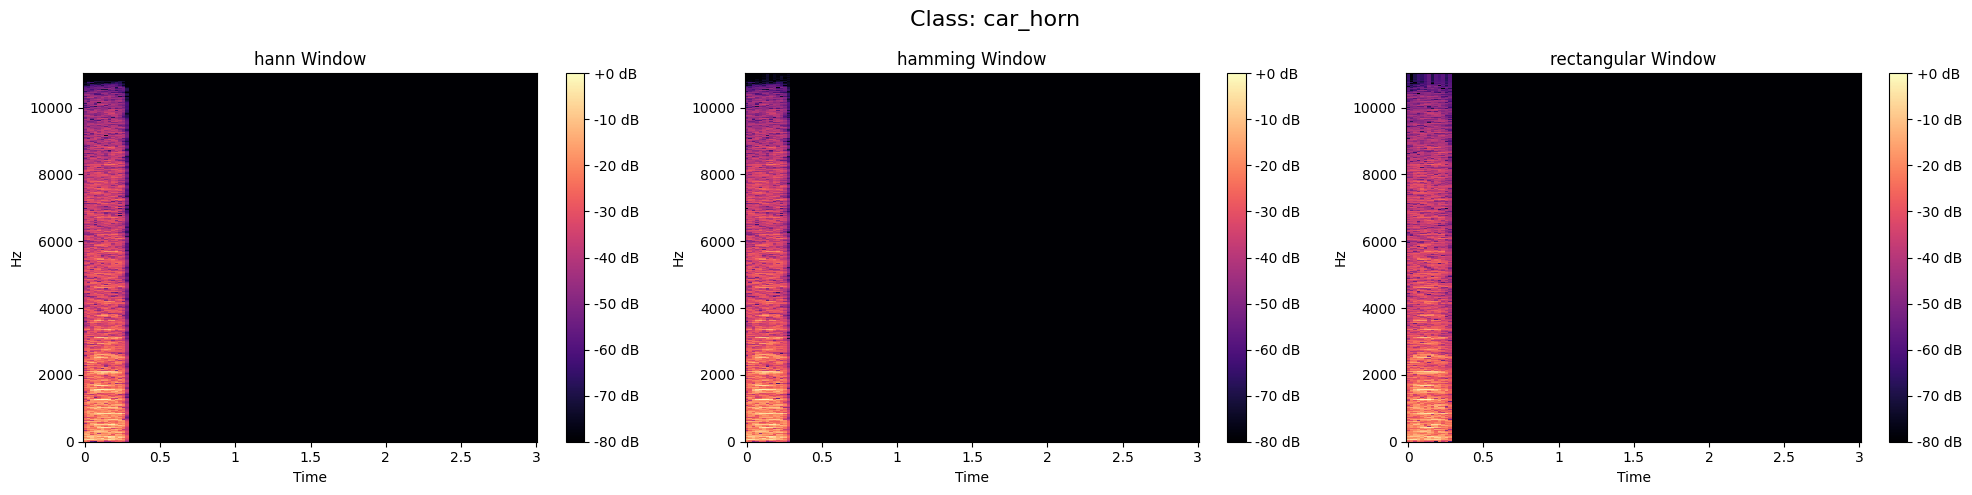


Processing class: children_playing


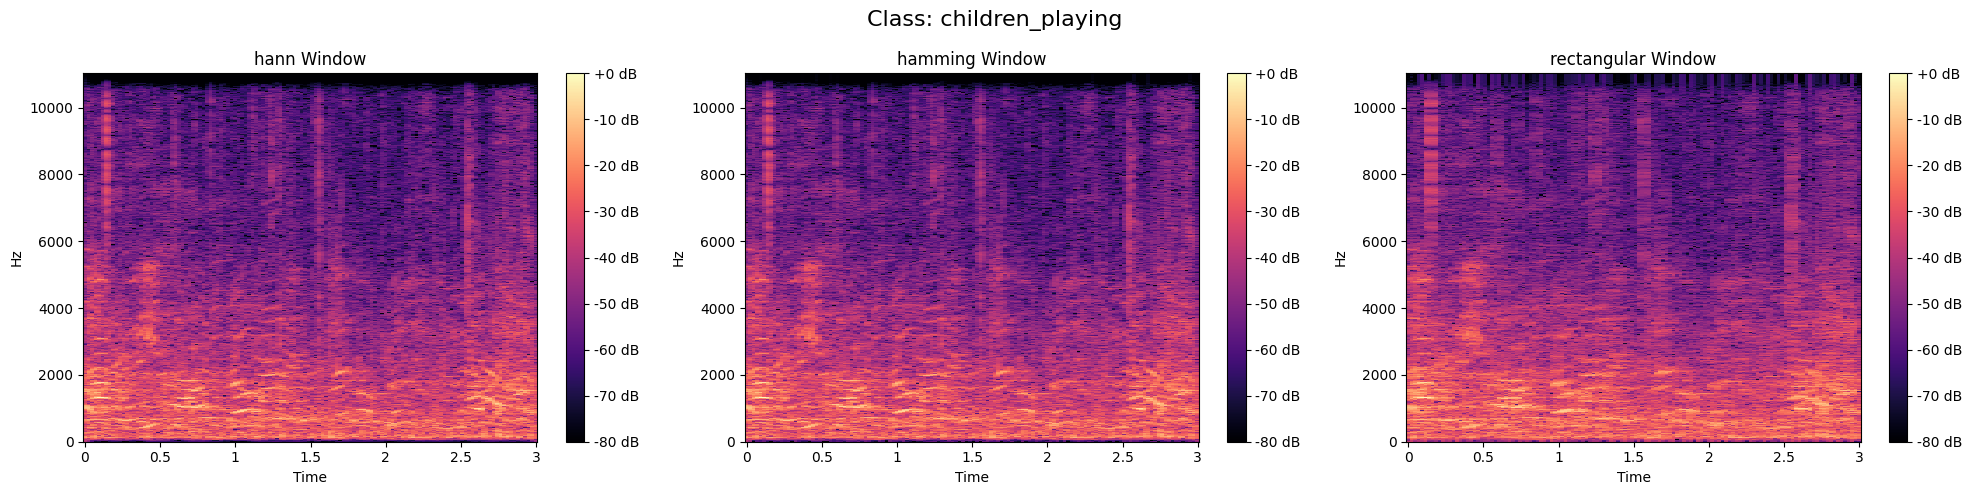


Processing class: dog_bark


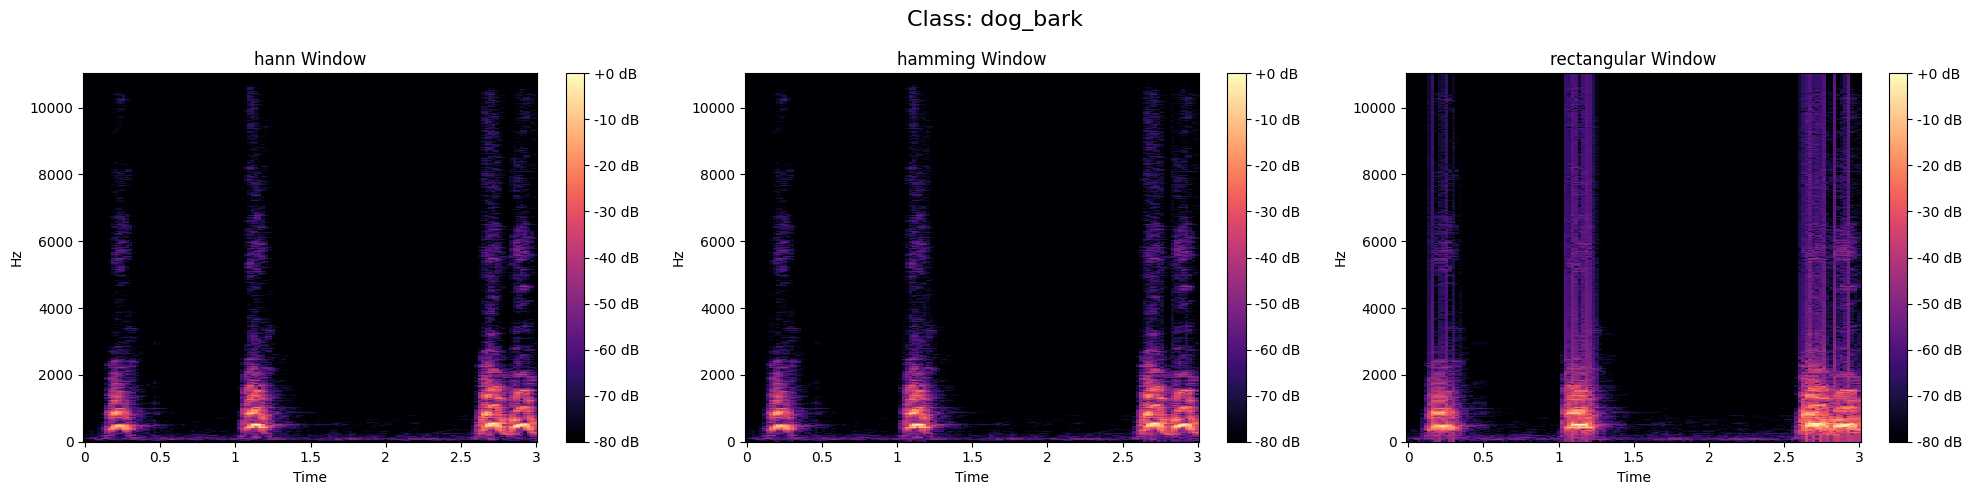


Processing class: drilling


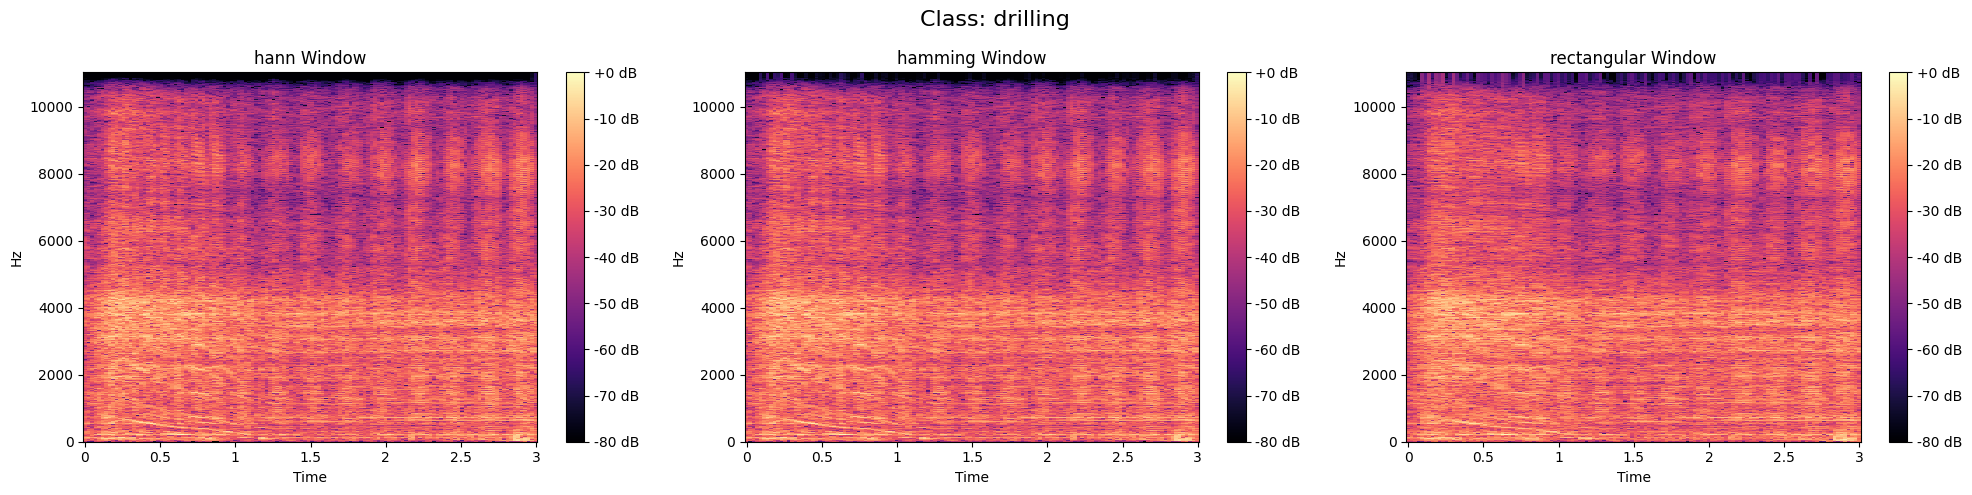


Processing class: engine_idling


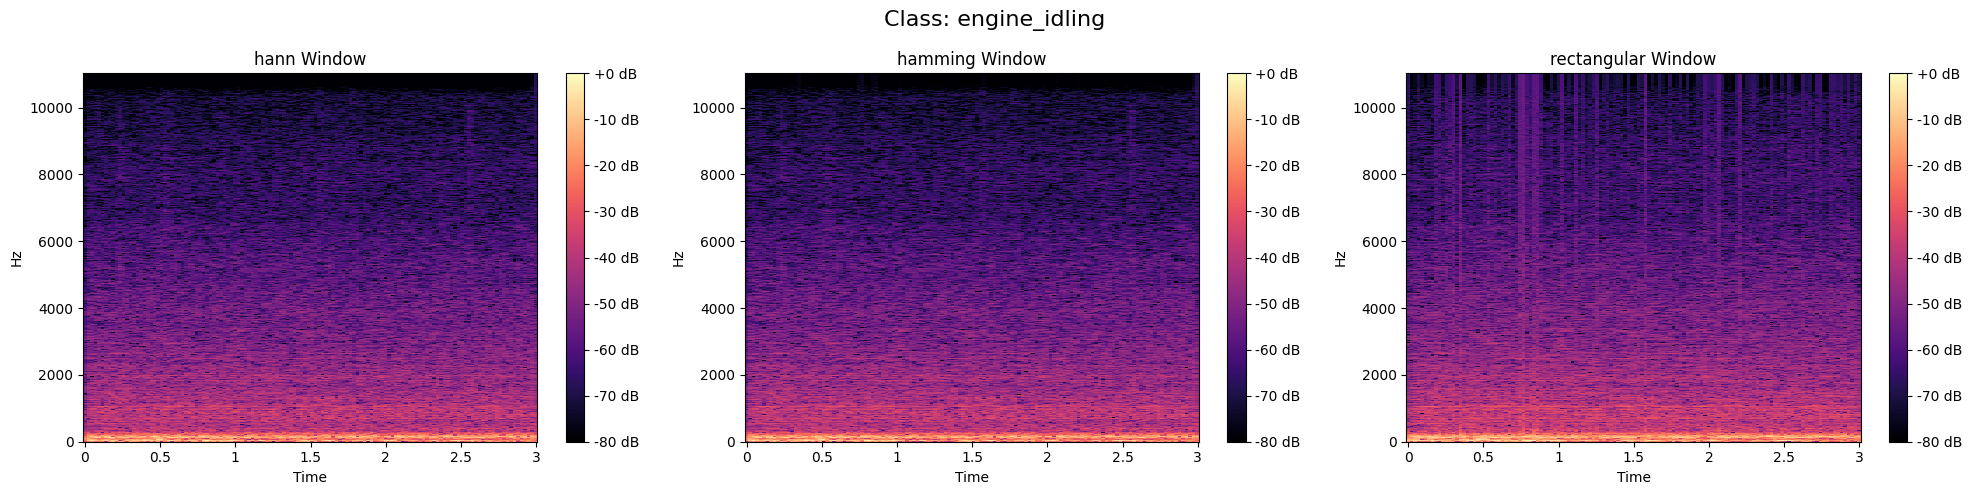


Processing class: gun_shot


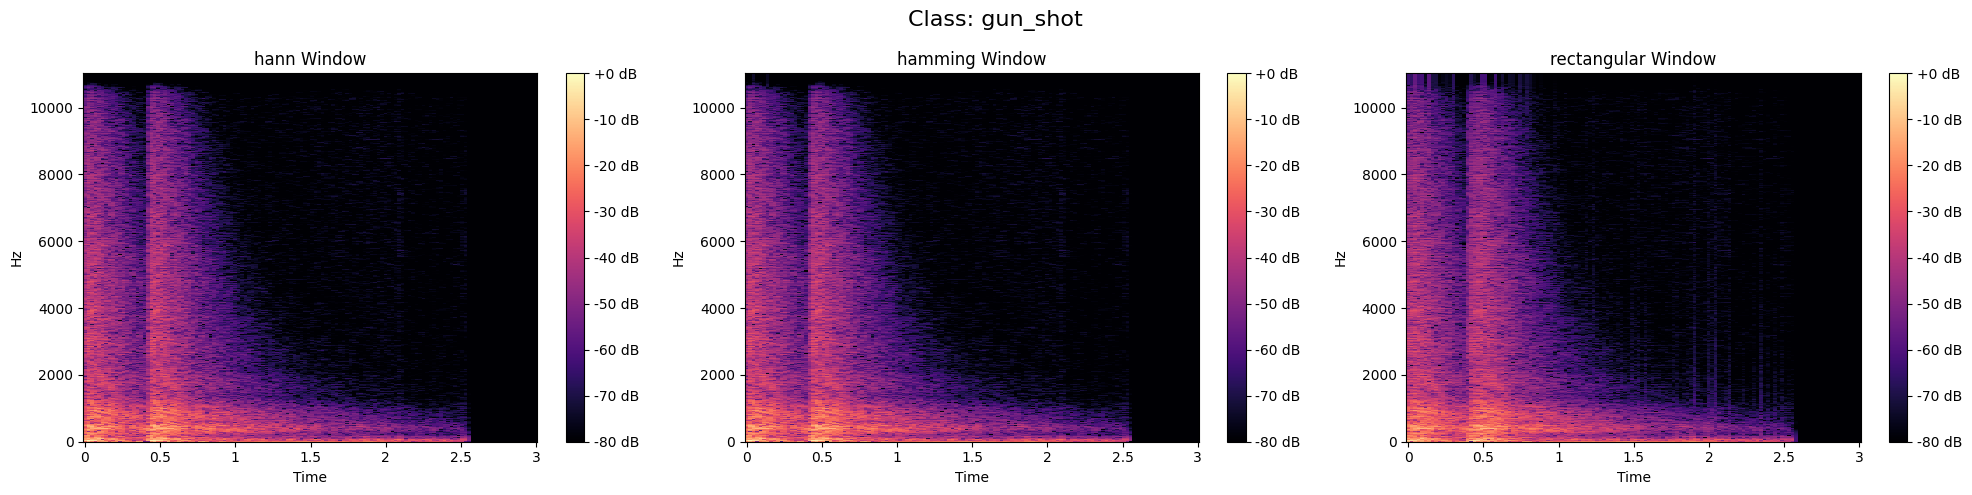


Processing class: jackhammer


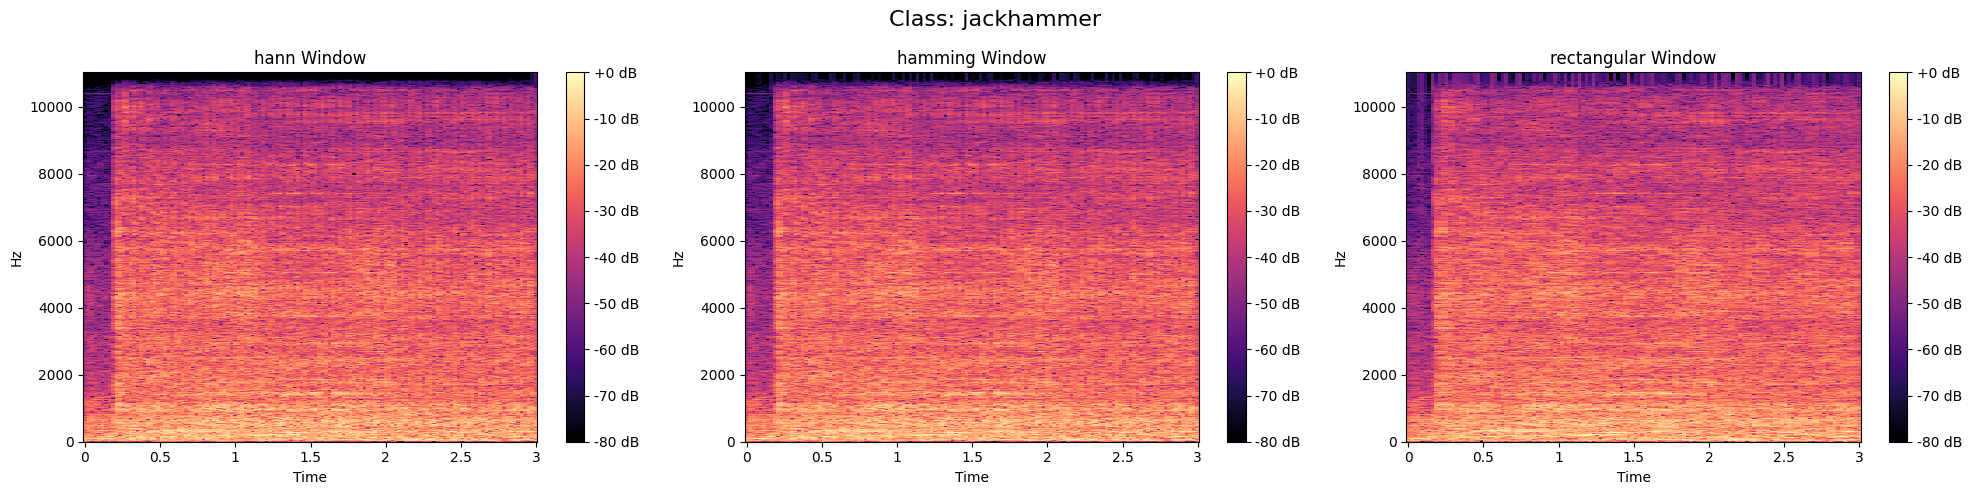


Processing class: siren


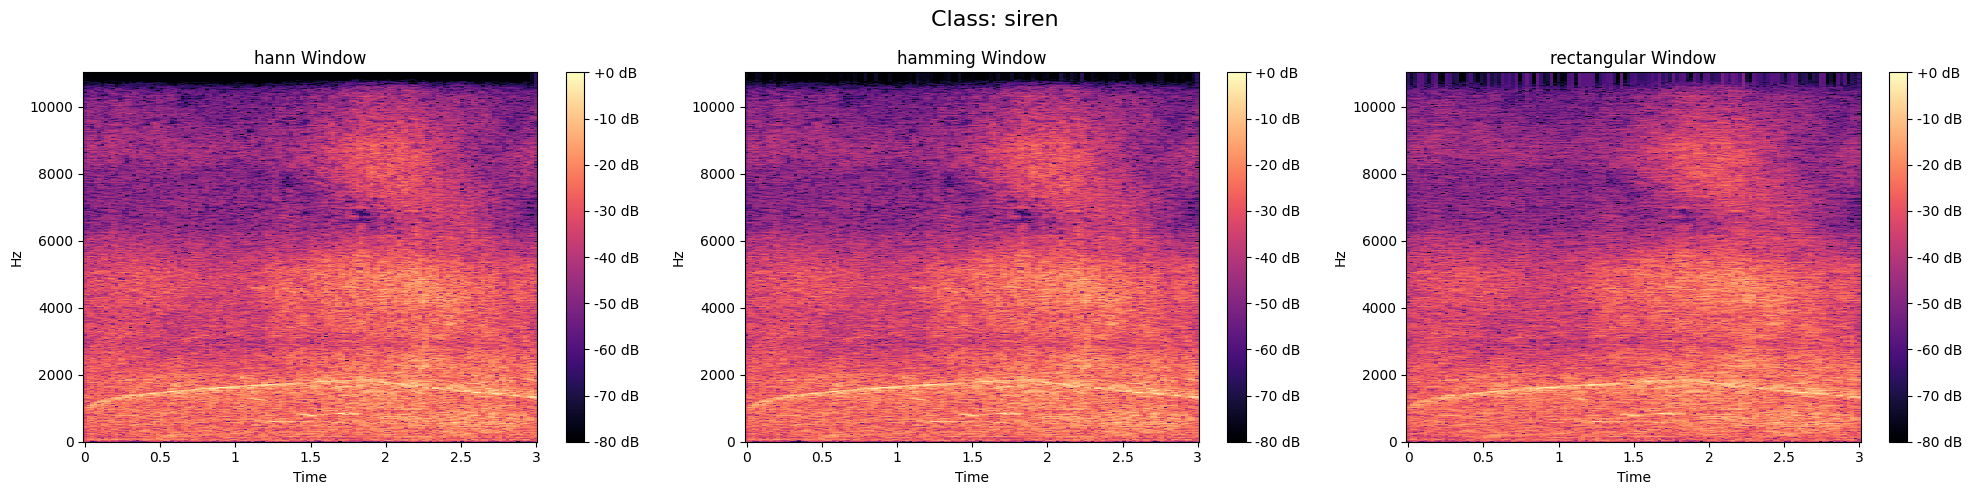


Processing class: street_music


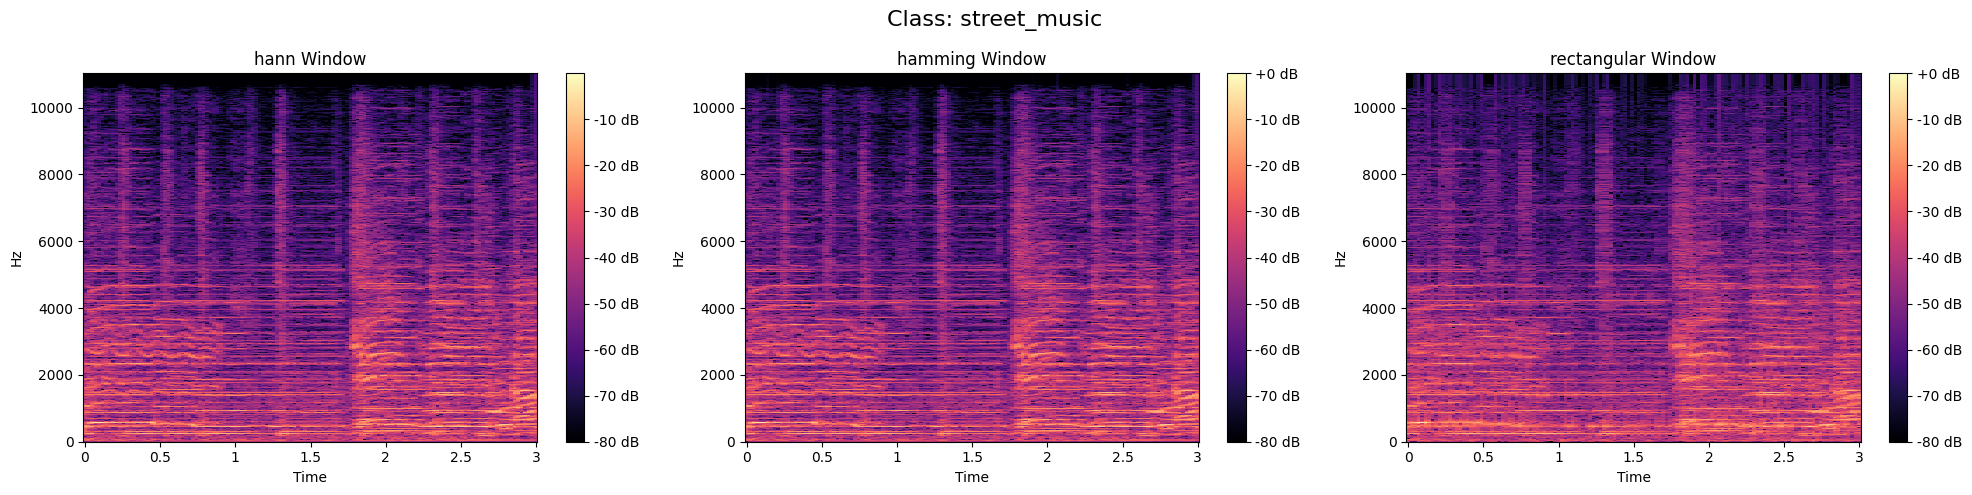

In [11]:
plot_spectrograms_by_class(metadata_path, audio_base_path, fold=1)

In [12]:
# window_types = ['hann', 'hamming', 'rectangular']
# train_folds = [1, 2, 3, 4, 5, 6, 7, 8]
# test_folds = [9, 10]

In [13]:
window_results = {}

In [14]:
# Train with Hann window
print("Training with Hann window...")
hann_results = k_fold_train_single_window(metadata_path, audio_base_path, 'hann')
window_results['Hann'] = hann_results

Training with Hann window...

Starting 10-fold cross validation for hann window

Training on fold 1 as validation set

Preparing data for hann window
Processing training folds: [2, 3, 4, 5, 6, 7, 8, 9, 10]


Fold 2: 888it [00:07, 116.47it/s]
Fold 3: 925it [00:07, 119.59it/s]
Fold 4: 990it [00:08, 113.61it/s]
Fold 5: 936it [00:07, 118.30it/s]
Fold 6: 823it [00:07, 116.11it/s]
Fold 7: 838it [00:07, 112.96it/s]
Fold 8: 806it [00:07, 111.87it/s]
Fold 9: 816it [00:07, 112.28it/s]
Fold 10: 837it [00:07, 119.53it/s]



Processing test folds: [1]


Fold 1: 873it [00:09, 93.31it/s] 



Final shapes:
X_train: (7859, 128, 128)
X_test: (873, 128, 128)


Epoch 1/20: 100%|██████████| 246/246 [00:12<00:00, 19.48it/s]



Epoch 1/20:
Train Loss: 7.442, Train Acc: 38.48%
Val Loss: 3.736, Val Acc: 49.71%


Epoch 2/20: 100%|██████████| 246/246 [00:11<00:00, 21.58it/s]



Epoch 2/20:
Train Loss: 4.197, Train Acc: 49.99%
Val Loss: 2.307, Val Acc: 57.27%


Epoch 3/20: 100%|██████████| 246/246 [00:11<00:00, 21.67it/s]



Epoch 3/20:
Train Loss: 3.125, Train Acc: 56.46%
Val Loss: 2.344, Val Acc: 59.11%


Epoch 4/20: 100%|██████████| 246/246 [00:11<00:00, 21.61it/s]



Epoch 4/20:
Train Loss: 2.517, Train Acc: 62.37%
Val Loss: 2.785, Val Acc: 63.23%


Epoch 5/20: 100%|██████████| 246/246 [00:11<00:00, 21.65it/s]



Epoch 5/20:
Train Loss: 2.119, Train Acc: 67.45%
Val Loss: 2.585, Val Acc: 57.50%


Epoch 6/20: 100%|██████████| 246/246 [00:11<00:00, 21.57it/s]



Epoch 6/20:
Train Loss: 1.697, Train Acc: 71.32%
Val Loss: 2.607, Val Acc: 59.68%


Epoch 7/20: 100%|██████████| 246/246 [00:11<00:00, 21.66it/s]



Epoch 7/20:
Train Loss: 1.262, Train Acc: 76.89%
Val Loss: 2.146, Val Acc: 62.89%


Epoch 8/20: 100%|██████████| 246/246 [00:11<00:00, 20.72it/s]



Epoch 8/20:
Train Loss: 1.052, Train Acc: 79.25%
Val Loss: 2.194, Val Acc: 65.06%


Epoch 9/20: 100%|██████████| 246/246 [00:11<00:00, 21.49it/s]



Epoch 9/20:
Train Loss: 1.019, Train Acc: 79.95%
Val Loss: 2.463, Val Acc: 62.08%


Epoch 10/20: 100%|██████████| 246/246 [00:11<00:00, 21.61it/s]



Epoch 10/20:
Train Loss: 0.997, Train Acc: 80.48%
Val Loss: 2.306, Val Acc: 64.26%


Epoch 11/20: 100%|██████████| 246/246 [00:11<00:00, 21.58it/s]



Epoch 11/20:
Train Loss: 0.883, Train Acc: 82.03%
Val Loss: 2.414, Val Acc: 62.20%


Epoch 12/20: 100%|██████████| 246/246 [00:11<00:00, 21.77it/s]



Epoch 12/20:
Train Loss: 0.869, Train Acc: 82.59%
Val Loss: 2.376, Val Acc: 62.31%


Epoch 13/20: 100%|██████████| 246/246 [00:11<00:00, 21.65it/s]



Epoch 13/20:
Train Loss: 0.836, Train Acc: 83.29%
Val Loss: 2.368, Val Acc: 62.66%


Epoch 14/20: 100%|██████████| 246/246 [00:11<00:00, 21.61it/s]



Epoch 14/20:
Train Loss: 0.832, Train Acc: 83.01%
Val Loss: 2.329, Val Acc: 63.00%


Epoch 15/20: 100%|██████████| 246/246 [00:11<00:00, 21.62it/s]



Epoch 15/20:
Train Loss: 0.831, Train Acc: 83.48%
Val Loss: 2.341, Val Acc: 63.12%


Epoch 16/20: 100%|██████████| 246/246 [00:11<00:00, 21.63it/s]



Epoch 16/20:
Train Loss: 0.831, Train Acc: 82.85%
Val Loss: 2.379, Val Acc: 63.00%


Epoch 17/20: 100%|██████████| 246/246 [00:11<00:00, 21.59it/s]



Epoch 17/20:
Train Loss: 0.806, Train Acc: 83.50%
Val Loss: 2.167, Val Acc: 64.49%

Early stopping triggered after epoch 17

Training on fold 2 as validation set

Preparing data for hann window
Processing training folds: [1, 3, 4, 5, 6, 7, 8, 9, 10]


Fold 1: 873it [00:07, 114.26it/s]
Fold 3: 925it [00:07, 119.34it/s]
Fold 4: 990it [00:08, 122.37it/s]
Fold 5: 936it [00:07, 128.26it/s]
Fold 6: 823it [00:06, 130.41it/s]
Fold 7: 838it [00:06, 124.34it/s]
Fold 8: 806it [00:06, 122.84it/s]
Fold 9: 816it [00:08, 97.37it/s] 
Fold 10: 837it [00:12, 66.37it/s]



Processing test folds: [2]


Fold 2: 888it [00:14, 59.30it/s]



Final shapes:
X_train: (7844, 128, 128)
X_test: (888, 128, 128)


Epoch 1/20: 100%|██████████| 246/246 [00:11<00:00, 21.13it/s]



Epoch 1/20:
Train Loss: 7.404, Train Acc: 39.30%
Val Loss: 3.387, Val Acc: 47.75%


Epoch 2/20: 100%|██████████| 246/246 [00:11<00:00, 21.72it/s]



Epoch 2/20:
Train Loss: 3.986, Train Acc: 51.21%
Val Loss: 2.850, Val Acc: 51.80%


Epoch 3/20: 100%|██████████| 246/246 [00:11<00:00, 21.57it/s]



Epoch 3/20:
Train Loss: 3.109, Train Acc: 58.49%
Val Loss: 2.517, Val Acc: 54.50%


Epoch 4/20: 100%|██████████| 246/246 [00:11<00:00, 21.67it/s]



Epoch 4/20:
Train Loss: 2.471, Train Acc: 63.84%
Val Loss: 1.903, Val Acc: 58.56%


Epoch 5/20: 100%|██████████| 246/246 [00:11<00:00, 21.70it/s]



Epoch 5/20:
Train Loss: 1.998, Train Acc: 68.36%
Val Loss: 2.694, Val Acc: 59.01%


Epoch 6/20: 100%|██████████| 246/246 [00:11<00:00, 21.86it/s]



Epoch 6/20:
Train Loss: 1.685, Train Acc: 72.57%
Val Loss: 2.892, Val Acc: 54.05%


Epoch 7/20: 100%|██████████| 246/246 [00:11<00:00, 21.82it/s]



Epoch 7/20:
Train Loss: 1.362, Train Acc: 76.17%
Val Loss: 2.406, Val Acc: 61.82%


Epoch 8/20: 100%|██████████| 246/246 [00:11<00:00, 21.85it/s]



Epoch 8/20:
Train Loss: 1.104, Train Acc: 78.72%
Val Loss: 2.320, Val Acc: 58.56%


Epoch 9/20: 100%|██████████| 246/246 [00:11<00:00, 21.76it/s]



Epoch 9/20:
Train Loss: 0.790, Train Acc: 84.50%
Val Loss: 2.211, Val Acc: 67.34%


Epoch 10/20: 100%|██████████| 246/246 [00:11<00:00, 21.58it/s]



Epoch 10/20:
Train Loss: 0.662, Train Acc: 85.52%
Val Loss: 2.210, Val Acc: 67.45%


Epoch 11/20: 100%|██████████| 246/246 [00:11<00:00, 21.67it/s]



Epoch 11/20:
Train Loss: 0.599, Train Acc: 86.98%
Val Loss: 2.233, Val Acc: 66.78%


Epoch 12/20: 100%|██████████| 246/246 [00:11<00:00, 21.66it/s]



Epoch 12/20:
Train Loss: 0.565, Train Acc: 87.61%
Val Loss: 2.218, Val Acc: 66.55%


Epoch 13/20: 100%|██████████| 246/246 [00:11<00:00, 21.72it/s]



Epoch 13/20:
Train Loss: 0.541, Train Acc: 88.32%
Val Loss: 2.368, Val Acc: 67.45%


Epoch 14/20: 100%|██████████| 246/246 [00:11<00:00, 21.54it/s]



Epoch 14/20:
Train Loss: 0.508, Train Acc: 88.58%
Val Loss: 2.506, Val Acc: 66.67%

Early stopping triggered after epoch 14

Training on fold 3 as validation set

Preparing data for hann window
Processing training folds: [1, 2, 4, 5, 6, 7, 8, 9, 10]


Fold 1: 873it [00:15, 55.03it/s]
Fold 2: 888it [00:08, 101.24it/s]
Fold 4: 990it [00:15, 63.06it/s]
Fold 5: 936it [00:14, 62.83it/s]
Fold 6: 823it [00:14, 58.30it/s]
Fold 7: 838it [00:13, 63.53it/s]
Fold 8: 806it [00:15, 52.58it/s]
Fold 9: 816it [00:13, 60.29it/s]
Fold 10: 837it [00:08, 101.27it/s]



Processing test folds: [3]


Fold 3: 925it [00:28, 32.04it/s]



Final shapes:
X_train: (7807, 128, 128)
X_test: (925, 128, 128)


Epoch 1/20: 100%|██████████| 244/244 [00:12<00:00, 19.67it/s]



Epoch 1/20:
Train Loss: 7.229, Train Acc: 37.58%
Val Loss: 4.391, Val Acc: 47.68%


Epoch 2/20: 100%|██████████| 244/244 [00:11<00:00, 21.46it/s]



Epoch 2/20:
Train Loss: 4.221, Train Acc: 50.86%
Val Loss: 3.178, Val Acc: 49.19%


Epoch 3/20: 100%|██████████| 244/244 [00:11<00:00, 21.33it/s]



Epoch 3/20:
Train Loss: 3.203, Train Acc: 57.92%
Val Loss: 3.221, Val Acc: 52.11%


Epoch 4/20: 100%|██████████| 244/244 [00:11<00:00, 21.40it/s]



Epoch 4/20:
Train Loss: 2.476, Train Acc: 64.25%
Val Loss: 3.237, Val Acc: 53.41%


Epoch 5/20: 100%|██████████| 244/244 [00:11<00:00, 21.51it/s]



Epoch 5/20:
Train Loss: 2.057, Train Acc: 68.20%
Val Loss: 2.931, Val Acc: 55.14%


Epoch 6/20: 100%|██████████| 244/244 [00:11<00:00, 21.63it/s]



Epoch 6/20:
Train Loss: 1.777, Train Acc: 71.87%
Val Loss: 3.424, Val Acc: 54.49%


Epoch 7/20: 100%|██████████| 244/244 [00:11<00:00, 21.58it/s]



Epoch 7/20:
Train Loss: 1.410, Train Acc: 75.80%
Val Loss: 3.392, Val Acc: 53.51%


Epoch 8/20: 100%|██████████| 244/244 [00:11<00:00, 21.36it/s]



Epoch 8/20:
Train Loss: 1.164, Train Acc: 79.28%
Val Loss: 3.408, Val Acc: 58.16%


Epoch 9/20: 100%|██████████| 244/244 [00:11<00:00, 21.34it/s]



Epoch 9/20:
Train Loss: 0.950, Train Acc: 82.40%
Val Loss: 4.627, Val Acc: 58.38%


Epoch 10/20: 100%|██████████| 244/244 [00:11<00:00, 21.66it/s]



Epoch 10/20:
Train Loss: 0.638, Train Acc: 86.86%
Val Loss: 4.148, Val Acc: 56.54%


Epoch 11/20: 100%|██████████| 244/244 [00:11<00:00, 21.43it/s]



Epoch 11/20:
Train Loss: 0.571, Train Acc: 87.87%
Val Loss: 3.967, Val Acc: 56.76%


Epoch 12/20: 100%|██████████| 244/244 [00:11<00:00, 21.37it/s]



Epoch 12/20:
Train Loss: 0.507, Train Acc: 88.98%
Val Loss: 3.950, Val Acc: 56.22%


Epoch 13/20: 100%|██████████| 244/244 [00:11<00:00, 20.46it/s]



Epoch 13/20:
Train Loss: 0.469, Train Acc: 89.89%
Val Loss: 4.158, Val Acc: 55.46%


Epoch 14/20: 100%|██████████| 244/244 [00:11<00:00, 21.05it/s]



Epoch 14/20:
Train Loss: 0.450, Train Acc: 90.30%
Val Loss: 4.405, Val Acc: 55.46%


Epoch 15/20: 100%|██████████| 244/244 [00:11<00:00, 21.24it/s]



Epoch 15/20:
Train Loss: 0.420, Train Acc: 90.83%
Val Loss: 4.374, Val Acc: 56.22%

Early stopping triggered after epoch 15

Training on fold 4 as validation set

Preparing data for hann window
Processing training folds: [1, 2, 3, 5, 6, 7, 8, 9, 10]


Fold 1: 873it [00:08, 97.49it/s] 
Fold 2: 888it [00:10, 86.94it/s] 
Fold 3: 925it [00:09, 98.55it/s] 
Fold 5: 936it [00:10, 89.33it/s] 
Fold 6: 823it [00:09, 84.52it/s] 
Fold 7: 838it [00:08, 100.50it/s]
Fold 8: 806it [00:07, 102.12it/s]
Fold 9: 816it [00:08, 101.55it/s]
Fold 10: 837it [00:08, 93.88it/s] 



Processing test folds: [4]


Fold 4: 990it [00:12, 77.67it/s]



Final shapes:
X_train: (7742, 128, 128)
X_test: (990, 128, 128)


Epoch 1/20: 100%|██████████| 242/242 [00:11<00:00, 20.67it/s]



Epoch 1/20:
Train Loss: 7.257, Train Acc: 36.92%
Val Loss: 5.671, Val Acc: 44.95%


Epoch 2/20: 100%|██████████| 242/242 [00:11<00:00, 21.26it/s]



Epoch 2/20:
Train Loss: 4.174, Train Acc: 47.99%
Val Loss: 2.702, Val Acc: 60.61%


Epoch 3/20: 100%|██████████| 242/242 [00:11<00:00, 20.71it/s]



Epoch 3/20:
Train Loss: 3.152, Train Acc: 54.46%
Val Loss: 2.289, Val Acc: 62.73%


Epoch 4/20: 100%|██████████| 242/242 [00:11<00:00, 21.22it/s]



Epoch 4/20:
Train Loss: 2.471, Train Acc: 61.53%
Val Loss: 2.183, Val Acc: 66.77%


Epoch 5/20: 100%|██████████| 242/242 [00:11<00:00, 21.29it/s]



Epoch 5/20:
Train Loss: 2.072, Train Acc: 66.00%
Val Loss: 2.155, Val Acc: 65.45%


Epoch 6/20: 100%|██████████| 242/242 [00:11<00:00, 21.43it/s]



Epoch 6/20:
Train Loss: 1.760, Train Acc: 69.98%
Val Loss: 2.243, Val Acc: 61.92%


Epoch 7/20: 100%|██████████| 242/242 [00:11<00:00, 21.34it/s]



Epoch 7/20:
Train Loss: 1.539, Train Acc: 72.44%
Val Loss: 2.119, Val Acc: 68.59%


Epoch 8/20: 100%|██████████| 242/242 [00:11<00:00, 21.59it/s]



Epoch 8/20:
Train Loss: 1.396, Train Acc: 75.12%
Val Loss: 2.058, Val Acc: 68.28%


Epoch 9/20: 100%|██████████| 242/242 [00:11<00:00, 21.53it/s]



Epoch 9/20:
Train Loss: 1.111, Train Acc: 78.38%
Val Loss: 2.091, Val Acc: 68.28%


Epoch 10/20: 100%|██████████| 242/242 [00:11<00:00, 21.38it/s]



Epoch 10/20:
Train Loss: 0.951, Train Acc: 80.37%
Val Loss: 2.241, Val Acc: 61.52%


Epoch 11/20: 100%|██████████| 242/242 [00:11<00:00, 21.45it/s]



Epoch 11/20:
Train Loss: 0.775, Train Acc: 83.57%
Val Loss: 1.861, Val Acc: 67.58%


Epoch 12/20: 100%|██████████| 242/242 [00:11<00:00, 21.42it/s]



Epoch 12/20:
Train Loss: 0.698, Train Acc: 84.95%
Val Loss: 2.942, Val Acc: 66.46%


Epoch 13/20: 100%|██████████| 242/242 [00:11<00:00, 21.45it/s]



Epoch 13/20:
Train Loss: 0.590, Train Acc: 87.03%
Val Loss: 2.766, Val Acc: 66.67%


Epoch 14/20: 100%|██████████| 242/242 [00:11<00:00, 21.35it/s]



Epoch 14/20:
Train Loss: 0.521, Train Acc: 88.59%
Val Loss: 3.177, Val Acc: 60.40%


Epoch 15/20: 100%|██████████| 242/242 [00:11<00:00, 21.05it/s]



Epoch 15/20:
Train Loss: 0.471, Train Acc: 89.89%
Val Loss: 2.675, Val Acc: 66.06%


Epoch 16/20: 100%|██████████| 242/242 [00:11<00:00, 20.41it/s]



Epoch 16/20:
Train Loss: 0.261, Train Acc: 93.48%
Val Loss: 2.420, Val Acc: 65.35%


Epoch 17/20: 100%|██████████| 242/242 [00:11<00:00, 21.06it/s]



Epoch 17/20:
Train Loss: 0.250, Train Acc: 94.21%
Val Loss: 2.553, Val Acc: 67.37%


Epoch 18/20: 100%|██████████| 242/242 [00:11<00:00, 20.82it/s]



Epoch 18/20:
Train Loss: 0.217, Train Acc: 94.89%
Val Loss: 2.415, Val Acc: 67.68%


Epoch 19/20: 100%|██████████| 242/242 [00:11<00:00, 21.11it/s]



Epoch 19/20:
Train Loss: 0.203, Train Acc: 95.45%
Val Loss: 2.488, Val Acc: 67.17%


Epoch 20/20: 100%|██████████| 242/242 [00:11<00:00, 21.21it/s]



Epoch 20/20:
Train Loss: 0.187, Train Acc: 95.74%
Val Loss: 2.500, Val Acc: 66.57%

Training on fold 5 as validation set

Preparing data for hann window
Processing training folds: [1, 2, 3, 4, 6, 7, 8, 9, 10]


Fold 1: 873it [00:09, 94.61it/s] 
Fold 2: 888it [00:07, 116.34it/s]
Fold 3: 925it [00:09, 99.77it/s] 
Fold 4: 990it [00:10, 96.44it/s] 
Fold 6: 823it [00:08, 98.55it/s] 
Fold 7: 838it [00:08, 97.39it/s] 
Fold 8: 806it [00:08, 93.53it/s] 
Fold 9: 816it [00:09, 88.54it/s] 
Fold 10: 837it [00:08, 97.24it/s] 



Processing test folds: [5]


Fold 5: 936it [00:09, 96.71it/s] 



Final shapes:
X_train: (7796, 128, 128)
X_test: (936, 128, 128)


Epoch 1/20: 100%|██████████| 244/244 [00:13<00:00, 17.79it/s]



Epoch 1/20:
Train Loss: 7.283, Train Acc: 38.17%
Val Loss: 3.804, Val Acc: 46.37%


Epoch 2/20: 100%|██████████| 244/244 [00:13<00:00, 17.70it/s]



Epoch 2/20:
Train Loss: 4.074, Train Acc: 49.32%
Val Loss: 3.515, Val Acc: 51.92%


Epoch 3/20: 100%|██████████| 244/244 [00:14<00:00, 17.37it/s]



Epoch 3/20:
Train Loss: 3.042, Train Acc: 57.23%
Val Loss: 3.283, Val Acc: 62.39%


Epoch 4/20: 100%|██████████| 244/244 [00:13<00:00, 18.22it/s]



Epoch 4/20:
Train Loss: 2.383, Train Acc: 63.44%
Val Loss: 3.165, Val Acc: 62.07%


Epoch 5/20: 100%|██████████| 244/244 [00:13<00:00, 18.57it/s]



Epoch 5/20:
Train Loss: 1.991, Train Acc: 67.10%
Val Loss: 2.941, Val Acc: 60.26%


Epoch 6/20: 100%|██████████| 244/244 [00:12<00:00, 18.89it/s]



Epoch 6/20:
Train Loss: 1.684, Train Acc: 71.41%
Val Loss: 3.155, Val Acc: 59.51%


Epoch 7/20: 100%|██████████| 244/244 [00:13<00:00, 18.32it/s]



Epoch 7/20:
Train Loss: 1.428, Train Acc: 74.91%
Val Loss: 3.617, Val Acc: 61.54%


Epoch 8/20: 100%|██████████| 244/244 [00:13<00:00, 18.30it/s]



Epoch 8/20:
Train Loss: 1.224, Train Acc: 77.51%
Val Loss: 3.378, Val Acc: 60.36%


Epoch 9/20: 100%|██████████| 244/244 [00:13<00:00, 18.25it/s]



Epoch 9/20:
Train Loss: 0.966, Train Acc: 81.39%
Val Loss: 3.992, Val Acc: 61.11%


Epoch 10/20: 100%|██████████| 244/244 [00:12<00:00, 18.77it/s]



Epoch 10/20:
Train Loss: 0.691, Train Acc: 85.60%
Val Loss: 3.128, Val Acc: 62.93%


Epoch 11/20: 100%|██████████| 244/244 [00:12<00:00, 18.87it/s]



Epoch 11/20:
Train Loss: 0.589, Train Acc: 86.99%
Val Loss: 3.080, Val Acc: 64.00%


Epoch 12/20: 100%|██████████| 244/244 [00:13<00:00, 18.64it/s]



Epoch 12/20:
Train Loss: 0.557, Train Acc: 88.31%
Val Loss: 3.084, Val Acc: 63.68%


Epoch 13/20: 100%|██████████| 244/244 [00:13<00:00, 18.52it/s]



Epoch 13/20:
Train Loss: 0.478, Train Acc: 89.07%
Val Loss: 2.744, Val Acc: 64.10%


Epoch 14/20: 100%|██████████| 244/244 [00:13<00:00, 18.53it/s]



Epoch 14/20:
Train Loss: 0.462, Train Acc: 90.07%
Val Loss: 2.952, Val Acc: 64.74%


Epoch 15/20: 100%|██████████| 244/244 [00:13<00:00, 18.04it/s]



Epoch 15/20:
Train Loss: 0.431, Train Acc: 90.26%
Val Loss: 2.875, Val Acc: 63.78%


Epoch 16/20: 100%|██████████| 244/244 [00:13<00:00, 18.10it/s]



Epoch 16/20:
Train Loss: 0.442, Train Acc: 90.35%
Val Loss: 2.906, Val Acc: 65.38%


Epoch 17/20: 100%|██████████| 244/244 [00:12<00:00, 18.79it/s]



Epoch 17/20:
Train Loss: 0.364, Train Acc: 91.66%
Val Loss: 3.004, Val Acc: 64.96%


Epoch 18/20: 100%|██████████| 244/244 [00:12<00:00, 18.83it/s]



Epoch 18/20:
Train Loss: 0.373, Train Acc: 91.69%
Val Loss: 2.997, Val Acc: 65.28%


Epoch 19/20: 100%|██████████| 244/244 [00:12<00:00, 18.87it/s]



Epoch 19/20:
Train Loss: 0.331, Train Acc: 92.38%
Val Loss: 2.954, Val Acc: 65.06%


Epoch 20/20: 100%|██████████| 244/244 [00:13<00:00, 18.40it/s]



Epoch 20/20:
Train Loss: 0.347, Train Acc: 91.98%
Val Loss: 3.165, Val Acc: 64.32%

Training on fold 6 as validation set

Preparing data for hann window
Processing training folds: [1, 2, 3, 4, 5, 7, 8, 9, 10]


Fold 1: 873it [00:09, 95.31it/s] 
Fold 2: 888it [00:08, 100.52it/s]
Fold 3: 925it [00:08, 109.34it/s]
Fold 4: 990it [00:09, 104.72it/s]
Fold 5: 936it [00:08, 106.72it/s]
Fold 7: 838it [00:07, 111.44it/s]
Fold 8: 806it [00:07, 106.56it/s]
Fold 9: 816it [00:08, 93.09it/s] 
Fold 10: 837it [00:08, 99.17it/s] 



Processing test folds: [6]


Fold 6: 823it [00:07, 110.19it/s]



Final shapes:
X_train: (7909, 128, 128)
X_test: (823, 128, 128)


Epoch 1/20: 100%|██████████| 248/248 [00:13<00:00, 18.09it/s]



Epoch 1/20:
Train Loss: 7.443, Train Acc: 37.64%
Val Loss: 3.602, Val Acc: 50.67%


Epoch 2/20: 100%|██████████| 248/248 [00:13<00:00, 18.50it/s]



Epoch 2/20:
Train Loss: 4.056, Train Acc: 52.45%
Val Loss: 2.944, Val Acc: 50.79%


Epoch 3/20: 100%|██████████| 248/248 [00:13<00:00, 18.50it/s]



Epoch 3/20:
Train Loss: 3.034, Train Acc: 60.69%
Val Loss: 3.522, Val Acc: 56.26%


Epoch 4/20: 100%|██████████| 248/248 [00:13<00:00, 18.67it/s]



Epoch 4/20:
Train Loss: 2.367, Train Acc: 66.49%
Val Loss: 3.125, Val Acc: 53.58%


Epoch 5/20: 100%|██████████| 248/248 [00:13<00:00, 18.47it/s]



Epoch 5/20:
Train Loss: 1.904, Train Acc: 70.39%
Val Loss: 3.380, Val Acc: 59.66%


Epoch 6/20: 100%|██████████| 248/248 [00:13<00:00, 18.68it/s]



Epoch 6/20:
Train Loss: 1.536, Train Acc: 74.76%
Val Loss: 2.984, Val Acc: 58.20%


Epoch 7/20: 100%|██████████| 248/248 [00:13<00:00, 18.70it/s]



Epoch 7/20:
Train Loss: 1.099, Train Acc: 79.98%
Val Loss: 2.855, Val Acc: 58.93%


Epoch 8/20: 100%|██████████| 248/248 [00:13<00:00, 18.88it/s]



Epoch 8/20:
Train Loss: 0.917, Train Acc: 82.55%
Val Loss: 2.727, Val Acc: 61.48%


Epoch 9/20: 100%|██████████| 248/248 [00:13<00:00, 18.20it/s]



Epoch 9/20:
Train Loss: 0.890, Train Acc: 83.10%
Val Loss: 3.042, Val Acc: 60.27%


Epoch 10/20: 100%|██████████| 248/248 [00:13<00:00, 18.38it/s]



Epoch 10/20:
Train Loss: 0.779, Train Acc: 85.08%
Val Loss: 2.877, Val Acc: 61.60%


Epoch 11/20: 100%|██████████| 248/248 [00:13<00:00, 18.66it/s]



Epoch 11/20:
Train Loss: 0.714, Train Acc: 85.50%
Val Loss: 2.944, Val Acc: 59.90%


Epoch 12/20: 100%|██████████| 248/248 [00:13<00:00, 18.45it/s]



Epoch 12/20:
Train Loss: 0.752, Train Acc: 85.83%
Val Loss: 3.204, Val Acc: 60.63%


Epoch 13/20: 100%|██████████| 248/248 [00:13<00:00, 18.38it/s]



Epoch 13/20:
Train Loss: 0.636, Train Acc: 86.96%
Val Loss: 3.062, Val Acc: 61.48%


Epoch 14/20: 100%|██████████| 248/248 [00:13<00:00, 18.33it/s]



Epoch 14/20:
Train Loss: 0.677, Train Acc: 86.80%
Val Loss: 2.758, Val Acc: 61.12%


Epoch 15/20: 100%|██████████| 248/248 [00:13<00:00, 18.66it/s]



Epoch 15/20:
Train Loss: 0.625, Train Acc: 87.18%
Val Loss: 2.943, Val Acc: 61.36%


Epoch 16/20: 100%|██████████| 248/248 [00:13<00:00, 18.39it/s]



Epoch 16/20:
Train Loss: 0.620, Train Acc: 87.32%
Val Loss: 3.096, Val Acc: 60.63%


Epoch 17/20: 100%|██████████| 248/248 [00:13<00:00, 18.26it/s]



Epoch 17/20:
Train Loss: 0.585, Train Acc: 87.76%
Val Loss: 3.150, Val Acc: 61.48%


Epoch 18/20: 100%|██████████| 248/248 [00:13<00:00, 18.04it/s]



Epoch 18/20:
Train Loss: 0.612, Train Acc: 87.57%
Val Loss: 3.171, Val Acc: 61.12%

Early stopping triggered after epoch 18

Training on fold 7 as validation set

Preparing data for hann window
Processing training folds: [1, 2, 3, 4, 5, 6, 8, 9, 10]


Fold 1: 873it [00:09, 92.76it/s] 
Fold 2: 888it [00:08, 100.44it/s]
Fold 3: 925it [00:08, 104.00it/s]
Fold 4: 990it [00:09, 101.10it/s]
Fold 5: 936it [00:08, 105.07it/s]
Fold 6: 823it [00:07, 103.55it/s]
Fold 8: 806it [00:08, 96.28it/s] 
Fold 9: 816it [00:09, 90.57it/s] 
Fold 10: 837it [00:09, 91.25it/s] 



Processing test folds: [7]


Fold 7: 838it [00:09, 87.40it/s] 



Final shapes:
X_train: (7894, 128, 128)
X_test: (838, 128, 128)


Epoch 1/20: 100%|██████████| 247/247 [00:13<00:00, 17.68it/s]



Epoch 1/20:
Train Loss: 7.412, Train Acc: 36.80%
Val Loss: 2.740, Val Acc: 47.37%


Epoch 2/20: 100%|██████████| 247/247 [00:13<00:00, 18.56it/s]



Epoch 2/20:
Train Loss: 4.179, Train Acc: 47.86%
Val Loss: 2.325, Val Acc: 50.48%


Epoch 3/20: 100%|██████████| 247/247 [00:13<00:00, 18.31it/s]



Epoch 3/20:
Train Loss: 3.335, Train Acc: 54.48%
Val Loss: 2.101, Val Acc: 55.49%


Epoch 4/20: 100%|██████████| 247/247 [00:13<00:00, 18.32it/s]



Epoch 4/20:
Train Loss: 2.680, Train Acc: 60.43%
Val Loss: 2.084, Val Acc: 58.35%


Epoch 5/20: 100%|██████████| 247/247 [00:13<00:00, 18.13it/s]



Epoch 5/20:
Train Loss: 2.378, Train Acc: 64.09%
Val Loss: 2.261, Val Acc: 56.80%


Epoch 6/20: 100%|██████████| 247/247 [00:13<00:00, 18.68it/s]



Epoch 6/20:
Train Loss: 1.901, Train Acc: 67.98%
Val Loss: 3.539, Val Acc: 55.49%


Epoch 7/20: 100%|██████████| 247/247 [00:13<00:00, 18.48it/s]



Epoch 7/20:
Train Loss: 1.546, Train Acc: 72.12%
Val Loss: 2.078, Val Acc: 58.47%


Epoch 8/20: 100%|██████████| 247/247 [00:13<00:00, 18.57it/s]



Epoch 8/20:
Train Loss: 1.451, Train Acc: 74.20%
Val Loss: 1.640, Val Acc: 62.77%


Epoch 9/20: 100%|██████████| 247/247 [00:13<00:00, 18.18it/s]



Epoch 9/20:
Train Loss: 1.148, Train Acc: 77.96%
Val Loss: 1.731, Val Acc: 62.53%


Epoch 10/20: 100%|██████████| 247/247 [00:13<00:00, 17.94it/s]



Epoch 10/20:
Train Loss: 1.001, Train Acc: 80.33%
Val Loss: 1.952, Val Acc: 61.34%


Epoch 11/20: 100%|██████████| 247/247 [00:13<00:00, 18.48it/s]



Epoch 11/20:
Train Loss: 0.888, Train Acc: 81.91%
Val Loss: 1.961, Val Acc: 61.81%


Epoch 12/20: 100%|██████████| 247/247 [00:13<00:00, 18.52it/s]



Epoch 12/20:
Train Loss: 0.713, Train Acc: 85.24%
Val Loss: 1.825, Val Acc: 64.08%


Epoch 13/20: 100%|██████████| 247/247 [00:13<00:00, 18.62it/s]



Epoch 13/20:
Train Loss: 0.549, Train Acc: 87.90%
Val Loss: 1.699, Val Acc: 66.71%


Epoch 14/20: 100%|██████████| 247/247 [00:13<00:00, 18.53it/s]



Epoch 14/20:
Train Loss: 0.446, Train Acc: 90.22%
Val Loss: 1.665, Val Acc: 67.42%


Epoch 15/20: 100%|██████████| 247/247 [00:13<00:00, 18.19it/s]



Epoch 15/20:
Train Loss: 0.386, Train Acc: 90.97%
Val Loss: 1.685, Val Acc: 67.66%


Epoch 16/20: 100%|██████████| 247/247 [00:13<00:00, 18.10it/s]



Epoch 16/20:
Train Loss: 0.365, Train Acc: 91.65%
Val Loss: 1.718, Val Acc: 68.38%


Epoch 17/20: 100%|██████████| 247/247 [00:13<00:00, 18.11it/s]



Epoch 17/20:
Train Loss: 0.344, Train Acc: 91.77%
Val Loss: 1.672, Val Acc: 69.09%


Epoch 18/20: 100%|██████████| 247/247 [00:13<00:00, 18.75it/s]



Epoch 18/20:
Train Loss: 0.345, Train Acc: 91.89%
Val Loss: 1.653, Val Acc: 68.74%

Early stopping triggered after epoch 18

Training on fold 8 as validation set

Preparing data for hann window
Processing training folds: [1, 2, 3, 4, 5, 6, 7, 9, 10]


Fold 1: 873it [00:09, 95.89it/s] 
Fold 2: 888it [00:08, 101.98it/s]
Fold 3: 925it [00:09, 102.17it/s]
Fold 4: 990it [00:10, 97.89it/s] 
Fold 5: 936it [00:09, 93.93it/s] 
Fold 6: 823it [00:08, 93.32it/s] 
Fold 7: 838it [00:08, 100.32it/s]
Fold 9: 816it [00:08, 101.74it/s]
Fold 10: 837it [00:08, 94.13it/s] 



Processing test folds: [8]


Fold 8: 806it [00:08, 91.18it/s] 



Final shapes:
X_train: (7926, 128, 128)
X_test: (806, 128, 128)


Epoch 1/20: 100%|██████████| 248/248 [00:14<00:00, 17.44it/s]



Epoch 1/20:
Train Loss: 7.210, Train Acc: 38.57%
Val Loss: 2.895, Val Acc: 45.66%


Epoch 2/20: 100%|██████████| 248/248 [00:13<00:00, 18.15it/s]



Epoch 2/20:
Train Loss: 4.047, Train Acc: 51.56%
Val Loss: 2.220, Val Acc: 58.06%


Epoch 3/20: 100%|██████████| 248/248 [00:13<00:00, 18.29it/s]



Epoch 3/20:
Train Loss: 2.920, Train Acc: 59.70%
Val Loss: 2.352, Val Acc: 57.94%


Epoch 4/20: 100%|██████████| 248/248 [00:13<00:00, 18.51it/s]



Epoch 4/20:
Train Loss: 2.536, Train Acc: 63.55%
Val Loss: 2.563, Val Acc: 60.67%


Epoch 5/20: 100%|██████████| 248/248 [00:13<00:00, 18.46it/s]



Epoch 5/20:
Train Loss: 1.874, Train Acc: 70.60%
Val Loss: 2.347, Val Acc: 63.40%


Epoch 6/20: 100%|██████████| 248/248 [00:13<00:00, 18.14it/s]



Epoch 6/20:
Train Loss: 1.554, Train Acc: 73.39%
Val Loss: 2.181, Val Acc: 65.38%


Epoch 7/20: 100%|██████████| 248/248 [00:13<00:00, 18.23it/s]



Epoch 7/20:
Train Loss: 1.301, Train Acc: 77.16%
Val Loss: 2.528, Val Acc: 61.41%


Epoch 8/20: 100%|██████████| 248/248 [00:14<00:00, 17.54it/s]



Epoch 8/20:
Train Loss: 1.107, Train Acc: 79.84%
Val Loss: 2.724, Val Acc: 59.43%


Epoch 9/20: 100%|██████████| 248/248 [00:13<00:00, 18.68it/s]



Epoch 9/20:
Train Loss: 0.909, Train Acc: 82.66%
Val Loss: 2.658, Val Acc: 59.80%


Epoch 10/20: 100%|██████████| 248/248 [00:13<00:00, 18.49it/s]



Epoch 10/20:
Train Loss: 0.788, Train Acc: 85.04%
Val Loss: 2.609, Val Acc: 63.15%


Epoch 11/20: 100%|██████████| 248/248 [00:13<00:00, 18.82it/s]



Epoch 11/20:
Train Loss: 0.497, Train Acc: 89.36%
Val Loss: 2.370, Val Acc: 65.88%


Epoch 12/20: 100%|██████████| 248/248 [00:13<00:00, 18.82it/s]



Epoch 12/20:
Train Loss: 0.411, Train Acc: 90.99%
Val Loss: 2.467, Val Acc: 65.88%


Epoch 13/20: 100%|██████████| 248/248 [00:13<00:00, 18.83it/s]



Epoch 13/20:
Train Loss: 0.408, Train Acc: 91.21%
Val Loss: 2.603, Val Acc: 63.90%


Epoch 14/20: 100%|██████████| 248/248 [00:13<00:00, 18.73it/s]



Epoch 14/20:
Train Loss: 0.338, Train Acc: 92.56%
Val Loss: 2.693, Val Acc: 64.76%


Epoch 15/20: 100%|██████████| 248/248 [00:13<00:00, 18.51it/s]



Epoch 15/20:
Train Loss: 0.334, Train Acc: 92.95%
Val Loss: 2.696, Val Acc: 65.26%


Epoch 16/20: 100%|██████████| 248/248 [00:13<00:00, 18.87it/s]



Epoch 16/20:
Train Loss: 0.309, Train Acc: 92.76%
Val Loss: 2.745, Val Acc: 66.50%

Early stopping triggered after epoch 16

Training on fold 9 as validation set

Preparing data for hann window
Processing training folds: [1, 2, 3, 4, 5, 6, 7, 8, 10]


Fold 1: 873it [00:08, 105.10it/s]
Fold 2: 888it [00:07, 113.10it/s]
Fold 3: 925it [00:09, 102.76it/s]
Fold 4: 990it [00:08, 110.92it/s]
Fold 5: 936it [00:08, 111.24it/s]
Fold 6: 823it [00:07, 116.54it/s]
Fold 7: 838it [00:07, 110.66it/s]
Fold 8: 806it [00:07, 102.37it/s]
Fold 10: 837it [00:08, 101.96it/s]



Processing test folds: [9]


Fold 9: 816it [00:07, 104.73it/s]



Final shapes:
X_train: (7916, 128, 128)
X_test: (816, 128, 128)


Epoch 1/20: 100%|██████████| 248/248 [00:13<00:00, 18.08it/s]



Epoch 1/20:
Train Loss: 7.385, Train Acc: 37.33%
Val Loss: 2.847, Val Acc: 50.00%


Epoch 2/20: 100%|██████████| 248/248 [00:14<00:00, 17.69it/s]



Epoch 2/20:
Train Loss: 4.007, Train Acc: 50.19%
Val Loss: 2.184, Val Acc: 61.64%


Epoch 3/20: 100%|██████████| 248/248 [00:13<00:00, 18.37it/s]



Epoch 3/20:
Train Loss: 3.383, Train Acc: 55.00%
Val Loss: 2.032, Val Acc: 68.63%


Epoch 4/20: 100%|██████████| 248/248 [00:13<00:00, 18.90it/s]



Epoch 4/20:
Train Loss: 2.584, Train Acc: 62.05%
Val Loss: 2.411, Val Acc: 64.09%


Epoch 5/20: 100%|██████████| 248/248 [00:13<00:00, 18.91it/s]



Epoch 5/20:
Train Loss: 2.059, Train Acc: 67.37%
Val Loss: 2.082, Val Acc: 68.14%


Epoch 6/20: 100%|██████████| 248/248 [00:13<00:00, 18.94it/s]



Epoch 6/20:
Train Loss: 1.806, Train Acc: 70.65%
Val Loss: 2.341, Val Acc: 68.14%


Epoch 7/20: 100%|██████████| 248/248 [00:13<00:00, 18.93it/s]



Epoch 7/20:
Train Loss: 1.438, Train Acc: 74.22%
Val Loss: 1.944, Val Acc: 71.20%


Epoch 8/20: 100%|██████████| 248/248 [00:13<00:00, 18.80it/s]



Epoch 8/20:
Train Loss: 1.247, Train Acc: 77.29%
Val Loss: 2.156, Val Acc: 73.41%


Epoch 9/20: 100%|██████████| 248/248 [00:13<00:00, 18.94it/s]



Epoch 9/20:
Train Loss: 1.050, Train Acc: 79.67%
Val Loss: 2.488, Val Acc: 70.96%


Epoch 10/20: 100%|██████████| 248/248 [00:13<00:00, 18.71it/s]



Epoch 10/20:
Train Loss: 0.904, Train Acc: 81.96%
Val Loss: 3.105, Val Acc: 69.12%


Epoch 11/20: 100%|██████████| 248/248 [00:13<00:00, 18.53it/s]



Epoch 11/20:
Train Loss: 0.734, Train Acc: 85.06%
Val Loss: 2.323, Val Acc: 72.43%


Epoch 12/20: 100%|██████████| 248/248 [00:13<00:00, 18.69it/s]



Epoch 12/20:
Train Loss: 0.522, Train Acc: 88.86%
Val Loss: 2.448, Val Acc: 74.39%


Epoch 13/20: 100%|██████████| 248/248 [00:13<00:00, 18.90it/s]



Epoch 13/20:
Train Loss: 0.425, Train Acc: 90.41%
Val Loss: 2.492, Val Acc: 73.90%


Epoch 14/20: 100%|██████████| 248/248 [00:13<00:00, 18.86it/s]



Epoch 14/20:
Train Loss: 0.407, Train Acc: 90.58%
Val Loss: 2.337, Val Acc: 72.55%


Epoch 15/20: 100%|██████████| 248/248 [00:13<00:00, 18.90it/s]



Epoch 15/20:
Train Loss: 0.366, Train Acc: 91.98%
Val Loss: 2.396, Val Acc: 73.77%


Epoch 16/20: 100%|██████████| 248/248 [00:13<00:00, 18.88it/s]



Epoch 16/20:
Train Loss: 0.335, Train Acc: 92.43%
Val Loss: 2.392, Val Acc: 73.04%


Epoch 17/20: 100%|██████████| 248/248 [00:13<00:00, 18.87it/s]



Epoch 17/20:
Train Loss: 0.323, Train Acc: 92.41%
Val Loss: 2.454, Val Acc: 73.16%

Early stopping triggered after epoch 17

Training on fold 10 as validation set

Preparing data for hann window
Processing training folds: [1, 2, 3, 4, 5, 6, 7, 8, 9]


Fold 1: 873it [00:08, 99.74it/s] 
Fold 2: 888it [00:08, 109.65it/s]
Fold 3: 925it [00:08, 114.63it/s]
Fold 4: 990it [00:08, 110.78it/s]
Fold 5: 936it [00:08, 110.65it/s]
Fold 6: 823it [00:07, 112.77it/s]
Fold 7: 838it [00:07, 108.40it/s]
Fold 8: 806it [00:07, 105.48it/s]
Fold 9: 816it [00:07, 103.59it/s]



Processing test folds: [10]


Fold 10: 837it [00:08, 104.35it/s]



Final shapes:
X_train: (7895, 128, 128)
X_test: (837, 128, 128)


Epoch 1/20: 100%|██████████| 247/247 [00:13<00:00, 18.59it/s]



Epoch 1/20:
Train Loss: 7.189, Train Acc: 38.23%
Val Loss: 3.518, Val Acc: 47.19%


Epoch 2/20: 100%|██████████| 247/247 [00:12<00:00, 19.03it/s]



Epoch 2/20:
Train Loss: 3.872, Train Acc: 52.02%
Val Loss: 2.473, Val Acc: 58.42%


Epoch 3/20: 100%|██████████| 247/247 [00:13<00:00, 18.79it/s]



Epoch 3/20:
Train Loss: 3.100, Train Acc: 58.53%
Val Loss: 2.668, Val Acc: 59.14%


Epoch 4/20: 100%|██████████| 247/247 [00:13<00:00, 18.99it/s]



Epoch 4/20:
Train Loss: 2.535, Train Acc: 63.61%
Val Loss: 2.433, Val Acc: 59.98%


Epoch 5/20: 100%|██████████| 247/247 [00:13<00:00, 18.97it/s]



Epoch 5/20:
Train Loss: 2.063, Train Acc: 68.23%
Val Loss: 2.750, Val Acc: 60.10%


Epoch 6/20: 100%|██████████| 247/247 [00:13<00:00, 18.96it/s]



Epoch 6/20:
Train Loss: 1.658, Train Acc: 72.03%
Val Loss: 3.263, Val Acc: 59.50%


Epoch 7/20: 100%|██████████| 247/247 [00:13<00:00, 18.94it/s]



Epoch 7/20:
Train Loss: 1.352, Train Acc: 75.91%
Val Loss: 2.540, Val Acc: 57.23%


Epoch 8/20: 100%|██████████| 247/247 [00:13<00:00, 18.77it/s]



Epoch 8/20:
Train Loss: 1.148, Train Acc: 78.86%
Val Loss: 2.845, Val Acc: 57.59%


Epoch 9/20: 100%|██████████| 247/247 [00:13<00:00, 18.92it/s]



Epoch 9/20:
Train Loss: 0.856, Train Acc: 82.66%
Val Loss: 2.453, Val Acc: 61.29%


Epoch 10/20: 100%|██████████| 247/247 [00:13<00:00, 18.91it/s]



Epoch 10/20:
Train Loss: 0.752, Train Acc: 84.74%
Val Loss: 2.438, Val Acc: 63.08%


Epoch 11/20: 100%|██████████| 247/247 [00:13<00:00, 18.69it/s]



Epoch 11/20:
Train Loss: 0.653, Train Acc: 85.97%
Val Loss: 2.566, Val Acc: 63.44%


Epoch 12/20: 100%|██████████| 247/247 [00:13<00:00, 18.82it/s]



Epoch 12/20:
Train Loss: 0.625, Train Acc: 86.64%
Val Loss: 2.613, Val Acc: 62.96%


Epoch 13/20: 100%|██████████| 247/247 [00:13<00:00, 18.89it/s]



Epoch 13/20:
Train Loss: 0.573, Train Acc: 87.02%
Val Loss: 2.512, Val Acc: 62.96%


Epoch 14/20: 100%|██████████| 247/247 [00:13<00:00, 18.90it/s]



Epoch 14/20:
Train Loss: 0.573, Train Acc: 87.02%
Val Loss: 2.598, Val Acc: 63.08%

Early stopping triggered after epoch 14

Cross-validation results for hann window:
Average validation accuracy: 65.09% ± 4.30%


In [17]:
import pprint
pprint.pprint(hann_results)

([{'final_val_acc': 64.49026345933562,
   'final_val_loss': 2.166519793435847,
   'fold': 1},
  {'final_val_acc': 66.66666666666667,
   'final_val_loss': 2.5058510077318976,
   'fold': 2},
  {'final_val_acc': 56.21621621621622,
   'final_val_loss': 4.373564956817878,
   'fold': 3},
  {'final_val_acc': 66.56565656565657,
   'final_val_loss': 2.499507550510668,
   'fold': 4},
  {'final_val_acc': 64.31623931623932,
   'final_val_loss': 3.164581061899662,
   'fold': 5},
  {'final_val_acc': 61.11786148238153,
   'final_val_loss': 3.171318743091363,
   'fold': 6},
  {'final_val_acc': 68.73508353221958,
   'final_val_loss': 1.6526139345433977,
   'fold': 7},
  {'final_val_acc': 66.50124069478908,
   'final_val_loss': 2.7445250754479695,
   'fold': 8},
  {'final_val_acc': 73.16176470588235,
   'final_val_loss': 2.453520798975028,
   'fold': 9},
  {'final_val_acc': 63.08243727598566,
   'final_val_loss': 2.597965482139477,
   'fold': 10}],
 [{'train_acc': [38.478177885227126,
                 4

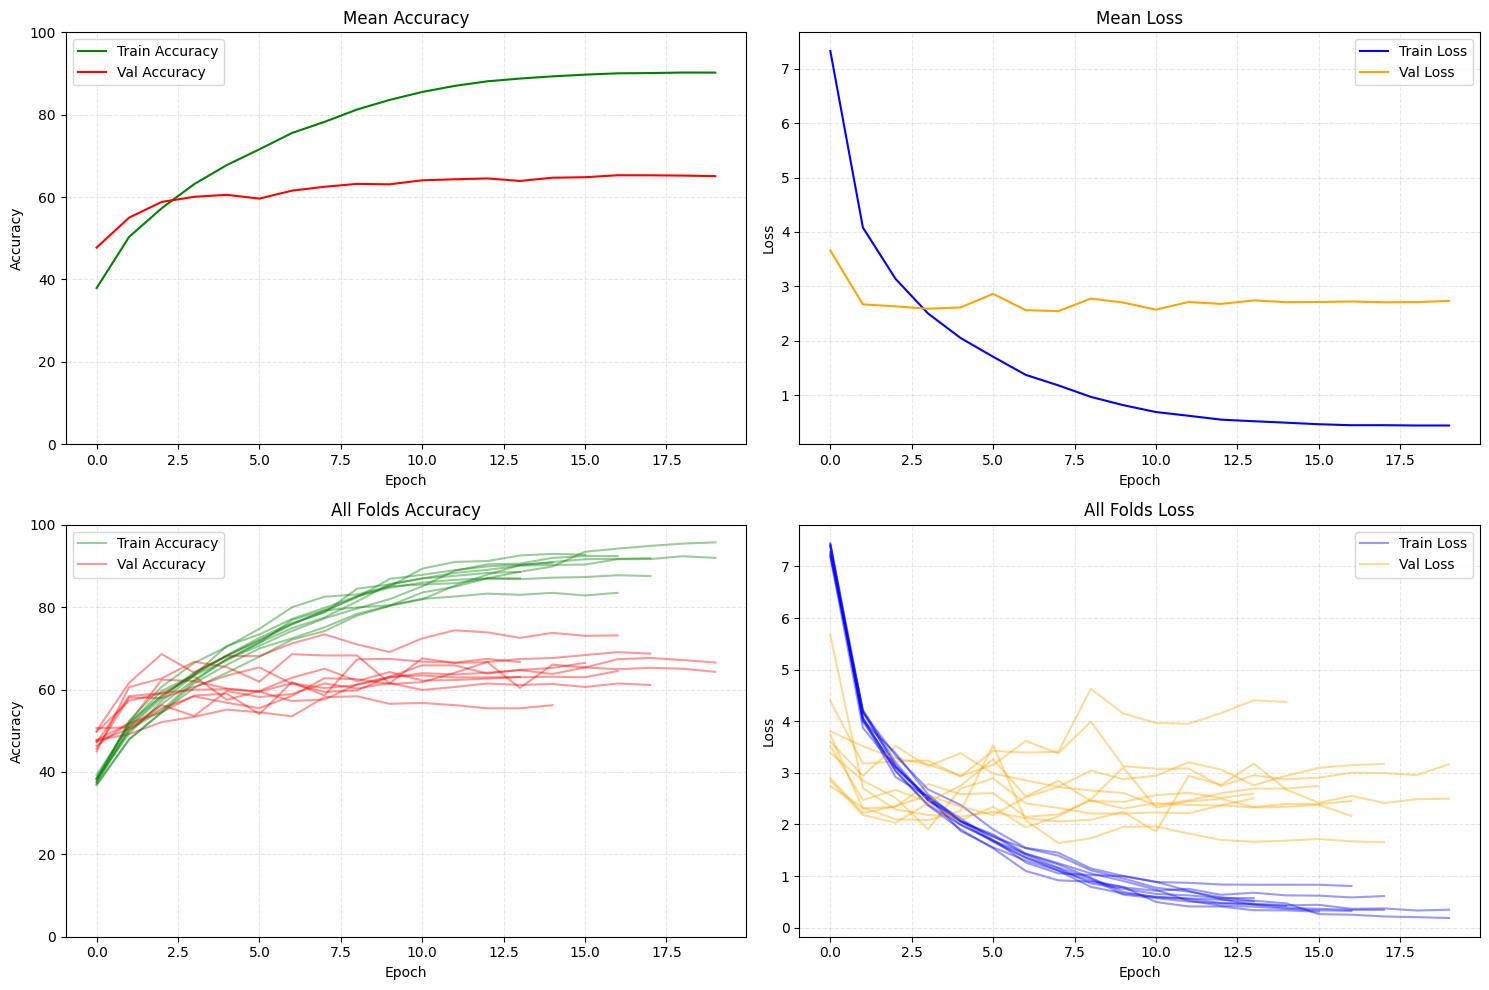

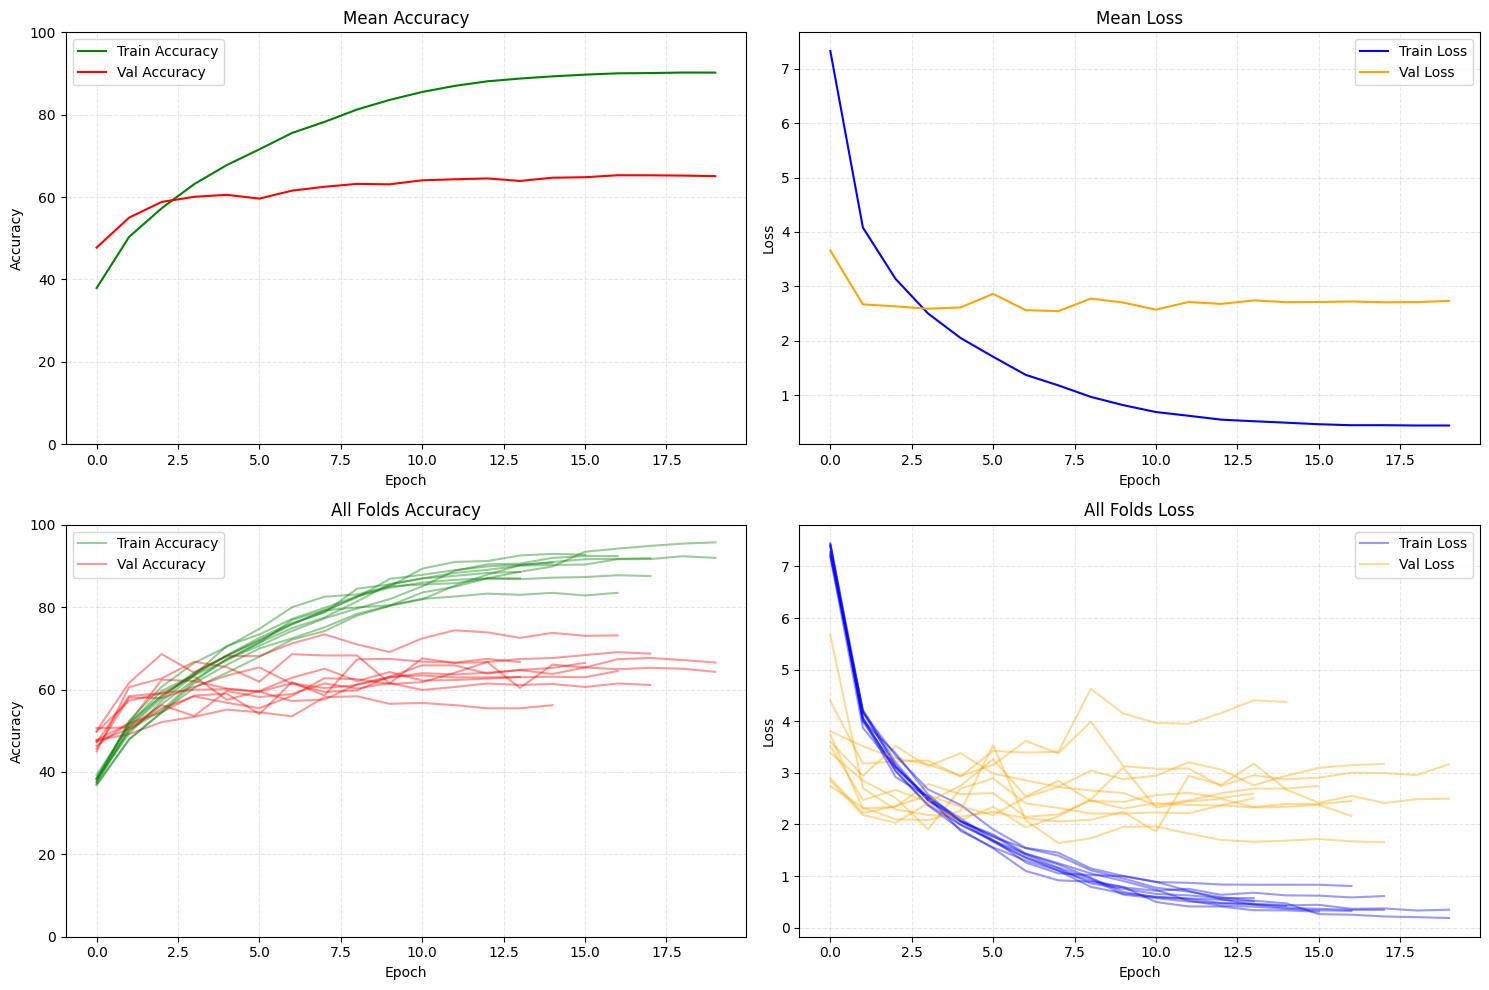

In [32]:
# for history in hann_results[1]:
#     plot_training_history(history)

plot_k_fold_histories(hann_results[1], "hann")

In [33]:
# Train with Hamming window
print("Training with Hamming window...")
hamming_results = k_fold_train_single_window(metadata_path, audio_base_path, 'hamming')
window_results['Hamming'] = hamming_results

Training with Hamming window...

Starting 10-fold cross validation for hamming window

Training on fold 1 as validation set

Preparing data for hamming window
Processing training folds: [2, 3, 4, 5, 6, 7, 8, 9, 10]


Fold 2: 0it [00:00, ?it/s]

Fold 2: 888it [00:08, 103.93it/s]
Fold 3: 925it [00:08, 102.93it/s]
Fold 4: 990it [00:10, 98.25it/s] 
Fold 5: 936it [00:09, 99.00it/s] 
Fold 6: 823it [00:08, 101.74it/s]
Fold 7: 838it [00:08, 94.77it/s] 
Fold 8: 806it [00:08, 92.96it/s] 
Fold 9: 816it [00:09, 86.74it/s] 
Fold 10: 837it [00:10, 81.36it/s] 



Processing test folds: [1]


Fold 1: 873it [00:09, 94.32it/s] 



Final shapes:
X_train: (7859, 128, 128)
X_test: (873, 128, 128)


Epoch 1/20: 100%|██████████| 246/246 [00:12<00:00, 18.98it/s]



Epoch 1/20:
Train Loss: 7.460, Train Acc: 36.00%
Val Loss: 3.137, Val Acc: 50.52%


Epoch 2/20: 100%|██████████| 246/246 [00:11<00:00, 21.76it/s]



Epoch 2/20:
Train Loss: 4.008, Train Acc: 50.55%
Val Loss: 2.982, Val Acc: 53.84%


Epoch 3/20: 100%|██████████| 246/246 [00:11<00:00, 21.34it/s]



Epoch 3/20:
Train Loss: 3.132, Train Acc: 57.55%
Val Loss: 2.480, Val Acc: 56.24%


Epoch 4/20: 100%|██████████| 246/246 [00:11<00:00, 21.57it/s]



Epoch 4/20:
Train Loss: 2.491, Train Acc: 63.19%
Val Loss: 2.560, Val Acc: 57.27%


Epoch 5/20: 100%|██████████| 246/246 [00:11<00:00, 21.82it/s]



Epoch 5/20:
Train Loss: 2.148, Train Acc: 67.21%
Val Loss: 2.431, Val Acc: 61.74%


Epoch 6/20: 100%|██████████| 246/246 [00:11<00:00, 21.77it/s]



Epoch 6/20:
Train Loss: 1.766, Train Acc: 70.93%
Val Loss: 2.721, Val Acc: 56.70%


Epoch 7/20: 100%|██████████| 246/246 [00:11<00:00, 21.65it/s]



Epoch 7/20:
Train Loss: 1.612, Train Acc: 73.62%
Val Loss: 2.424, Val Acc: 64.83%


Epoch 8/20: 100%|██████████| 246/246 [00:11<00:00, 21.66it/s]



Epoch 8/20:
Train Loss: 1.316, Train Acc: 77.27%
Val Loss: 3.178, Val Acc: 58.99%


Epoch 9/20: 100%|██████████| 246/246 [00:11<00:00, 21.58it/s]



Epoch 9/20:
Train Loss: 1.085, Train Acc: 80.39%
Val Loss: 2.450, Val Acc: 64.03%


Epoch 10/20: 100%|██████████| 246/246 [00:11<00:00, 20.90it/s]



Epoch 10/20:
Train Loss: 0.909, Train Acc: 82.42%
Val Loss: 2.211, Val Acc: 62.54%


Epoch 11/20: 100%|██████████| 246/246 [00:11<00:00, 21.09it/s]



Epoch 11/20:
Train Loss: 0.781, Train Acc: 85.14%
Val Loss: 2.744, Val Acc: 63.69%


Epoch 12/20: 100%|██████████| 246/246 [00:11<00:00, 21.12it/s]



Epoch 12/20:
Train Loss: 0.634, Train Acc: 87.25%
Val Loss: 2.716, Val Acc: 62.89%


Epoch 13/20: 100%|██████████| 246/246 [00:11<00:00, 20.58it/s]



Epoch 13/20:
Train Loss: 0.509, Train Acc: 89.25%
Val Loss: 3.724, Val Acc: 61.51%


Epoch 14/20: 100%|██████████| 246/246 [00:11<00:00, 21.24it/s]



Epoch 14/20:
Train Loss: 0.504, Train Acc: 90.13%
Val Loss: 3.074, Val Acc: 58.99%


Epoch 15/20: 100%|██████████| 246/246 [00:11<00:00, 21.16it/s]



Epoch 15/20:
Train Loss: 0.296, Train Acc: 93.13%
Val Loss: 3.048, Val Acc: 63.92%


Epoch 16/20: 100%|██████████| 246/246 [00:11<00:00, 21.34it/s]



Epoch 16/20:
Train Loss: 0.259, Train Acc: 94.10%
Val Loss: 2.778, Val Acc: 65.41%


Epoch 17/20: 100%|██████████| 246/246 [00:11<00:00, 21.08it/s]



Epoch 17/20:
Train Loss: 0.232, Train Acc: 94.53%
Val Loss: 3.032, Val Acc: 64.95%


Epoch 18/20: 100%|██████████| 246/246 [00:11<00:00, 21.24it/s]



Epoch 18/20:
Train Loss: 0.204, Train Acc: 95.81%
Val Loss: 3.042, Val Acc: 65.52%


Epoch 19/20: 100%|██████████| 246/246 [00:11<00:00, 21.09it/s]



Epoch 19/20:
Train Loss: 0.197, Train Acc: 95.74%
Val Loss: 2.846, Val Acc: 65.29%


Epoch 20/20: 100%|██████████| 246/246 [00:11<00:00, 20.71it/s]



Epoch 20/20:
Train Loss: 0.198, Train Acc: 95.98%
Val Loss: 2.753, Val Acc: 64.83%

Early stopping triggered after epoch 20

Training on fold 2 as validation set

Preparing data for hamming window
Processing training folds: [1, 3, 4, 5, 6, 7, 8, 9, 10]


Fold 1: 873it [00:09, 88.91it/s] 
Fold 3: 925it [00:09, 100.70it/s]
Fold 4: 990it [00:09, 107.80it/s]
Fold 5: 936it [00:11, 83.17it/s] 
Fold 6: 823it [00:07, 112.71it/s]
Fold 7: 838it [00:08, 97.92it/s] 
Fold 8: 806it [00:08, 96.15it/s] 
Fold 9: 816it [00:07, 103.74it/s]
Fold 10: 837it [00:08, 97.24it/s] 



Processing test folds: [2]


Fold 2: 888it [00:15, 56.54it/s]



Final shapes:
X_train: (7844, 128, 128)
X_test: (888, 128, 128)


Epoch 1/20: 100%|██████████| 246/246 [00:11<00:00, 20.62it/s]



Epoch 1/20:
Train Loss: 7.618, Train Acc: 35.29%
Val Loss: 3.021, Val Acc: 47.07%


Epoch 2/20: 100%|██████████| 246/246 [00:11<00:00, 21.62it/s]



Epoch 2/20:
Train Loss: 4.207, Train Acc: 48.71%
Val Loss: 3.138, Val Acc: 49.89%


Epoch 3/20: 100%|██████████| 246/246 [00:11<00:00, 21.68it/s]



Epoch 3/20:
Train Loss: 3.400, Train Acc: 53.49%
Val Loss: 2.168, Val Acc: 51.69%


Epoch 4/20: 100%|██████████| 246/246 [00:11<00:00, 21.73it/s]



Epoch 4/20:
Train Loss: 2.584, Train Acc: 60.49%
Val Loss: 2.364, Val Acc: 54.50%


Epoch 5/20: 100%|██████████| 246/246 [00:11<00:00, 21.74it/s]



Epoch 5/20:
Train Loss: 2.264, Train Acc: 64.30%
Val Loss: 2.646, Val Acc: 57.09%


Epoch 6/20: 100%|██████████| 246/246 [00:11<00:00, 21.60it/s]



Epoch 6/20:
Train Loss: 1.939, Train Acc: 68.59%
Val Loss: 2.919, Val Acc: 60.36%


Epoch 7/20: 100%|██████████| 246/246 [00:11<00:00, 21.29it/s]



Epoch 7/20:
Train Loss: 1.604, Train Acc: 71.51%
Val Loss: 2.360, Val Acc: 58.33%


Epoch 8/20: 100%|██████████| 246/246 [00:11<00:00, 21.34it/s]



Epoch 8/20:
Train Loss: 1.219, Train Acc: 76.24%
Val Loss: 1.869, Val Acc: 60.81%


Epoch 9/20: 100%|██████████| 246/246 [00:11<00:00, 21.19it/s]



Epoch 9/20:
Train Loss: 1.037, Train Acc: 79.12%
Val Loss: 2.128, Val Acc: 59.57%


Epoch 10/20: 100%|██████████| 246/246 [00:11<00:00, 21.23it/s]



Epoch 10/20:
Train Loss: 0.982, Train Acc: 80.34%
Val Loss: 2.260, Val Acc: 60.47%


Epoch 11/20: 100%|██████████| 246/246 [00:11<00:00, 21.36it/s]



Epoch 11/20:
Train Loss: 0.952, Train Acc: 81.14%
Val Loss: 2.228, Val Acc: 58.56%


Epoch 12/20: 100%|██████████| 246/246 [00:11<00:00, 21.18it/s]



Epoch 12/20:
Train Loss: 0.900, Train Acc: 82.16%
Val Loss: 2.345, Val Acc: 60.25%


Epoch 13/20: 100%|██████████| 246/246 [00:11<00:00, 21.11it/s]



Epoch 13/20:
Train Loss: 0.834, Train Acc: 82.29%
Val Loss: 2.408, Val Acc: 60.25%


Epoch 14/20: 100%|██████████| 246/246 [00:11<00:00, 21.02it/s]



Epoch 14/20:
Train Loss: 0.833, Train Acc: 83.30%
Val Loss: 2.183, Val Acc: 60.02%


Epoch 15/20: 100%|██████████| 246/246 [00:11<00:00, 21.07it/s]



Epoch 15/20:
Train Loss: 0.864, Train Acc: 82.51%
Val Loss: 2.528, Val Acc: 60.92%


Epoch 16/20: 100%|██████████| 246/246 [00:11<00:00, 21.18it/s]



Epoch 16/20:
Train Loss: 0.777, Train Acc: 83.24%
Val Loss: 2.411, Val Acc: 60.81%


Epoch 17/20: 100%|██████████| 246/246 [00:11<00:00, 21.29it/s]



Epoch 17/20:
Train Loss: 0.830, Train Acc: 83.47%
Val Loss: 2.176, Val Acc: 59.68%


Epoch 18/20: 100%|██████████| 246/246 [00:11<00:00, 21.22it/s]



Epoch 18/20:
Train Loss: 0.810, Train Acc: 82.87%
Val Loss: 2.443, Val Acc: 60.70%

Early stopping triggered after epoch 18

Training on fold 3 as validation set

Preparing data for hamming window
Processing training folds: [1, 2, 4, 5, 6, 7, 8, 9, 10]


Fold 1: 873it [00:09, 89.71it/s] 
Fold 2: 888it [00:07, 115.59it/s]
Fold 4: 990it [00:08, 119.24it/s]
Fold 5: 936it [00:07, 120.23it/s]
Fold 6: 823it [00:06, 119.66it/s]
Fold 7: 838it [00:07, 112.78it/s]
Fold 8: 806it [00:07, 109.73it/s]
Fold 9: 816it [00:07, 111.29it/s]
Fold 10: 837it [00:07, 113.55it/s]



Processing test folds: [3]


Fold 3: 925it [00:07, 116.05it/s]



Final shapes:
X_train: (7807, 128, 128)
X_test: (925, 128, 128)


Epoch 1/20: 100%|██████████| 244/244 [00:11<00:00, 21.23it/s]



Epoch 1/20:
Train Loss: 7.478, Train Acc: 36.67%
Val Loss: 2.833, Val Acc: 42.38%


Epoch 2/20: 100%|██████████| 244/244 [00:11<00:00, 21.47it/s]



Epoch 2/20:
Train Loss: 4.133, Train Acc: 50.08%
Val Loss: 3.011, Val Acc: 49.73%


Epoch 3/20: 100%|██████████| 244/244 [00:11<00:00, 21.50it/s]



Epoch 3/20:
Train Loss: 3.181, Train Acc: 57.09%
Val Loss: 2.958, Val Acc: 58.38%


Epoch 4/20: 100%|██████████| 244/244 [00:11<00:00, 21.58it/s]



Epoch 4/20:
Train Loss: 2.555, Train Acc: 63.08%
Val Loss: 2.700, Val Acc: 52.76%


Epoch 5/20: 100%|██████████| 244/244 [00:11<00:00, 21.46it/s]



Epoch 5/20:
Train Loss: 2.063, Train Acc: 67.71%
Val Loss: 3.004, Val Acc: 54.16%


Epoch 6/20: 100%|██████████| 244/244 [00:11<00:00, 21.16it/s]



Epoch 6/20:
Train Loss: 1.800, Train Acc: 71.44%
Val Loss: 2.595, Val Acc: 55.57%


Epoch 7/20: 100%|██████████| 244/244 [00:11<00:00, 21.01it/s]



Epoch 7/20:
Train Loss: 1.499, Train Acc: 74.54%
Val Loss: 3.811, Val Acc: 55.14%


Epoch 8/20: 100%|██████████| 244/244 [00:11<00:00, 20.79it/s]



Epoch 8/20:
Train Loss: 1.228, Train Acc: 79.04%
Val Loss: 2.981, Val Acc: 61.62%


Epoch 9/20: 100%|██████████| 244/244 [00:11<00:00, 20.83it/s]



Epoch 9/20:
Train Loss: 1.043, Train Acc: 80.70%
Val Loss: 3.789, Val Acc: 53.08%


Epoch 10/20: 100%|██████████| 244/244 [00:11<00:00, 20.82it/s]



Epoch 10/20:
Train Loss: 0.925, Train Acc: 83.41%
Val Loss: 3.286, Val Acc: 54.81%


Epoch 11/20: 100%|██████████| 244/244 [00:11<00:00, 20.80it/s]



Epoch 11/20:
Train Loss: 0.634, Train Acc: 87.66%
Val Loss: 3.581, Val Acc: 56.76%


Epoch 12/20: 100%|██████████| 244/244 [00:11<00:00, 20.70it/s]



Epoch 12/20:
Train Loss: 0.504, Train Acc: 89.79%
Val Loss: 3.518, Val Acc: 58.49%


Epoch 13/20: 100%|██████████| 244/244 [00:11<00:00, 20.62it/s]



Epoch 13/20:
Train Loss: 0.445, Train Acc: 89.98%
Val Loss: 3.422, Val Acc: 59.57%


Epoch 14/20: 100%|██████████| 244/244 [00:11<00:00, 20.63it/s]



Epoch 14/20:
Train Loss: 0.448, Train Acc: 90.96%
Val Loss: 3.560, Val Acc: 58.05%


Epoch 15/20: 100%|██████████| 244/244 [00:11<00:00, 20.46it/s]



Epoch 15/20:
Train Loss: 0.418, Train Acc: 91.37%
Val Loss: 3.566, Val Acc: 58.16%


Epoch 16/20: 100%|██████████| 244/244 [00:11<00:00, 20.57it/s]



Epoch 16/20:
Train Loss: 0.359, Train Acc: 92.10%
Val Loss: 3.515, Val Acc: 58.70%

Early stopping triggered after epoch 16

Training on fold 4 as validation set

Preparing data for hamming window
Processing training folds: [1, 2, 3, 5, 6, 7, 8, 9, 10]


Fold 1: 873it [00:08, 105.86it/s]
Fold 2: 888it [00:07, 114.85it/s]
Fold 3: 925it [00:08, 114.24it/s]
Fold 5: 936it [00:07, 120.08it/s]
Fold 6: 823it [00:06, 125.31it/s]
Fold 7: 838it [00:06, 120.58it/s]
Fold 8: 806it [00:06, 119.25it/s]
Fold 9: 816it [00:07, 114.28it/s]
Fold 10: 837it [00:07, 115.01it/s]



Processing test folds: [4]


Fold 4: 990it [00:08, 112.03it/s]



Final shapes:
X_train: (7742, 128, 128)
X_test: (990, 128, 128)


Epoch 1/20: 100%|██████████| 242/242 [00:11<00:00, 21.22it/s]



Epoch 1/20:
Train Loss: 7.218, Train Acc: 36.10%
Val Loss: 3.157, Val Acc: 48.38%


Epoch 2/20: 100%|██████████| 242/242 [00:11<00:00, 21.63it/s]



Epoch 2/20:
Train Loss: 4.150, Train Acc: 48.64%
Val Loss: 4.325, Val Acc: 47.37%


Epoch 3/20: 100%|██████████| 242/242 [00:11<00:00, 21.58it/s]



Epoch 3/20:
Train Loss: 3.392, Train Acc: 54.11%
Val Loss: 3.304, Val Acc: 53.13%


Epoch 4/20: 100%|██████████| 242/242 [00:11<00:00, 21.30it/s]



Epoch 4/20:
Train Loss: 2.684, Train Acc: 60.44%
Val Loss: 2.127, Val Acc: 62.02%


Epoch 5/20: 100%|██████████| 242/242 [00:11<00:00, 21.33it/s]



Epoch 5/20:
Train Loss: 2.204, Train Acc: 65.11%
Val Loss: 2.445, Val Acc: 64.34%


Epoch 6/20: 100%|██████████| 242/242 [00:11<00:00, 21.13it/s]



Epoch 6/20:
Train Loss: 1.871, Train Acc: 69.40%
Val Loss: 2.162, Val Acc: 63.74%


Epoch 7/20: 100%|██████████| 242/242 [00:11<00:00, 21.09it/s]



Epoch 7/20:
Train Loss: 1.516, Train Acc: 72.97%
Val Loss: 2.802, Val Acc: 57.88%


Epoch 8/20: 100%|██████████| 242/242 [00:11<00:00, 20.97it/s]



Epoch 8/20:
Train Loss: 1.288, Train Acc: 75.54%
Val Loss: 2.561, Val Acc: 57.58%


Epoch 9/20: 100%|██████████| 242/242 [00:11<00:00, 20.92it/s]



Epoch 9/20:
Train Loss: 0.940, Train Acc: 80.79%
Val Loss: 2.378, Val Acc: 67.47%


Epoch 10/20: 100%|██████████| 242/242 [00:11<00:00, 20.66it/s]



Epoch 10/20:
Train Loss: 0.839, Train Acc: 81.66%
Val Loss: 2.269, Val Acc: 66.16%


Epoch 11/20: 100%|██████████| 242/242 [00:11<00:00, 20.82it/s]



Epoch 11/20:
Train Loss: 0.751, Train Acc: 83.30%
Val Loss: 2.213, Val Acc: 65.96%


Epoch 12/20: 100%|██████████| 242/242 [00:11<00:00, 20.80it/s]



Epoch 12/20:
Train Loss: 0.729, Train Acc: 84.07%
Val Loss: 2.275, Val Acc: 66.87%


Epoch 13/20: 100%|██████████| 242/242 [00:11<00:00, 20.81it/s]



Epoch 13/20:
Train Loss: 0.686, Train Acc: 84.97%
Val Loss: 2.224, Val Acc: 66.36%


Epoch 14/20: 100%|██████████| 242/242 [00:11<00:00, 20.30it/s]



Epoch 14/20:
Train Loss: 0.676, Train Acc: 85.31%
Val Loss: 2.381, Val Acc: 66.67%

Early stopping triggered after epoch 14

Training on fold 5 as validation set

Preparing data for hamming window
Processing training folds: [1, 2, 3, 4, 6, 7, 8, 9, 10]


Fold 1: 873it [00:08, 104.16it/s]
Fold 2: 888it [00:07, 116.46it/s]
Fold 3: 925it [00:07, 119.31it/s]
Fold 4: 990it [00:08, 112.21it/s]
Fold 6: 823it [00:06, 119.18it/s]
Fold 7: 838it [00:07, 116.00it/s]
Fold 8: 806it [00:06, 116.80it/s]
Fold 9: 816it [00:08, 101.99it/s]
Fold 10: 837it [00:07, 109.74it/s]



Processing test folds: [5]


Fold 5: 936it [00:08, 108.48it/s]



Final shapes:
X_train: (7796, 128, 128)
X_test: (936, 128, 128)


Epoch 1/20: 100%|██████████| 244/244 [00:11<00:00, 21.25it/s]



Epoch 1/20:
Train Loss: 7.406, Train Acc: 36.93%
Val Loss: 5.003, Val Acc: 46.69%


Epoch 2/20: 100%|██████████| 244/244 [00:11<00:00, 21.63it/s]



Epoch 2/20:
Train Loss: 4.227, Train Acc: 47.93%
Val Loss: 3.952, Val Acc: 43.06%


Epoch 3/20: 100%|██████████| 244/244 [00:11<00:00, 21.62it/s]



Epoch 3/20:
Train Loss: 3.459, Train Acc: 53.36%
Val Loss: 2.776, Val Acc: 54.81%


Epoch 4/20: 100%|██████████| 244/244 [00:11<00:00, 21.52it/s]



Epoch 4/20:
Train Loss: 2.923, Train Acc: 58.62%
Val Loss: 2.882, Val Acc: 58.23%


Epoch 5/20: 100%|██████████| 244/244 [00:11<00:00, 21.24it/s]



Epoch 5/20:
Train Loss: 2.382, Train Acc: 63.93%
Val Loss: 2.915, Val Acc: 57.69%


Epoch 6/20: 100%|██████████| 244/244 [00:11<00:00, 21.21it/s]



Epoch 6/20:
Train Loss: 2.013, Train Acc: 67.61%
Val Loss: 2.876, Val Acc: 59.94%


Epoch 7/20: 100%|██████████| 244/244 [00:11<00:00, 20.93it/s]



Epoch 7/20:
Train Loss: 1.693, Train Acc: 71.24%
Val Loss: 2.631, Val Acc: 62.39%


Epoch 8/20: 100%|██████████| 244/244 [00:11<00:00, 20.88it/s]



Epoch 8/20:
Train Loss: 1.389, Train Acc: 75.03%
Val Loss: 2.775, Val Acc: 58.55%


Epoch 9/20: 100%|██████████| 244/244 [00:11<00:00, 20.58it/s]



Epoch 9/20:
Train Loss: 1.344, Train Acc: 76.76%
Val Loss: 4.148, Val Acc: 61.75%


Epoch 10/20: 100%|██████████| 244/244 [00:11<00:00, 20.63it/s]



Epoch 10/20:
Train Loss: 1.043, Train Acc: 79.69%
Val Loss: 2.616, Val Acc: 64.21%


Epoch 11/20: 100%|██████████| 244/244 [00:11<00:00, 20.54it/s]



Epoch 11/20:
Train Loss: 0.930, Train Acc: 82.48%
Val Loss: 3.365, Val Acc: 63.89%


Epoch 12/20: 100%|██████████| 244/244 [00:11<00:00, 20.75it/s]



Epoch 12/20:
Train Loss: 0.821, Train Acc: 83.88%
Val Loss: 2.811, Val Acc: 61.00%


Epoch 13/20: 100%|██████████| 244/244 [00:11<00:00, 20.69it/s]



Epoch 13/20:
Train Loss: 0.671, Train Acc: 85.70%
Val Loss: 3.709, Val Acc: 62.29%


Epoch 14/20: 100%|██████████| 244/244 [00:11<00:00, 20.62it/s]



Epoch 14/20:
Train Loss: 0.544, Train Acc: 88.49%
Val Loss: 2.915, Val Acc: 63.68%


Epoch 15/20: 100%|██████████| 244/244 [00:11<00:00, 20.50it/s]



Epoch 15/20:
Train Loss: 0.430, Train Acc: 90.78%
Val Loss: 3.187, Val Acc: 65.92%


Epoch 16/20: 100%|██████████| 244/244 [00:11<00:00, 20.57it/s]



Epoch 16/20:
Train Loss: 0.362, Train Acc: 92.20%
Val Loss: 3.261, Val Acc: 64.96%


Epoch 17/20: 100%|██████████| 244/244 [00:11<00:00, 20.59it/s]



Epoch 17/20:
Train Loss: 0.298, Train Acc: 93.51%
Val Loss: 3.356, Val Acc: 64.53%


Epoch 18/20: 100%|██████████| 244/244 [00:11<00:00, 20.62it/s]



Epoch 18/20:
Train Loss: 0.323, Train Acc: 93.01%
Val Loss: 3.246, Val Acc: 64.53%


Epoch 19/20: 100%|██████████| 244/244 [00:11<00:00, 20.59it/s]



Epoch 19/20:
Train Loss: 0.278, Train Acc: 94.25%
Val Loss: 3.231, Val Acc: 65.06%


Epoch 20/20: 100%|██████████| 244/244 [00:11<00:00, 20.59it/s]



Epoch 20/20:
Train Loss: 0.263, Train Acc: 94.24%
Val Loss: 3.338, Val Acc: 65.49%

Early stopping triggered after epoch 20

Training on fold 6 as validation set

Preparing data for hamming window
Processing training folds: [1, 2, 3, 4, 5, 7, 8, 9, 10]


Fold 1: 873it [00:08, 98.79it/s] 
Fold 2: 888it [00:07, 112.80it/s]
Fold 3: 925it [00:07, 119.92it/s]
Fold 4: 990it [00:08, 110.09it/s]
Fold 5: 936it [00:08, 109.78it/s]
Fold 7: 838it [00:07, 116.13it/s]
Fold 8: 806it [00:07, 114.34it/s]
Fold 9: 816it [00:07, 113.31it/s]
Fold 10: 837it [00:07, 109.83it/s]



Processing test folds: [6]


Fold 6: 823it [00:07, 115.98it/s]



Final shapes:
X_train: (7909, 128, 128)
X_test: (823, 128, 128)


Epoch 1/20: 100%|██████████| 248/248 [00:11<00:00, 21.17it/s]



Epoch 1/20:
Train Loss: 7.359, Train Acc: 37.45%
Val Loss: 2.974, Val Acc: 48.85%


Epoch 2/20: 100%|██████████| 248/248 [00:11<00:00, 21.59it/s]



Epoch 2/20:
Train Loss: 3.979, Train Acc: 50.36%
Val Loss: 3.171, Val Acc: 54.80%


Epoch 3/20: 100%|██████████| 248/248 [00:11<00:00, 21.50it/s]



Epoch 3/20:
Train Loss: 3.116, Train Acc: 57.20%
Val Loss: 2.393, Val Acc: 55.89%


Epoch 4/20: 100%|██████████| 248/248 [00:11<00:00, 21.42it/s]



Epoch 4/20:
Train Loss: 2.617, Train Acc: 62.50%
Val Loss: 2.932, Val Acc: 56.01%


Epoch 5/20: 100%|██████████| 248/248 [00:11<00:00, 21.10it/s]



Epoch 5/20:
Train Loss: 2.022, Train Acc: 68.29%
Val Loss: 3.160, Val Acc: 52.49%


Epoch 6/20: 100%|██████████| 248/248 [00:11<00:00, 21.01it/s]



Epoch 6/20:
Train Loss: 1.795, Train Acc: 71.67%
Val Loss: 2.839, Val Acc: 58.20%


Epoch 7/20: 100%|██████████| 248/248 [00:11<00:00, 20.99it/s]



Epoch 7/20:
Train Loss: 1.497, Train Acc: 75.21%
Val Loss: 3.087, Val Acc: 55.41%


Epoch 8/20: 100%|██████████| 248/248 [00:11<00:00, 20.93it/s]



Epoch 8/20:
Train Loss: 1.089, Train Acc: 79.35%
Val Loss: 2.947, Val Acc: 59.05%


Epoch 9/20: 100%|██████████| 248/248 [00:11<00:00, 20.86it/s]



Epoch 9/20:
Train Loss: 0.984, Train Acc: 81.36%
Val Loss: 3.150, Val Acc: 59.78%


Epoch 10/20: 100%|██████████| 248/248 [00:12<00:00, 20.60it/s]



Epoch 10/20:
Train Loss: 0.839, Train Acc: 82.77%
Val Loss: 2.866, Val Acc: 61.36%


Epoch 11/20: 100%|██████████| 248/248 [00:11<00:00, 20.74it/s]



Epoch 11/20:
Train Loss: 0.844, Train Acc: 83.17%
Val Loss: 3.047, Val Acc: 61.00%


Epoch 12/20: 100%|██████████| 248/248 [00:11<00:00, 20.70it/s]



Epoch 12/20:
Train Loss: 0.742, Train Acc: 85.30%
Val Loss: 2.999, Val Acc: 61.60%


Epoch 13/20: 100%|██████████| 248/248 [00:11<00:00, 20.74it/s]



Epoch 13/20:
Train Loss: 0.729, Train Acc: 85.03%
Val Loss: 3.157, Val Acc: 61.12%

Early stopping triggered after epoch 13

Training on fold 7 as validation set

Preparing data for hamming window
Processing training folds: [1, 2, 3, 4, 5, 6, 8, 9, 10]


Fold 1: 873it [00:08, 106.55it/s]
Fold 2: 888it [00:07, 111.22it/s]
Fold 3: 925it [00:08, 114.05it/s]
Fold 4: 990it [00:12, 76.81it/s] 
Fold 5: 936it [00:10, 89.39it/s] 
Fold 6: 823it [00:09, 83.38it/s] 
Fold 8: 806it [00:14, 54.42it/s] 
Fold 9: 816it [00:09, 85.09it/s] 
Fold 10: 837it [00:08, 104.09it/s]



Processing test folds: [7]


Fold 7: 838it [00:07, 107.71it/s]



Final shapes:
X_train: (7894, 128, 128)
X_test: (838, 128, 128)


Epoch 1/20: 100%|██████████| 247/247 [00:11<00:00, 20.93it/s]



Epoch 1/20:
Train Loss: 7.371, Train Acc: 36.85%
Val Loss: 3.102, Val Acc: 45.47%


Epoch 2/20: 100%|██████████| 247/247 [00:11<00:00, 21.68it/s]



Epoch 2/20:
Train Loss: 4.200, Train Acc: 48.83%
Val Loss: 2.570, Val Acc: 52.63%


Epoch 3/20: 100%|██████████| 247/247 [00:11<00:00, 21.63it/s]



Epoch 3/20:
Train Loss: 3.180, Train Acc: 56.07%
Val Loss: 1.831, Val Acc: 58.00%


Epoch 4/20: 100%|██████████| 247/247 [00:11<00:00, 21.45it/s]



Epoch 4/20:
Train Loss: 2.685, Train Acc: 61.50%
Val Loss: 2.631, Val Acc: 57.64%


Epoch 5/20: 100%|██████████| 247/247 [00:11<00:00, 21.39it/s]



Epoch 5/20:
Train Loss: 2.187, Train Acc: 66.82%
Val Loss: 1.927, Val Acc: 59.19%


Epoch 6/20: 100%|██████████| 247/247 [00:11<00:00, 21.20it/s]



Epoch 6/20:
Train Loss: 1.889, Train Acc: 69.91%
Val Loss: 2.244, Val Acc: 54.53%


Epoch 7/20: 100%|██████████| 247/247 [00:11<00:00, 21.09it/s]



Epoch 7/20:
Train Loss: 1.560, Train Acc: 73.33%
Val Loss: 2.216, Val Acc: 52.03%


Epoch 8/20: 100%|██████████| 247/247 [00:11<00:00, 20.73it/s]



Epoch 8/20:
Train Loss: 1.135, Train Acc: 78.91%
Val Loss: 1.956, Val Acc: 58.71%


Epoch 9/20: 100%|██████████| 247/247 [00:11<00:00, 20.84it/s]



Epoch 9/20:
Train Loss: 0.991, Train Acc: 80.76%
Val Loss: 1.945, Val Acc: 55.97%


Epoch 10/20: 100%|██████████| 247/247 [00:11<00:00, 20.88it/s]



Epoch 10/20:
Train Loss: 0.938, Train Acc: 81.53%
Val Loss: 2.102, Val Acc: 61.10%


Epoch 11/20: 100%|██████████| 247/247 [00:11<00:00, 20.78it/s]



Epoch 11/20:
Train Loss: 0.920, Train Acc: 82.38%
Val Loss: 2.087, Val Acc: 60.02%


Epoch 12/20: 100%|██████████| 247/247 [00:11<00:00, 20.58it/s]



Epoch 12/20:
Train Loss: 0.825, Train Acc: 84.00%
Val Loss: 2.108, Val Acc: 60.86%


Epoch 13/20: 100%|██████████| 247/247 [00:12<00:00, 20.03it/s]



Epoch 13/20:
Train Loss: 0.774, Train Acc: 84.58%
Val Loss: 1.990, Val Acc: 61.34%

Early stopping triggered after epoch 13

Training on fold 8 as validation set

Preparing data for hamming window
Processing training folds: [1, 2, 3, 4, 5, 6, 7, 9, 10]


Fold 1: 873it [00:17, 49.24it/s]
Fold 2: 888it [00:13, 67.74it/s]
Fold 3: 925it [00:12, 73.66it/s]
Fold 4: 990it [00:08, 113.01it/s]
Fold 5: 936it [00:07, 117.37it/s]
Fold 6: 823it [00:06, 120.04it/s]
Fold 7: 838it [00:07, 109.64it/s]
Fold 9: 816it [00:07, 109.80it/s]
Fold 10: 837it [00:07, 111.30it/s]



Processing test folds: [8]


Fold 8: 806it [00:07, 102.13it/s]



Final shapes:
X_train: (7926, 128, 128)
X_test: (806, 128, 128)


Epoch 1/20: 100%|██████████| 248/248 [00:11<00:00, 21.32it/s]



Epoch 1/20:
Train Loss: 7.572, Train Acc: 37.59%
Val Loss: 2.982, Val Acc: 49.75%


Epoch 2/20: 100%|██████████| 248/248 [00:11<00:00, 21.67it/s]



Epoch 2/20:
Train Loss: 4.070, Train Acc: 51.49%
Val Loss: 2.388, Val Acc: 57.94%


Epoch 3/20: 100%|██████████| 248/248 [00:11<00:00, 21.66it/s]



Epoch 3/20:
Train Loss: 3.056, Train Acc: 58.97%
Val Loss: 2.427, Val Acc: 63.28%


Epoch 4/20: 100%|██████████| 248/248 [00:11<00:00, 21.61it/s]



Epoch 4/20:
Train Loss: 2.382, Train Acc: 65.09%
Val Loss: 2.570, Val Acc: 64.14%


Epoch 5/20: 100%|██████████| 248/248 [00:11<00:00, 21.40it/s]



Epoch 5/20:
Train Loss: 1.979, Train Acc: 69.51%
Val Loss: 2.065, Val Acc: 58.81%


Epoch 6/20: 100%|██████████| 248/248 [00:11<00:00, 21.15it/s]



Epoch 6/20:
Train Loss: 1.609, Train Acc: 73.62%
Val Loss: 2.465, Val Acc: 62.78%


Epoch 7/20: 100%|██████████| 248/248 [00:11<00:00, 21.07it/s]



Epoch 7/20:
Train Loss: 1.376, Train Acc: 76.57%
Val Loss: 2.266, Val Acc: 64.52%


Epoch 8/20: 100%|██████████| 248/248 [00:11<00:00, 20.89it/s]



Epoch 8/20:
Train Loss: 1.187, Train Acc: 78.36%
Val Loss: 2.864, Val Acc: 63.15%


Epoch 9/20: 100%|██████████| 248/248 [00:11<00:00, 20.93it/s]



Epoch 9/20:
Train Loss: 0.960, Train Acc: 81.58%
Val Loss: 2.507, Val Acc: 57.69%


Epoch 10/20: 100%|██████████| 248/248 [00:11<00:00, 20.73it/s]



Epoch 10/20:
Train Loss: 0.640, Train Acc: 86.93%
Val Loss: 2.273, Val Acc: 64.64%


Epoch 11/20: 100%|██████████| 248/248 [00:11<00:00, 20.83it/s]



Epoch 11/20:
Train Loss: 0.539, Train Acc: 88.37%
Val Loss: 2.425, Val Acc: 61.91%


Epoch 12/20: 100%|██████████| 248/248 [00:11<00:00, 20.78it/s]



Epoch 12/20:
Train Loss: 0.508, Train Acc: 89.10%
Val Loss: 2.376, Val Acc: 62.90%


Epoch 13/20: 100%|██████████| 248/248 [00:11<00:00, 20.74it/s]



Epoch 13/20:
Train Loss: 0.452, Train Acc: 89.79%
Val Loss: 2.414, Val Acc: 62.16%


Epoch 14/20: 100%|██████████| 248/248 [00:11<00:00, 20.88it/s]



Epoch 14/20:
Train Loss: 0.444, Train Acc: 90.31%
Val Loss: 2.448, Val Acc: 61.54%


Epoch 15/20: 100%|██████████| 248/248 [00:11<00:00, 20.84it/s]



Epoch 15/20:
Train Loss: 0.450, Train Acc: 90.40%
Val Loss: 2.336, Val Acc: 61.29%

Early stopping triggered after epoch 15

Training on fold 9 as validation set

Preparing data for hamming window
Processing training folds: [1, 2, 3, 4, 5, 6, 7, 8, 10]


Fold 1: 873it [00:07, 110.11it/s]
Fold 2: 888it [00:07, 112.49it/s]
Fold 3: 925it [00:08, 109.00it/s]
Fold 4: 990it [00:09, 108.43it/s]
Fold 5: 936it [00:08, 106.43it/s]
Fold 6: 823it [00:06, 118.03it/s]
Fold 7: 838it [00:07, 105.90it/s]
Fold 8: 806it [00:08, 100.68it/s]
Fold 10: 837it [00:08, 101.39it/s]



Processing test folds: [9]


Fold 9: 816it [00:07, 103.14it/s]



Final shapes:
X_train: (7916, 128, 128)
X_test: (816, 128, 128)


Epoch 1/20: 100%|██████████| 248/248 [00:11<00:00, 21.18it/s]



Epoch 1/20:
Train Loss: 7.841, Train Acc: 36.19%
Val Loss: 2.790, Val Acc: 52.70%


Epoch 2/20: 100%|██████████| 248/248 [00:11<00:00, 21.58it/s]



Epoch 2/20:
Train Loss: 4.199, Train Acc: 48.32%
Val Loss: 2.360, Val Acc: 56.86%


Epoch 3/20: 100%|██████████| 248/248 [00:11<00:00, 21.47it/s]



Epoch 3/20:
Train Loss: 3.213, Train Acc: 55.96%
Val Loss: 2.287, Val Acc: 60.66%


Epoch 4/20: 100%|██████████| 248/248 [00:11<00:00, 21.22it/s]



Epoch 4/20:
Train Loss: 2.691, Train Acc: 60.22%
Val Loss: 2.522, Val Acc: 62.50%


Epoch 5/20: 100%|██████████| 248/248 [00:11<00:00, 21.11it/s]



Epoch 5/20:
Train Loss: 2.161, Train Acc: 66.33%
Val Loss: 2.797, Val Acc: 64.09%


Epoch 6/20: 100%|██████████| 248/248 [00:11<00:00, 21.11it/s]



Epoch 6/20:
Train Loss: 1.814, Train Acc: 70.07%
Val Loss: 2.161, Val Acc: 68.50%


Epoch 7/20: 100%|██████████| 248/248 [00:11<00:00, 20.96it/s]



Epoch 7/20:
Train Loss: 1.444, Train Acc: 74.17%
Val Loss: 2.213, Val Acc: 71.57%


Epoch 8/20: 100%|██████████| 248/248 [00:11<00:00, 20.89it/s]



Epoch 8/20:
Train Loss: 1.192, Train Acc: 77.73%
Val Loss: 1.957, Val Acc: 71.45%


Epoch 9/20: 100%|██████████| 248/248 [00:12<00:00, 20.36it/s]



Epoch 9/20:
Train Loss: 1.049, Train Acc: 79.71%
Val Loss: 2.223, Val Acc: 70.71%


Epoch 10/20: 100%|██████████| 248/248 [00:12<00:00, 20.32it/s]



Epoch 10/20:
Train Loss: 0.882, Train Acc: 82.59%
Val Loss: 2.209, Val Acc: 70.71%


Epoch 11/20: 100%|██████████| 248/248 [00:12<00:00, 20.28it/s]



Epoch 11/20:
Train Loss: 0.755, Train Acc: 84.66%
Val Loss: 2.154, Val Acc: 71.32%


Epoch 12/20: 100%|██████████| 248/248 [00:12<00:00, 20.63it/s]



Epoch 12/20:
Train Loss: 0.657, Train Acc: 86.31%
Val Loss: 2.103, Val Acc: 73.77%


Epoch 13/20: 100%|██████████| 248/248 [00:12<00:00, 20.47it/s]



Epoch 13/20:
Train Loss: 0.471, Train Acc: 89.49%
Val Loss: 2.206, Val Acc: 72.43%


Epoch 14/20: 100%|██████████| 248/248 [00:12<00:00, 20.53it/s]



Epoch 14/20:
Train Loss: 0.377, Train Acc: 91.66%
Val Loss: 2.241, Val Acc: 70.71%


Epoch 15/20: 100%|██████████| 248/248 [00:12<00:00, 20.26it/s]



Epoch 15/20:
Train Loss: 0.371, Train Acc: 91.70%
Val Loss: 2.174, Val Acc: 71.69%


Epoch 16/20: 100%|██████████| 248/248 [00:12<00:00, 20.56it/s]



Epoch 16/20:
Train Loss: 0.322, Train Acc: 92.55%
Val Loss: 2.399, Val Acc: 70.34%


Epoch 17/20: 100%|██████████| 248/248 [00:11<00:00, 20.69it/s]



Epoch 17/20:
Train Loss: 0.308, Train Acc: 93.25%
Val Loss: 2.203, Val Acc: 71.94%


Epoch 18/20: 100%|██████████| 248/248 [00:11<00:00, 21.04it/s]



Epoch 18/20:
Train Loss: 0.295, Train Acc: 93.42%
Val Loss: 2.176, Val Acc: 71.81%

Early stopping triggered after epoch 18

Training on fold 10 as validation set

Preparing data for hamming window
Processing training folds: [1, 2, 3, 4, 5, 6, 7, 8, 9]


Fold 1: 873it [00:08, 106.20it/s]
Fold 2: 888it [00:07, 119.50it/s]
Fold 3: 925it [00:07, 116.36it/s]
Fold 4: 990it [00:08, 120.56it/s]
Fold 5: 936it [00:07, 123.24it/s]
Fold 6: 823it [00:06, 124.36it/s]
Fold 7: 838it [00:07, 107.64it/s]
Fold 8: 806it [00:08, 100.50it/s]
Fold 9: 816it [00:07, 105.70it/s]



Processing test folds: [10]


Fold 10: 837it [00:11, 72.78it/s] 



Final shapes:
X_train: (7895, 128, 128)
X_test: (837, 128, 128)


Epoch 1/20: 100%|██████████| 247/247 [00:11<00:00, 20.69it/s]



Epoch 1/20:
Train Loss: 7.215, Train Acc: 38.04%
Val Loss: 3.374, Val Acc: 50.06%


Epoch 2/20: 100%|██████████| 247/247 [00:11<00:00, 21.38it/s]



Epoch 2/20:
Train Loss: 4.013, Train Acc: 51.26%
Val Loss: 2.788, Val Acc: 59.14%


Epoch 3/20: 100%|██████████| 247/247 [00:11<00:00, 21.43it/s]



Epoch 3/20:
Train Loss: 3.142, Train Acc: 57.75%
Val Loss: 3.209, Val Acc: 58.30%


Epoch 4/20: 100%|██████████| 247/247 [00:11<00:00, 21.34it/s]



Epoch 4/20:
Train Loss: 2.484, Train Acc: 63.75%
Val Loss: 3.455, Val Acc: 59.74%


Epoch 5/20: 100%|██████████| 247/247 [00:11<00:00, 20.75it/s]



Epoch 5/20:
Train Loss: 1.963, Train Acc: 68.89%
Val Loss: 2.419, Val Acc: 58.54%


Epoch 6/20: 100%|██████████| 247/247 [00:11<00:00, 20.88it/s]



Epoch 6/20:
Train Loss: 1.673, Train Acc: 72.37%
Val Loss: 3.257, Val Acc: 60.22%


Epoch 7/20: 100%|██████████| 247/247 [00:11<00:00, 21.00it/s]



Epoch 7/20:
Train Loss: 1.313, Train Acc: 76.10%
Val Loss: 2.476, Val Acc: 59.98%


Epoch 8/20: 100%|██████████| 247/247 [00:11<00:00, 21.04it/s]



Epoch 8/20:
Train Loss: 1.086, Train Acc: 79.05%
Val Loss: 2.663, Val Acc: 61.05%


Epoch 9/20: 100%|██████████| 247/247 [00:11<00:00, 20.97it/s]



Epoch 9/20:
Train Loss: 0.934, Train Acc: 81.71%
Val Loss: 2.754, Val Acc: 60.10%


Epoch 10/20: 100%|██████████| 247/247 [00:11<00:00, 20.73it/s]



Epoch 10/20:
Train Loss: 0.649, Train Acc: 86.14%
Val Loss: 2.613, Val Acc: 65.35%


Epoch 11/20: 100%|██████████| 247/247 [00:11<00:00, 20.79it/s]



Epoch 11/20:
Train Loss: 0.541, Train Acc: 88.39%
Val Loss: 2.583, Val Acc: 66.07%


Epoch 12/20: 100%|██████████| 247/247 [00:11<00:00, 20.69it/s]



Epoch 12/20:
Train Loss: 0.484, Train Acc: 88.90%
Val Loss: 2.555, Val Acc: 65.35%


Epoch 13/20: 100%|██████████| 247/247 [00:12<00:00, 20.51it/s]



Epoch 13/20:
Train Loss: 0.453, Train Acc: 89.63%
Val Loss: 2.630, Val Acc: 65.95%


Epoch 14/20: 100%|██████████| 247/247 [00:12<00:00, 20.49it/s]



Epoch 14/20:
Train Loss: 0.411, Train Acc: 90.40%
Val Loss: 2.670, Val Acc: 64.99%


Epoch 15/20: 100%|██████████| 247/247 [00:11<00:00, 20.77it/s]



Epoch 15/20:
Train Loss: 0.392, Train Acc: 90.68%
Val Loss: 2.808, Val Acc: 66.07%

Early stopping triggered after epoch 15

Cross-validation results for hamming window:
Average validation accuracy: 63.80% ± 3.70%


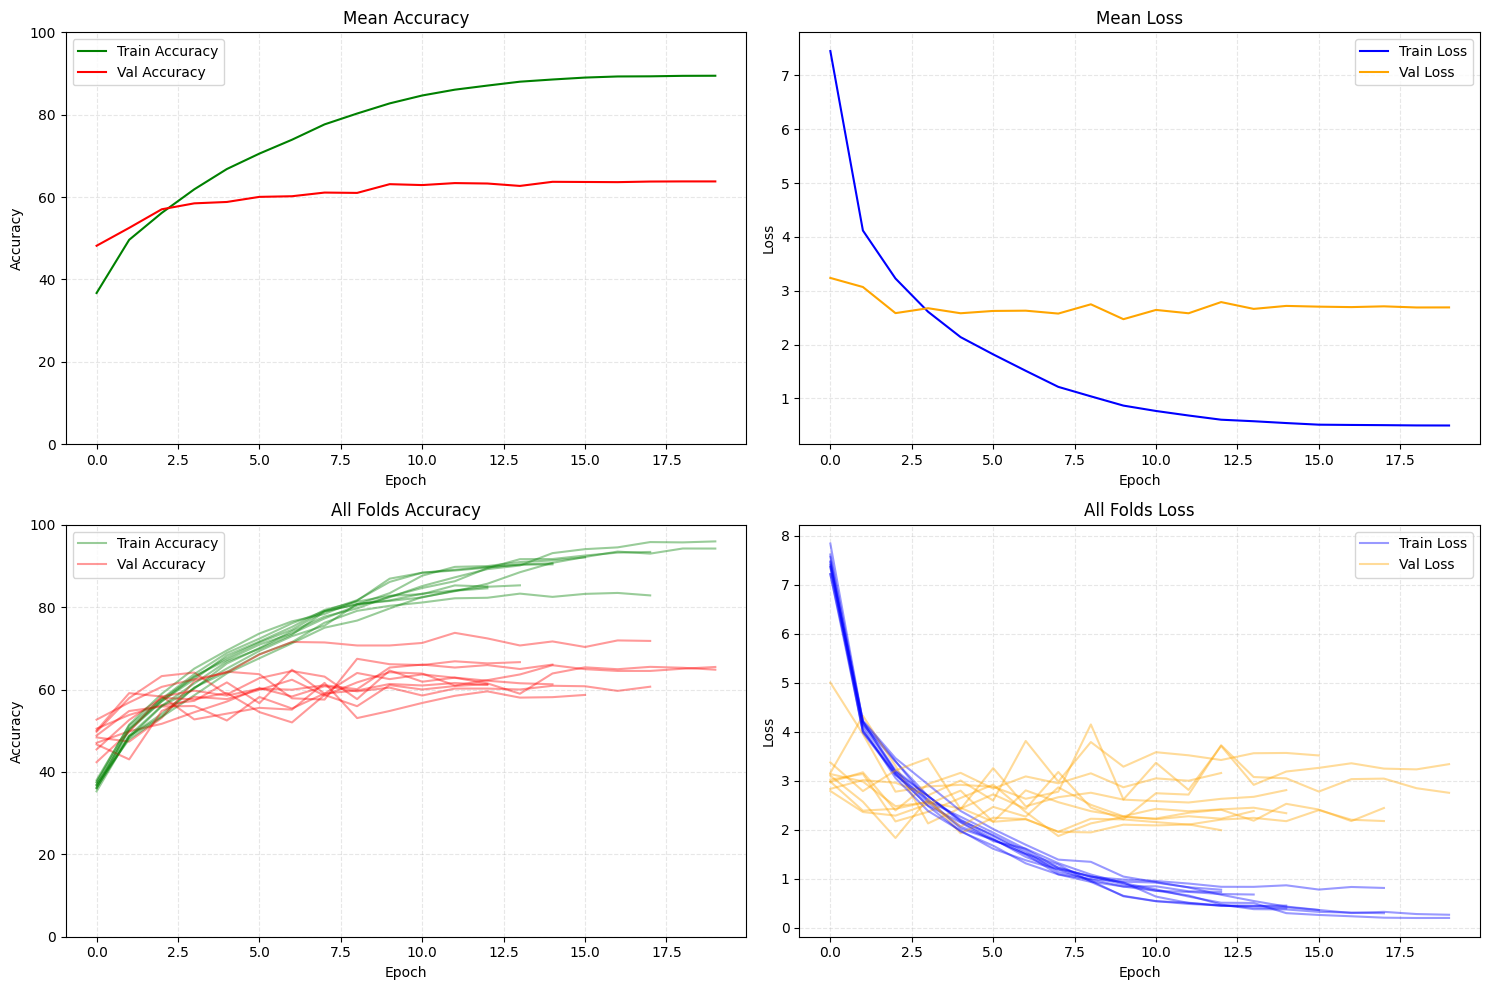

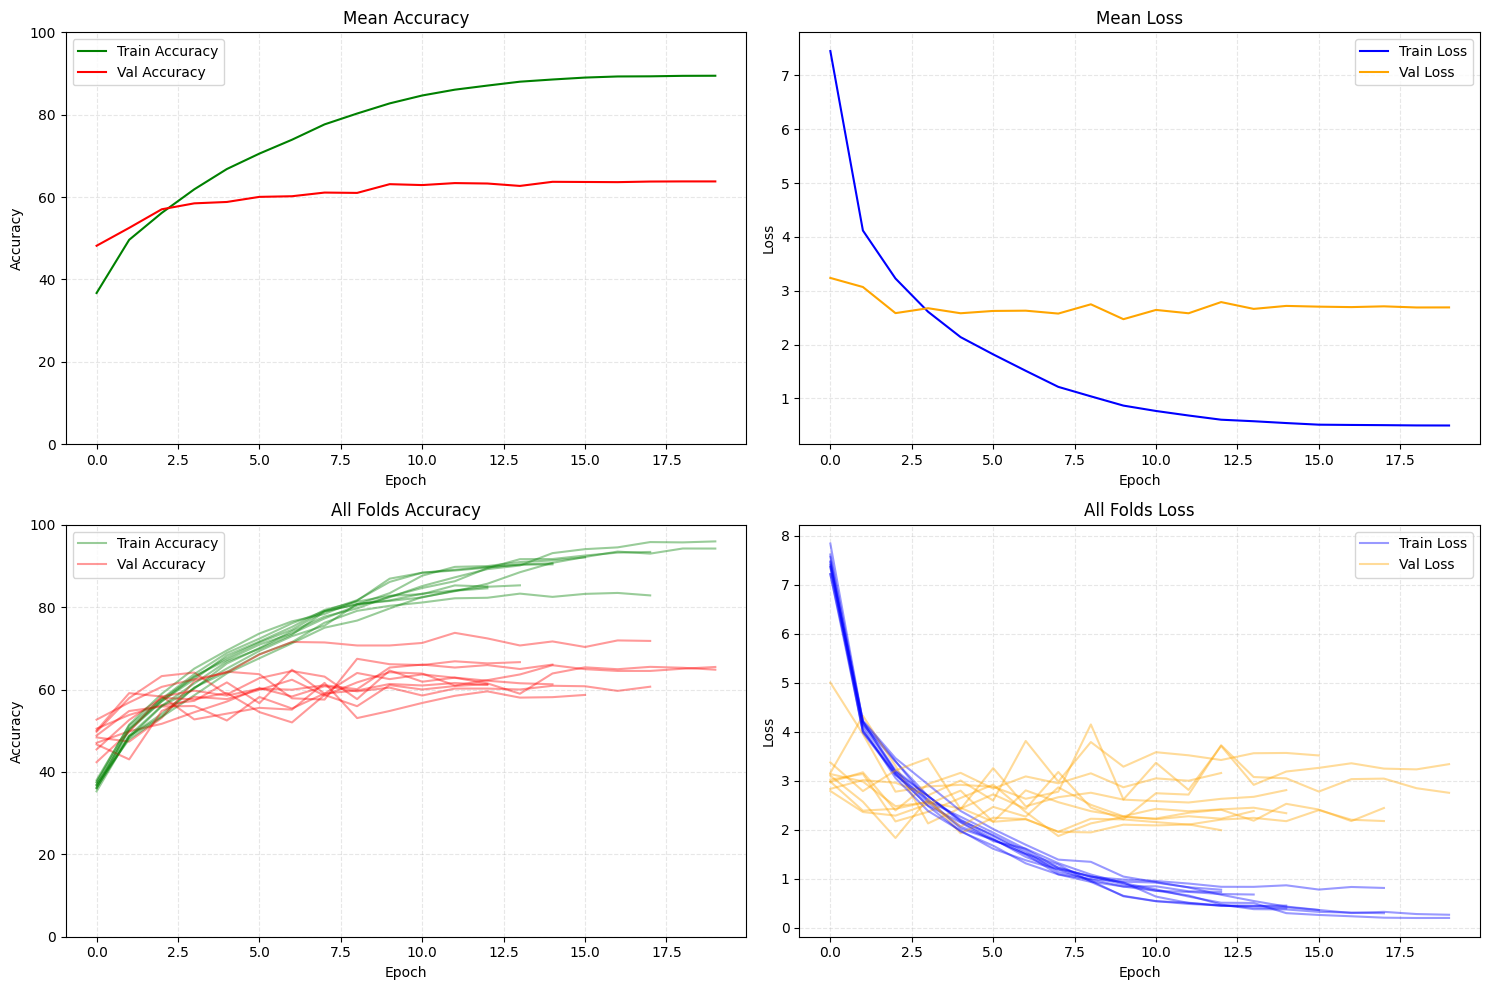

In [37]:
plot_k_fold_histories(hamming_results[1], "hamming")

In [35]:
# Train with Rectangular window
print("Training with Rectangular window...")
rect_results = k_fold_train_single_window(metadata_path, audio_base_path, 'rectangular')
window_results['Rectangular'] = rect_results

Training with Rectangular window...

Starting 10-fold cross validation for rectangular window

Training on fold 1 as validation set

Preparing data for rectangular window
Processing training folds: [2, 3, 4, 5, 6, 7, 8, 9, 10]


Fold 2: 888it [00:10, 88.67it/s] 
Fold 3: 925it [00:08, 111.62it/s]
Fold 4: 990it [00:10, 97.74it/s] 
Fold 5: 936it [00:08, 113.86it/s]
Fold 6: 823it [00:07, 102.97it/s]
Fold 7: 838it [00:08, 96.43it/s] 
Fold 8: 806it [00:07, 103.51it/s]
Fold 9: 816it [00:07, 104.24it/s]
Fold 10: 837it [00:07, 105.74it/s]



Processing test folds: [1]


Fold 1: 873it [00:08, 100.73it/s]



Final shapes:
X_train: (7859, 128, 128)
X_test: (873, 128, 128)


Epoch 1/20: 100%|██████████| 246/246 [00:11<00:00, 21.07it/s]



Epoch 1/20:
Train Loss: 7.618, Train Acc: 35.79%
Val Loss: 2.424, Val Acc: 53.49%


Epoch 2/20: 100%|██████████| 246/246 [00:11<00:00, 21.71it/s]



Epoch 2/20:
Train Loss: 4.153, Train Acc: 47.83%
Val Loss: 1.889, Val Acc: 60.02%


Epoch 3/20: 100%|██████████| 246/246 [00:11<00:00, 21.71it/s]



Epoch 3/20:
Train Loss: 3.352, Train Acc: 54.41%
Val Loss: 2.360, Val Acc: 53.04%


Epoch 4/20: 100%|██████████| 246/246 [00:11<00:00, 21.73it/s]



Epoch 4/20:
Train Loss: 2.749, Train Acc: 59.99%
Val Loss: 1.783, Val Acc: 59.45%


Epoch 5/20: 100%|██████████| 246/246 [00:11<00:00, 21.72it/s]



Epoch 5/20:
Train Loss: 2.323, Train Acc: 63.90%
Val Loss: 2.294, Val Acc: 60.14%


Epoch 6/20: 100%|██████████| 246/246 [00:11<00:00, 21.67it/s]



Epoch 6/20:
Train Loss: 1.900, Train Acc: 69.12%
Val Loss: 2.138, Val Acc: 61.05%


Epoch 7/20: 100%|██████████| 246/246 [00:11<00:00, 21.58it/s]



Epoch 7/20:
Train Loss: 1.716, Train Acc: 72.16%
Val Loss: 2.646, Val Acc: 56.47%


Epoch 8/20: 100%|██████████| 246/246 [00:11<00:00, 21.50it/s]



Epoch 8/20:
Train Loss: 1.569, Train Acc: 74.40%
Val Loss: 2.251, Val Acc: 62.66%


Epoch 9/20: 100%|██████████| 246/246 [00:11<00:00, 21.38it/s]



Epoch 9/20:
Train Loss: 1.100, Train Acc: 79.45%
Val Loss: 2.250, Val Acc: 63.34%


Epoch 10/20: 100%|██████████| 246/246 [00:11<00:00, 21.33it/s]



Epoch 10/20:
Train Loss: 0.970, Train Acc: 81.12%
Val Loss: 2.356, Val Acc: 62.43%


Epoch 11/20: 100%|██████████| 246/246 [00:11<00:00, 21.45it/s]



Epoch 11/20:
Train Loss: 0.882, Train Acc: 83.14%
Val Loss: 2.427, Val Acc: 63.12%


Epoch 12/20: 100%|██████████| 246/246 [00:11<00:00, 21.40it/s]



Epoch 12/20:
Train Loss: 0.799, Train Acc: 83.94%
Val Loss: 2.161, Val Acc: 64.38%


Epoch 13/20: 100%|██████████| 246/246 [00:11<00:00, 21.27it/s]



Epoch 13/20:
Train Loss: 0.762, Train Acc: 84.58%
Val Loss: 2.119, Val Acc: 63.92%


Epoch 14/20: 100%|██████████| 246/246 [00:11<00:00, 21.13it/s]



Epoch 14/20:
Train Loss: 0.780, Train Acc: 84.68%
Val Loss: 2.233, Val Acc: 63.57%

Early stopping triggered after epoch 14

Training on fold 2 as validation set

Preparing data for rectangular window
Processing training folds: [1, 3, 4, 5, 6, 7, 8, 9, 10]


Fold 1: 873it [00:08, 99.13it/s] 
Fold 3: 925it [00:08, 109.09it/s]
Fold 4: 990it [00:09, 104.70it/s]
Fold 5: 936it [00:08, 106.00it/s]
Fold 6: 823it [00:07, 110.73it/s]
Fold 7: 838it [00:08, 101.37it/s]
Fold 8: 806it [00:07, 102.08it/s]
Fold 9: 816it [00:08, 101.51it/s]
Fold 10: 837it [00:08, 95.87it/s] 



Processing test folds: [2]


Fold 2: 888it [00:09, 98.05it/s] 



Final shapes:
X_train: (7844, 128, 128)
X_test: (888, 128, 128)


Epoch 1/20: 100%|██████████| 246/246 [00:11<00:00, 20.87it/s]



Epoch 1/20:
Train Loss: 7.275, Train Acc: 35.67%
Val Loss: 2.993, Val Acc: 37.73%


Epoch 2/20: 100%|██████████| 246/246 [00:11<00:00, 21.60it/s]



Epoch 2/20:
Train Loss: 4.009, Train Acc: 48.57%
Val Loss: 2.779, Val Acc: 54.17%


Epoch 3/20: 100%|██████████| 246/246 [00:11<00:00, 21.45it/s]



Epoch 3/20:
Train Loss: 3.230, Train Acc: 55.20%
Val Loss: 2.683, Val Acc: 52.36%


Epoch 4/20: 100%|██████████| 246/246 [00:11<00:00, 21.27it/s]



Epoch 4/20:
Train Loss: 2.680, Train Acc: 60.54%
Val Loss: 2.828, Val Acc: 50.34%


Epoch 5/20: 100%|██████████| 246/246 [00:11<00:00, 21.33it/s]



Epoch 5/20:
Train Loss: 2.333, Train Acc: 64.78%
Val Loss: 2.543, Val Acc: 56.19%


Epoch 6/20: 100%|██████████| 246/246 [00:11<00:00, 21.15it/s]



Epoch 6/20:
Train Loss: 1.934, Train Acc: 68.97%
Val Loss: 3.252, Val Acc: 54.73%


Epoch 7/20: 100%|██████████| 246/246 [00:11<00:00, 21.11it/s]



Epoch 7/20:
Train Loss: 1.588, Train Acc: 72.72%
Val Loss: 3.119, Val Acc: 60.59%


Epoch 8/20: 100%|██████████| 246/246 [00:11<00:00, 20.95it/s]



Epoch 8/20:
Train Loss: 1.303, Train Acc: 77.04%
Val Loss: 2.630, Val Acc: 60.36%


Epoch 9/20: 100%|██████████| 246/246 [00:11<00:00, 20.97it/s]



Epoch 9/20:
Train Loss: 1.148, Train Acc: 79.00%
Val Loss: 2.520, Val Acc: 59.46%


Epoch 10/20: 100%|██████████| 246/246 [00:11<00:00, 20.86it/s]



Epoch 10/20:
Train Loss: 1.006, Train Acc: 81.60%
Val Loss: 3.069, Val Acc: 59.91%


Epoch 11/20: 100%|██████████| 246/246 [00:11<00:00, 20.78it/s]



Epoch 11/20:
Train Loss: 0.868, Train Acc: 83.96%
Val Loss: 3.017, Val Acc: 61.15%


Epoch 12/20: 100%|██████████| 246/246 [00:11<00:00, 20.76it/s]



Epoch 12/20:
Train Loss: 0.717, Train Acc: 85.54%
Val Loss: 2.947, Val Acc: 61.82%


Epoch 13/20: 100%|██████████| 246/246 [00:11<00:00, 20.71it/s]



Epoch 13/20:
Train Loss: 0.600, Train Acc: 87.46%
Val Loss: 3.009, Val Acc: 64.08%


Epoch 14/20: 100%|██████████| 246/246 [00:11<00:00, 20.58it/s]



Epoch 14/20:
Train Loss: 0.488, Train Acc: 90.91%
Val Loss: 2.745, Val Acc: 63.74%


Epoch 15/20: 100%|██████████| 246/246 [00:12<00:00, 20.44it/s]



Epoch 15/20:
Train Loss: 0.346, Train Acc: 92.38%
Val Loss: 2.963, Val Acc: 64.30%


Epoch 16/20: 100%|██████████| 246/246 [00:12<00:00, 20.50it/s]



Epoch 16/20:
Train Loss: 0.344, Train Acc: 93.13%
Val Loss: 3.095, Val Acc: 63.40%


Epoch 17/20: 100%|██████████| 246/246 [00:11<00:00, 20.67it/s]



Epoch 17/20:
Train Loss: 0.301, Train Acc: 93.75%
Val Loss: 3.190, Val Acc: 64.41%


Epoch 18/20: 100%|██████████| 246/246 [00:12<00:00, 20.47it/s]



Epoch 18/20:
Train Loss: 0.285, Train Acc: 93.97%
Val Loss: 2.915, Val Acc: 64.75%


Epoch 19/20: 100%|██████████| 246/246 [00:12<00:00, 20.45it/s]



Epoch 19/20:
Train Loss: 0.272, Train Acc: 93.86%
Val Loss: 2.980, Val Acc: 64.75%

Early stopping triggered after epoch 19

Training on fold 3 as validation set

Preparing data for rectangular window
Processing training folds: [1, 2, 4, 5, 6, 7, 8, 9, 10]


Fold 1: 873it [00:08, 97.16it/s] 
Fold 2: 888it [00:08, 102.79it/s]
Fold 4: 990it [00:14, 68.96it/s] 
Fold 5: 936it [00:08, 105.21it/s]
Fold 6: 823it [00:07, 106.32it/s]
Fold 7: 838it [00:08, 95.02it/s] 
Fold 8: 806it [00:07, 102.64it/s]
Fold 9: 816it [00:08, 101.50it/s]
Fold 10: 837it [00:08, 102.97it/s]



Processing test folds: [3]


Fold 3: 925it [00:11, 77.14it/s] 



Final shapes:
X_train: (7807, 128, 128)
X_test: (925, 128, 128)


Epoch 1/20: 100%|██████████| 244/244 [00:11<00:00, 21.18it/s]



Epoch 1/20:
Train Loss: 7.342, Train Acc: 35.26%
Val Loss: 2.971, Val Acc: 49.41%


Epoch 2/20: 100%|██████████| 244/244 [00:11<00:00, 21.59it/s]



Epoch 2/20:
Train Loss: 4.173, Train Acc: 47.66%
Val Loss: 3.355, Val Acc: 51.89%


Epoch 3/20: 100%|██████████| 244/244 [00:11<00:00, 21.53it/s]



Epoch 3/20:
Train Loss: 3.220, Train Acc: 55.08%
Val Loss: 3.409, Val Acc: 49.95%


Epoch 4/20: 100%|██████████| 244/244 [00:11<00:00, 21.38it/s]



Epoch 4/20:
Train Loss: 2.728, Train Acc: 59.56%
Val Loss: 4.188, Val Acc: 49.73%


Epoch 5/20: 100%|██████████| 244/244 [00:11<00:00, 21.28it/s]



Epoch 5/20:
Train Loss: 2.318, Train Acc: 63.47%
Val Loss: 3.029, Val Acc: 51.57%


Epoch 6/20: 100%|██████████| 244/244 [00:11<00:00, 20.99it/s]



Epoch 6/20:
Train Loss: 1.667, Train Acc: 69.87%
Val Loss: 2.909, Val Acc: 52.86%


Epoch 7/20: 100%|██████████| 244/244 [00:11<00:00, 20.97it/s]



Epoch 7/20:
Train Loss: 1.542, Train Acc: 72.65%
Val Loss: 3.054, Val Acc: 53.62%


Epoch 8/20: 100%|██████████| 244/244 [00:11<00:00, 20.82it/s]



Epoch 8/20:
Train Loss: 1.445, Train Acc: 73.78%
Val Loss: 3.120, Val Acc: 53.73%


Epoch 9/20: 100%|██████████| 244/244 [00:12<00:00, 19.23it/s]



Epoch 9/20:
Train Loss: 1.333, Train Acc: 75.68%
Val Loss: 3.256, Val Acc: 53.30%


Epoch 10/20: 100%|██████████| 244/244 [00:11<00:00, 20.41it/s]



Epoch 10/20:
Train Loss: 1.324, Train Acc: 76.00%
Val Loss: 3.215, Val Acc: 54.16%


Epoch 11/20: 100%|██████████| 244/244 [00:11<00:00, 20.38it/s]



Epoch 11/20:
Train Loss: 1.264, Train Acc: 77.42%
Val Loss: 3.215, Val Acc: 55.89%


Epoch 12/20: 100%|██████████| 244/244 [00:12<00:00, 20.27it/s]



Epoch 12/20:
Train Loss: 1.158, Train Acc: 77.57%
Val Loss: 3.245, Val Acc: 53.30%


Epoch 13/20: 100%|██████████| 244/244 [00:12<00:00, 20.30it/s]



Epoch 13/20:
Train Loss: 1.213, Train Acc: 77.37%
Val Loss: 3.361, Val Acc: 55.35%


Epoch 14/20: 100%|██████████| 244/244 [00:12<00:00, 20.33it/s]



Epoch 14/20:
Train Loss: 1.229, Train Acc: 77.60%
Val Loss: 3.220, Val Acc: 54.70%


Epoch 15/20: 100%|██████████| 244/244 [00:11<00:00, 20.35it/s]



Epoch 15/20:
Train Loss: 1.142, Train Acc: 78.15%
Val Loss: 3.261, Val Acc: 54.59%


Epoch 16/20: 100%|██████████| 244/244 [00:11<00:00, 20.40it/s]



Epoch 16/20:
Train Loss: 1.133, Train Acc: 77.79%
Val Loss: 3.572, Val Acc: 54.81%

Early stopping triggered after epoch 16

Training on fold 4 as validation set

Preparing data for rectangular window
Processing training folds: [1, 2, 3, 5, 6, 7, 8, 9, 10]


Fold 1: 873it [00:08, 97.70it/s] 
Fold 2: 888it [00:08, 104.27it/s]
Fold 3: 925it [00:08, 110.06it/s]
Fold 5: 936it [00:08, 105.49it/s]
Fold 6: 823it [00:07, 110.47it/s]
Fold 7: 838it [00:07, 105.49it/s]
Fold 8: 806it [00:08, 100.04it/s]
Fold 9: 816it [00:09, 89.62it/s] 
Fold 10: 837it [00:09, 84.89it/s] 



Processing test folds: [4]


Fold 4: 990it [00:10, 90.48it/s] 



Final shapes:
X_train: (7742, 128, 128)
X_test: (990, 128, 128)


Epoch 1/20: 100%|██████████| 242/242 [00:11<00:00, 20.73it/s]



Epoch 1/20:
Train Loss: 7.378, Train Acc: 36.81%
Val Loss: 3.541, Val Acc: 47.88%


Epoch 2/20: 100%|██████████| 242/242 [00:11<00:00, 21.47it/s]



Epoch 2/20:
Train Loss: 4.130, Train Acc: 49.56%
Val Loss: 3.375, Val Acc: 48.59%


Epoch 3/20: 100%|██████████| 242/242 [00:11<00:00, 21.24it/s]



Epoch 3/20:
Train Loss: 3.045, Train Acc: 56.20%
Val Loss: 2.943, Val Acc: 61.31%


Epoch 4/20: 100%|██████████| 242/242 [00:11<00:00, 20.85it/s]



Epoch 4/20:
Train Loss: 2.510, Train Acc: 62.63%
Val Loss: 2.706, Val Acc: 61.72%


Epoch 5/20: 100%|██████████| 242/242 [00:11<00:00, 20.29it/s]



Epoch 5/20:
Train Loss: 2.204, Train Acc: 66.74%
Val Loss: 3.020, Val Acc: 62.12%


Epoch 6/20: 100%|██████████| 242/242 [00:12<00:00, 19.35it/s]



Epoch 6/20:
Train Loss: 1.825, Train Acc: 69.81%
Val Loss: 3.154, Val Acc: 58.79%


Epoch 7/20: 100%|██████████| 242/242 [00:12<00:00, 19.66it/s]



Epoch 7/20:
Train Loss: 1.603, Train Acc: 73.69%
Val Loss: 3.031, Val Acc: 50.40%


Epoch 8/20: 100%|██████████| 242/242 [00:12<00:00, 19.68it/s]



Epoch 8/20:
Train Loss: 1.293, Train Acc: 76.27%
Val Loss: 3.489, Val Acc: 58.99%


Epoch 9/20: 100%|██████████| 242/242 [00:12<00:00, 19.91it/s]



Epoch 9/20:
Train Loss: 0.890, Train Acc: 81.89%
Val Loss: 3.027, Val Acc: 62.83%


Epoch 10/20: 100%|██████████| 242/242 [00:12<00:00, 20.01it/s]



Epoch 10/20:
Train Loss: 0.794, Train Acc: 84.58%
Val Loss: 2.846, Val Acc: 63.03%


Epoch 11/20: 100%|██████████| 242/242 [00:11<00:00, 20.28it/s]



Epoch 11/20:
Train Loss: 0.725, Train Acc: 84.67%
Val Loss: 2.783, Val Acc: 63.54%


Epoch 12/20: 100%|██████████| 242/242 [00:11<00:00, 20.37it/s]



Epoch 12/20:
Train Loss: 0.652, Train Acc: 86.44%
Val Loss: 2.902, Val Acc: 62.32%


Epoch 13/20: 100%|██████████| 242/242 [00:11<00:00, 20.30it/s]



Epoch 13/20:
Train Loss: 0.627, Train Acc: 86.67%
Val Loss: 2.867, Val Acc: 62.73%


Epoch 14/20: 100%|██████████| 242/242 [00:11<00:00, 20.31it/s]



Epoch 14/20:
Train Loss: 0.615, Train Acc: 86.77%
Val Loss: 2.900, Val Acc: 62.63%

Early stopping triggered after epoch 14

Training on fold 5 as validation set

Preparing data for rectangular window
Processing training folds: [1, 2, 3, 4, 6, 7, 8, 9, 10]


Fold 1: 873it [00:09, 91.31it/s] 
Fold 2: 888it [00:09, 95.16it/s] 
Fold 3: 925it [00:09, 101.49it/s]
Fold 4: 990it [00:09, 100.38it/s]
Fold 6: 823it [00:08, 96.40it/s] 
Fold 7: 838it [00:08, 96.94it/s] 
Fold 8: 806it [00:09, 83.08it/s] 
Fold 9: 816it [00:09, 88.88it/s] 
Fold 10: 837it [00:09, 92.83it/s] 



Processing test folds: [5]


Fold 5: 936it [00:08, 104.91it/s]



Final shapes:
X_train: (7796, 128, 128)
X_test: (936, 128, 128)


Epoch 1/20: 100%|██████████| 244/244 [00:11<00:00, 21.05it/s]



Epoch 1/20:
Train Loss: 7.427, Train Acc: 36.04%
Val Loss: 3.555, Val Acc: 46.79%


Epoch 2/20: 100%|██████████| 244/244 [00:11<00:00, 21.56it/s]



Epoch 2/20:
Train Loss: 4.305, Train Acc: 47.09%
Val Loss: 2.573, Val Acc: 55.56%


Epoch 3/20: 100%|██████████| 244/244 [00:11<00:00, 21.59it/s]



Epoch 3/20:
Train Loss: 3.254, Train Acc: 55.05%
Val Loss: 2.698, Val Acc: 60.36%


Epoch 4/20: 100%|██████████| 244/244 [00:11<00:00, 21.28it/s]



Epoch 4/20:
Train Loss: 2.674, Train Acc: 61.36%
Val Loss: 2.584, Val Acc: 63.78%


Epoch 5/20: 100%|██████████| 244/244 [00:11<00:00, 20.93it/s]



Epoch 5/20:
Train Loss: 2.307, Train Acc: 65.03%
Val Loss: 2.721, Val Acc: 63.14%


Epoch 6/20: 100%|██████████| 244/244 [00:11<00:00, 20.79it/s]



Epoch 6/20:
Train Loss: 1.879, Train Acc: 69.59%
Val Loss: 2.458, Val Acc: 62.07%


Epoch 7/20: 100%|██████████| 244/244 [00:11<00:00, 20.39it/s]



Epoch 7/20:
Train Loss: 1.620, Train Acc: 72.99%
Val Loss: 2.625, Val Acc: 65.28%


Epoch 8/20: 100%|██████████| 244/244 [00:12<00:00, 20.23it/s]



Epoch 8/20:
Train Loss: 1.346, Train Acc: 76.04%
Val Loss: 2.790, Val Acc: 58.87%


Epoch 9/20: 100%|██████████| 244/244 [00:11<00:00, 20.39it/s]



Epoch 9/20:
Train Loss: 1.124, Train Acc: 79.08%
Val Loss: 3.126, Val Acc: 62.61%


Epoch 10/20: 100%|██████████| 244/244 [00:11<00:00, 20.51it/s]



Epoch 10/20:
Train Loss: 0.983, Train Acc: 80.87%
Val Loss: 3.330, Val Acc: 58.12%


Epoch 11/20: 100%|██████████| 244/244 [00:11<00:00, 20.52it/s]



Epoch 11/20:
Train Loss: 0.719, Train Acc: 85.44%
Val Loss: 2.825, Val Acc: 61.11%


Epoch 12/20: 100%|██████████| 244/244 [00:11<00:00, 20.53it/s]



Epoch 12/20:
Train Loss: 0.607, Train Acc: 87.06%
Val Loss: 2.964, Val Acc: 62.50%


Epoch 13/20: 100%|██████████| 244/244 [00:12<00:00, 20.33it/s]



Epoch 13/20:
Train Loss: 0.533, Train Acc: 88.46%
Val Loss: 2.795, Val Acc: 63.68%


Epoch 14/20: 100%|██████████| 244/244 [00:11<00:00, 20.38it/s]



Epoch 14/20:
Train Loss: 0.484, Train Acc: 89.23%
Val Loss: 2.867, Val Acc: 63.14%


Epoch 15/20: 100%|██████████| 244/244 [00:11<00:00, 20.46it/s]



Epoch 15/20:
Train Loss: 0.447, Train Acc: 89.91%
Val Loss: 2.940, Val Acc: 63.68%


Epoch 16/20: 100%|██████████| 244/244 [00:12<00:00, 20.32it/s]



Epoch 16/20:
Train Loss: 0.440, Train Acc: 90.30%
Val Loss: 2.952, Val Acc: 63.03%

Early stopping triggered after epoch 16

Training on fold 6 as validation set

Preparing data for rectangular window
Processing training folds: [1, 2, 3, 4, 5, 7, 8, 9, 10]


Fold 1: 873it [00:08, 101.58it/s]
Fold 2: 888it [00:10, 81.75it/s] 
Fold 3: 925it [00:08, 103.11it/s]
Fold 4: 990it [00:09, 101.33it/s]
Fold 5: 936it [00:09, 95.40it/s] 
Fold 7: 838it [00:20, 40.31it/s]
Fold 8: 806it [00:11, 71.88it/s] 
Fold 9: 816it [00:08, 92.24it/s] 
Fold 10: 837it [00:08, 97.49it/s] 



Processing test folds: [6]


Fold 6: 823it [00:07, 103.24it/s]



Final shapes:
X_train: (7909, 128, 128)
X_test: (823, 128, 128)


Epoch 1/20: 100%|██████████| 248/248 [00:11<00:00, 21.30it/s]



Epoch 1/20:
Train Loss: 7.379, Train Acc: 36.15%
Val Loss: 2.618, Val Acc: 50.30%


Epoch 2/20: 100%|██████████| 248/248 [00:11<00:00, 21.78it/s]



Epoch 2/20:
Train Loss: 4.136, Train Acc: 48.12%
Val Loss: 3.516, Val Acc: 46.05%


Epoch 3/20: 100%|██████████| 248/248 [00:11<00:00, 21.61it/s]



Epoch 3/20:
Train Loss: 3.404, Train Acc: 54.96%
Val Loss: 2.477, Val Acc: 52.73%


Epoch 4/20: 100%|██████████| 248/248 [00:11<00:00, 21.28it/s]



Epoch 4/20:
Train Loss: 2.612, Train Acc: 61.60%
Val Loss: 2.481, Val Acc: 54.68%


Epoch 5/20: 100%|██████████| 248/248 [00:11<00:00, 21.07it/s]



Epoch 5/20:
Train Loss: 2.151, Train Acc: 67.08%
Val Loss: 2.724, Val Acc: 57.35%


Epoch 6/20: 100%|██████████| 248/248 [00:11<00:00, 21.01it/s]



Epoch 6/20:
Train Loss: 1.761, Train Acc: 70.31%
Val Loss: 3.019, Val Acc: 57.23%


Epoch 7/20: 100%|██████████| 248/248 [00:11<00:00, 20.91it/s]



Epoch 7/20:
Train Loss: 1.556, Train Acc: 74.12%
Val Loss: 2.511, Val Acc: 58.69%


Epoch 8/20: 100%|██████████| 248/248 [00:11<00:00, 20.89it/s]



Epoch 8/20:
Train Loss: 1.123, Train Acc: 78.29%
Val Loss: 2.332, Val Acc: 62.58%


Epoch 9/20: 100%|██████████| 248/248 [00:12<00:00, 20.62it/s]



Epoch 9/20:
Train Loss: 0.983, Train Acc: 81.41%
Val Loss: 2.560, Val Acc: 63.18%


Epoch 10/20: 100%|██████████| 248/248 [00:12<00:00, 19.98it/s]



Epoch 10/20:
Train Loss: 0.920, Train Acc: 82.60%
Val Loss: 2.587, Val Acc: 63.79%


Epoch 11/20: 100%|██████████| 248/248 [00:12<00:00, 19.98it/s]



Epoch 11/20:
Train Loss: 0.843, Train Acc: 82.96%
Val Loss: 2.639, Val Acc: 62.94%


Epoch 12/20: 100%|██████████| 248/248 [00:12<00:00, 19.79it/s]



Epoch 12/20:
Train Loss: 0.788, Train Acc: 84.18%
Val Loss: 2.746, Val Acc: 62.58%


Epoch 13/20: 100%|██████████| 248/248 [00:12<00:00, 19.84it/s]



Epoch 13/20:
Train Loss: 0.783, Train Acc: 85.35%
Val Loss: 2.768, Val Acc: 61.85%


Epoch 14/20: 100%|██████████| 248/248 [00:12<00:00, 19.88it/s]



Epoch 14/20:
Train Loss: 0.694, Train Acc: 85.70%
Val Loss: 2.797, Val Acc: 63.79%


Epoch 15/20: 100%|██████████| 248/248 [00:12<00:00, 19.91it/s]



Epoch 15/20:
Train Loss: 0.727, Train Acc: 85.48%
Val Loss: 2.716, Val Acc: 63.43%


Epoch 16/20: 100%|██████████| 248/248 [00:12<00:00, 19.35it/s]



Epoch 16/20:
Train Loss: 0.773, Train Acc: 85.28%
Val Loss: 2.892, Val Acc: 62.70%


Epoch 17/20: 100%|██████████| 248/248 [00:12<00:00, 19.43it/s]



Epoch 17/20:
Train Loss: 0.734, Train Acc: 85.56%
Val Loss: 2.796, Val Acc: 63.06%


Epoch 18/20: 100%|██████████| 248/248 [00:12<00:00, 19.87it/s]



Epoch 18/20:
Train Loss: 0.669, Train Acc: 85.85%
Val Loss: 2.996, Val Acc: 62.58%

Early stopping triggered after epoch 18

Training on fold 7 as validation set

Preparing data for rectangular window
Processing training folds: [1, 2, 3, 4, 5, 6, 8, 9, 10]


Fold 1: 873it [00:09, 90.38it/s] 
Fold 2: 888it [00:09, 92.69it/s] 
Fold 3: 925it [00:12, 75.53it/s]
Fold 4: 990it [00:10, 95.10it/s] 
Fold 5: 936it [00:10, 88.69it/s] 
Fold 6: 823it [00:07, 106.26it/s]
Fold 8: 806it [00:07, 107.44it/s]
Fold 9: 816it [00:08, 94.59it/s] 
Fold 10: 837it [00:08, 97.45it/s] 



Processing test folds: [7]


Fold 7: 838it [00:09, 91.70it/s] 



Final shapes:
X_train: (7894, 128, 128)
X_test: (838, 128, 128)


Epoch 1/20: 100%|██████████| 247/247 [00:11<00:00, 21.22it/s]



Epoch 1/20:
Train Loss: 7.280, Train Acc: 37.37%
Val Loss: 3.010, Val Acc: 44.03%


Epoch 2/20: 100%|██████████| 247/247 [00:11<00:00, 21.42it/s]



Epoch 2/20:
Train Loss: 4.228, Train Acc: 48.72%
Val Loss: 2.861, Val Acc: 49.64%


Epoch 3/20: 100%|██████████| 247/247 [00:11<00:00, 21.18it/s]



Epoch 3/20:
Train Loss: 3.266, Train Acc: 55.05%
Val Loss: 2.343, Val Acc: 53.94%


Epoch 4/20: 100%|██████████| 247/247 [00:11<00:00, 20.97it/s]



Epoch 4/20:
Train Loss: 2.708, Train Acc: 60.53%
Val Loss: 1.876, Val Acc: 61.58%


Epoch 5/20: 100%|██████████| 247/247 [00:11<00:00, 20.82it/s]



Epoch 5/20:
Train Loss: 2.295, Train Acc: 64.64%
Val Loss: 1.736, Val Acc: 61.34%


Epoch 6/20: 100%|██████████| 247/247 [00:11<00:00, 20.74it/s]



Epoch 6/20:
Train Loss: 1.908, Train Acc: 69.66%
Val Loss: 2.214, Val Acc: 58.00%


Epoch 7/20: 100%|██████████| 247/247 [00:12<00:00, 20.35it/s]



Epoch 7/20:
Train Loss: 1.547, Train Acc: 73.65%
Val Loss: 1.924, Val Acc: 61.58%


Epoch 8/20: 100%|██████████| 247/247 [00:12<00:00, 20.33it/s]



Epoch 8/20:
Train Loss: 1.326, Train Acc: 76.15%
Val Loss: 2.084, Val Acc: 61.34%


Epoch 9/20: 100%|██████████| 247/247 [00:12<00:00, 20.23it/s]



Epoch 9/20:
Train Loss: 1.101, Train Acc: 79.73%
Val Loss: 2.520, Val Acc: 56.56%


Epoch 10/20: 100%|██████████| 247/247 [00:12<00:00, 19.97it/s]



Epoch 10/20:
Train Loss: 0.837, Train Acc: 83.77%
Val Loss: 1.966, Val Acc: 63.48%


Epoch 11/20: 100%|██████████| 247/247 [00:13<00:00, 17.95it/s]



Epoch 11/20:
Train Loss: 0.722, Train Acc: 85.33%
Val Loss: 1.796, Val Acc: 63.37%


Epoch 12/20: 100%|██████████| 247/247 [00:13<00:00, 18.25it/s]



Epoch 12/20:
Train Loss: 0.676, Train Acc: 86.91%
Val Loss: 1.849, Val Acc: 64.92%


Epoch 13/20: 100%|██████████| 247/247 [00:13<00:00, 18.23it/s]



Epoch 13/20:
Train Loss: 0.588, Train Acc: 87.57%
Val Loss: 1.819, Val Acc: 63.60%


Epoch 14/20: 100%|██████████| 247/247 [00:13<00:00, 18.29it/s]



Epoch 14/20:
Train Loss: 0.574, Train Acc: 88.55%
Val Loss: 1.940, Val Acc: 65.27%


Epoch 15/20: 100%|██████████| 247/247 [00:13<00:00, 18.12it/s]



Epoch 15/20:
Train Loss: 0.557, Train Acc: 89.00%
Val Loss: 1.838, Val Acc: 64.80%

Early stopping triggered after epoch 15

Training on fold 8 as validation set

Preparing data for rectangular window
Processing training folds: [1, 2, 3, 4, 5, 6, 7, 9, 10]


Fold 1: 873it [00:11, 74.49it/s] 
Fold 2: 888it [00:09, 94.13it/s] 
Fold 3: 925it [00:09, 95.50it/s] 
Fold 4: 990it [00:11, 85.20it/s] 
Fold 5: 936it [00:09, 98.64it/s] 
Fold 6: 823it [00:07, 107.93it/s]
Fold 7: 838it [00:08, 93.98it/s] 
Fold 9: 816it [00:15, 54.04it/s] 
Fold 10: 837it [00:08, 99.39it/s] 



Processing test folds: [8]


Fold 8: 806it [00:08, 95.86it/s] 



Final shapes:
X_train: (7926, 128, 128)
X_test: (806, 128, 128)


Epoch 1/20: 100%|██████████| 248/248 [00:14<00:00, 16.69it/s]



Epoch 1/20:
Train Loss: 7.501, Train Acc: 36.30%
Val Loss: 3.726, Val Acc: 43.80%


Epoch 2/20: 100%|██████████| 248/248 [00:13<00:00, 18.15it/s]



Epoch 2/20:
Train Loss: 4.149, Train Acc: 50.06%
Val Loss: 2.723, Val Acc: 59.31%


Epoch 3/20: 100%|██████████| 248/248 [00:13<00:00, 18.48it/s]



Epoch 3/20:
Train Loss: 3.363, Train Acc: 55.61%
Val Loss: 2.587, Val Acc: 58.56%


Epoch 4/20: 100%|██████████| 248/248 [00:13<00:00, 18.84it/s]



Epoch 4/20:
Train Loss: 2.776, Train Acc: 61.39%
Val Loss: 2.632, Val Acc: 66.13%


Epoch 5/20: 100%|██████████| 248/248 [00:13<00:00, 18.54it/s]



Epoch 5/20:
Train Loss: 2.201, Train Acc: 65.85%
Val Loss: 3.030, Val Acc: 58.56%


Epoch 6/20: 100%|██████████| 248/248 [00:13<00:00, 18.55it/s]



Epoch 6/20:
Train Loss: 1.889, Train Acc: 70.19%
Val Loss: 2.524, Val Acc: 53.72%


Epoch 7/20: 100%|██████████| 248/248 [00:13<00:00, 18.25it/s]



Epoch 7/20:
Train Loss: 1.586, Train Acc: 72.60%
Val Loss: 2.111, Val Acc: 63.15%


Epoch 8/20: 100%|██████████| 248/248 [00:13<00:00, 18.49it/s]



Epoch 8/20:
Train Loss: 1.344, Train Acc: 76.47%
Val Loss: 2.551, Val Acc: 60.92%


Epoch 9/20: 100%|██████████| 248/248 [00:13<00:00, 18.73it/s]



Epoch 9/20:
Train Loss: 1.182, Train Acc: 78.45%
Val Loss: 2.401, Val Acc: 61.04%


Epoch 10/20: 100%|██████████| 248/248 [00:13<00:00, 18.41it/s]



Epoch 10/20:
Train Loss: 0.962, Train Acc: 81.31%
Val Loss: 2.289, Val Acc: 62.90%


Epoch 11/20: 100%|██████████| 248/248 [00:13<00:00, 18.68it/s]



Epoch 11/20:
Train Loss: 0.853, Train Acc: 83.42%
Val Loss: 2.069, Val Acc: 65.14%


Epoch 12/20: 100%|██████████| 248/248 [00:13<00:00, 18.19it/s]



Epoch 12/20:
Train Loss: 0.719, Train Acc: 85.72%
Val Loss: 2.586, Val Acc: 63.40%


Epoch 13/20: 100%|██████████| 248/248 [00:13<00:00, 18.65it/s]



Epoch 13/20:
Train Loss: 0.591, Train Acc: 87.80%
Val Loss: 2.965, Val Acc: 61.66%


Epoch 14/20: 100%|██████████| 248/248 [00:13<00:00, 18.45it/s]



Epoch 14/20:
Train Loss: 0.508, Train Acc: 89.26%
Val Loss: 2.803, Val Acc: 59.68%


Epoch 15/20: 100%|██████████| 248/248 [00:13<00:00, 18.35it/s]



Epoch 15/20:
Train Loss: 0.487, Train Acc: 90.18%
Val Loss: 2.975, Val Acc: 59.55%


Epoch 16/20: 100%|██████████| 248/248 [00:13<00:00, 18.35it/s]



Epoch 16/20:
Train Loss: 0.337, Train Acc: 93.06%
Val Loss: 2.476, Val Acc: 64.14%


Epoch 17/20: 100%|██████████| 248/248 [00:13<00:00, 18.19it/s]



Epoch 17/20:
Train Loss: 0.272, Train Acc: 93.69%
Val Loss: 2.581, Val Acc: 64.52%


Epoch 18/20: 100%|██████████| 248/248 [00:13<00:00, 18.29it/s]



Epoch 18/20:
Train Loss: 0.244, Train Acc: 94.66%
Val Loss: 2.589, Val Acc: 64.52%


Epoch 19/20: 100%|██████████| 248/248 [00:13<00:00, 18.19it/s]



Epoch 19/20:
Train Loss: 0.222, Train Acc: 95.04%
Val Loss: 2.528, Val Acc: 64.52%


Epoch 20/20: 100%|██████████| 248/248 [00:13<00:00, 18.53it/s]



Epoch 20/20:
Train Loss: 0.191, Train Acc: 95.75%
Val Loss: 2.593, Val Acc: 65.14%

Training on fold 9 as validation set

Preparing data for rectangular window
Processing training folds: [1, 2, 3, 4, 5, 6, 7, 8, 10]


Fold 1: 873it [00:09, 89.89it/s] 
Fold 2: 888it [00:09, 97.51it/s] 
Fold 3: 925it [00:09, 101.21it/s]
Fold 4: 990it [00:09, 100.94it/s]
Fold 5: 936it [00:09, 103.92it/s]
Fold 6: 823it [00:07, 103.39it/s]
Fold 7: 838it [00:08, 97.52it/s] 
Fold 8: 806it [00:08, 97.51it/s] 
Fold 10: 837it [00:09, 88.87it/s] 



Processing test folds: [9]


Fold 9: 816it [00:08, 94.23it/s] 



Final shapes:
X_train: (7916, 128, 128)
X_test: (816, 128, 128)


Epoch 1/20: 100%|██████████| 248/248 [00:13<00:00, 18.09it/s]



Epoch 1/20:
Train Loss: 7.507, Train Acc: 35.54%
Val Loss: 3.469, Val Acc: 50.86%


Epoch 2/20: 100%|██████████| 248/248 [00:13<00:00, 17.74it/s]



Epoch 2/20:
Train Loss: 4.289, Train Acc: 47.68%
Val Loss: 2.529, Val Acc: 61.64%


Epoch 3/20: 100%|██████████| 248/248 [00:13<00:00, 17.83it/s]



Epoch 3/20:
Train Loss: 3.523, Train Acc: 53.37%
Val Loss: 2.487, Val Acc: 63.36%


Epoch 4/20: 100%|██████████| 248/248 [00:13<00:00, 18.44it/s]



Epoch 4/20:
Train Loss: 2.815, Train Acc: 59.30%
Val Loss: 1.843, Val Acc: 68.87%


Epoch 5/20: 100%|██████████| 248/248 [00:13<00:00, 18.77it/s]



Epoch 5/20:
Train Loss: 2.384, Train Acc: 64.14%
Val Loss: 1.978, Val Acc: 68.38%


Epoch 6/20: 100%|██████████| 248/248 [00:13<00:00, 18.76it/s]



Epoch 6/20:
Train Loss: 1.943, Train Acc: 68.96%
Val Loss: 1.911, Val Acc: 68.01%


Epoch 7/20: 100%|██████████| 248/248 [00:13<00:00, 18.61it/s]



Epoch 7/20:
Train Loss: 1.640, Train Acc: 72.70%
Val Loss: 2.837, Val Acc: 71.81%


Epoch 8/20: 100%|██████████| 248/248 [00:13<00:00, 18.69it/s]



Epoch 8/20:
Train Loss: 1.515, Train Acc: 74.03%
Val Loss: 2.414, Val Acc: 69.49%


Epoch 9/20: 100%|██████████| 248/248 [00:13<00:00, 18.78it/s]



Epoch 9/20:
Train Loss: 1.066, Train Acc: 80.09%
Val Loss: 2.277, Val Acc: 71.69%


Epoch 10/20: 100%|██████████| 248/248 [00:13<00:00, 18.52it/s]



Epoch 10/20:
Train Loss: 0.952, Train Acc: 82.23%
Val Loss: 2.357, Val Acc: 71.32%


Epoch 11/20: 100%|██████████| 248/248 [00:13<00:00, 18.31it/s]



Epoch 11/20:
Train Loss: 0.853, Train Acc: 82.64%
Val Loss: 2.301, Val Acc: 71.69%


Epoch 12/20: 100%|██████████| 248/248 [00:13<00:00, 18.12it/s]



Epoch 12/20:
Train Loss: 0.844, Train Acc: 83.54%
Val Loss: 2.285, Val Acc: 71.45%


Epoch 13/20: 100%|██████████| 248/248 [00:13<00:00, 18.60it/s]



Epoch 13/20:
Train Loss: 0.736, Train Acc: 84.77%
Val Loss: 2.271, Val Acc: 72.67%


Epoch 14/20: 100%|██████████| 248/248 [00:13<00:00, 18.52it/s]



Epoch 14/20:
Train Loss: 0.747, Train Acc: 83.87%
Val Loss: 2.394, Val Acc: 71.94%

Early stopping triggered after epoch 14

Training on fold 10 as validation set

Preparing data for rectangular window
Processing training folds: [1, 2, 3, 4, 5, 6, 7, 8, 9]


Fold 1: 873it [00:09, 92.97it/s] 
Fold 2: 888it [00:09, 96.21it/s] 
Fold 3: 925it [00:08, 104.23it/s]
Fold 4: 990it [00:09, 100.44it/s]
Fold 5: 936it [00:09, 102.40it/s]
Fold 6: 823it [00:08, 100.07it/s]
Fold 7: 838it [00:09, 91.87it/s] 
Fold 8: 806it [00:09, 89.09it/s] 
Fold 9: 816it [00:09, 87.41it/s] 



Processing test folds: [10]


Fold 10: 837it [00:09, 86.35it/s] 



Final shapes:
X_train: (7895, 128, 128)
X_test: (837, 128, 128)


Epoch 1/20: 100%|██████████| 247/247 [00:13<00:00, 18.17it/s]



Epoch 1/20:
Train Loss: 7.291, Train Acc: 34.77%
Val Loss: 3.612, Val Acc: 52.33%


Epoch 2/20: 100%|██████████| 247/247 [00:13<00:00, 18.77it/s]



Epoch 2/20:
Train Loss: 4.157, Train Acc: 47.85%
Val Loss: 2.630, Val Acc: 53.76%


Epoch 3/20: 100%|██████████| 247/247 [00:13<00:00, 18.79it/s]



Epoch 3/20:
Train Loss: 3.382, Train Acc: 53.83%
Val Loss: 2.567, Val Acc: 55.32%


Epoch 4/20: 100%|██████████| 247/247 [00:13<00:00, 18.72it/s]



Epoch 4/20:
Train Loss: 2.966, Train Acc: 58.99%
Val Loss: 2.584, Val Acc: 52.57%


Epoch 5/20: 100%|██████████| 247/247 [00:13<00:00, 18.46it/s]



Epoch 5/20:
Train Loss: 2.517, Train Acc: 62.95%
Val Loss: 2.637, Val Acc: 53.88%


Epoch 6/20: 100%|██████████| 247/247 [00:13<00:00, 18.69it/s]



Epoch 6/20:
Train Loss: 2.055, Train Acc: 68.01%
Val Loss: 2.516, Val Acc: 61.53%


Epoch 7/20: 100%|██████████| 247/247 [00:13<00:00, 18.54it/s]



Epoch 7/20:
Train Loss: 1.672, Train Acc: 72.37%
Val Loss: 2.446, Val Acc: 58.06%


Epoch 8/20: 100%|██████████| 247/247 [00:13<00:00, 18.49it/s]



Epoch 8/20:
Train Loss: 1.421, Train Acc: 75.96%
Val Loss: 2.264, Val Acc: 62.49%


Epoch 9/20: 100%|██████████| 247/247 [00:13<00:00, 18.48it/s]



Epoch 9/20:
Train Loss: 1.221, Train Acc: 78.58%
Val Loss: 2.292, Val Acc: 62.49%


Epoch 10/20: 100%|██████████| 247/247 [00:13<00:00, 18.36it/s]



Epoch 10/20:
Train Loss: 1.043, Train Acc: 81.04%
Val Loss: 2.832, Val Acc: 63.56%


Epoch 11/20: 100%|██████████| 247/247 [00:13<00:00, 18.72it/s]



Epoch 11/20:
Train Loss: 0.907, Train Acc: 82.77%
Val Loss: 2.632, Val Acc: 58.90%


Epoch 12/20: 100%|██████████| 247/247 [00:13<00:00, 18.57it/s]



Epoch 12/20:
Train Loss: 0.722, Train Acc: 85.78%
Val Loss: 2.657, Val Acc: 63.20%


Epoch 13/20: 100%|██████████| 247/247 [00:13<00:00, 18.58it/s]



Epoch 13/20:
Train Loss: 0.539, Train Acc: 89.31%
Val Loss: 2.662, Val Acc: 64.40%


Epoch 14/20: 100%|██████████| 247/247 [00:13<00:00, 18.41it/s]



Epoch 14/20:
Train Loss: 0.451, Train Acc: 90.64%
Val Loss: 2.855, Val Acc: 63.20%


Epoch 15/20: 100%|██████████| 247/247 [00:13<00:00, 18.12it/s]



Epoch 15/20:
Train Loss: 0.366, Train Acc: 91.83%
Val Loss: 2.963, Val Acc: 62.49%


Epoch 16/20: 100%|██████████| 247/247 [00:13<00:00, 18.53it/s]



Epoch 16/20:
Train Loss: 0.358, Train Acc: 92.25%
Val Loss: 2.811, Val Acc: 63.44%


Epoch 17/20: 100%|██████████| 247/247 [00:13<00:00, 18.68it/s]



Epoch 17/20:
Train Loss: 0.306, Train Acc: 93.22%
Val Loss: 2.811, Val Acc: 64.87%


Epoch 18/20: 100%|██████████| 247/247 [00:13<00:00, 18.74it/s]



Epoch 18/20:
Train Loss: 0.325, Train Acc: 92.89%
Val Loss: 2.826, Val Acc: 65.23%

Early stopping triggered after epoch 18

Cross-validation results for rectangular window:
Average validation accuracy: 63.85% ± 3.95%


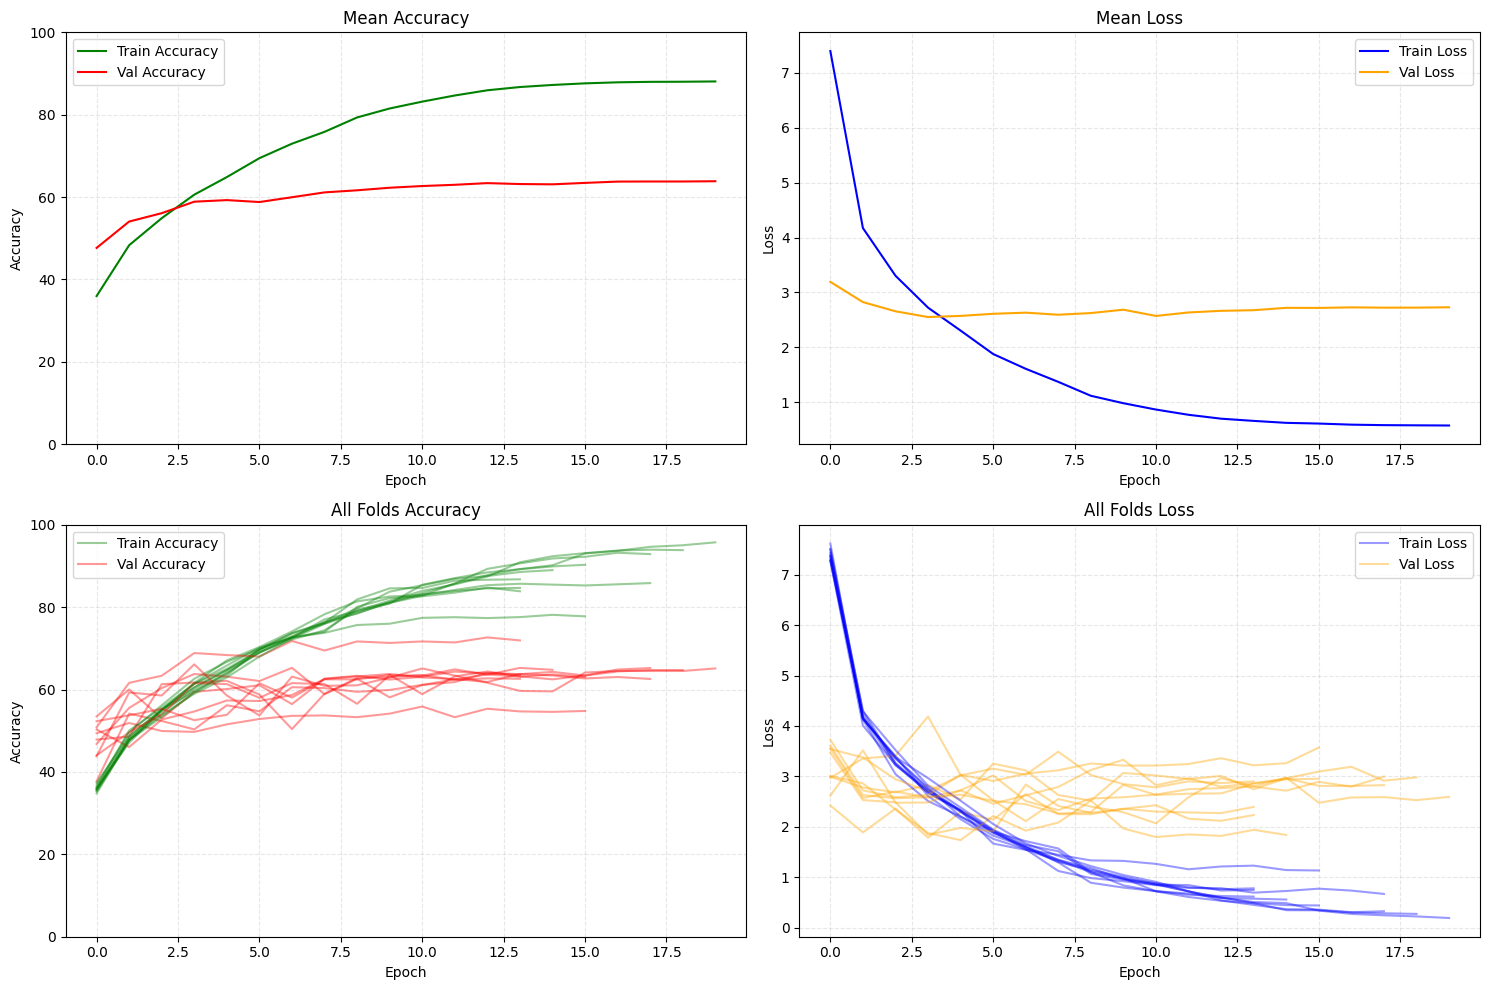

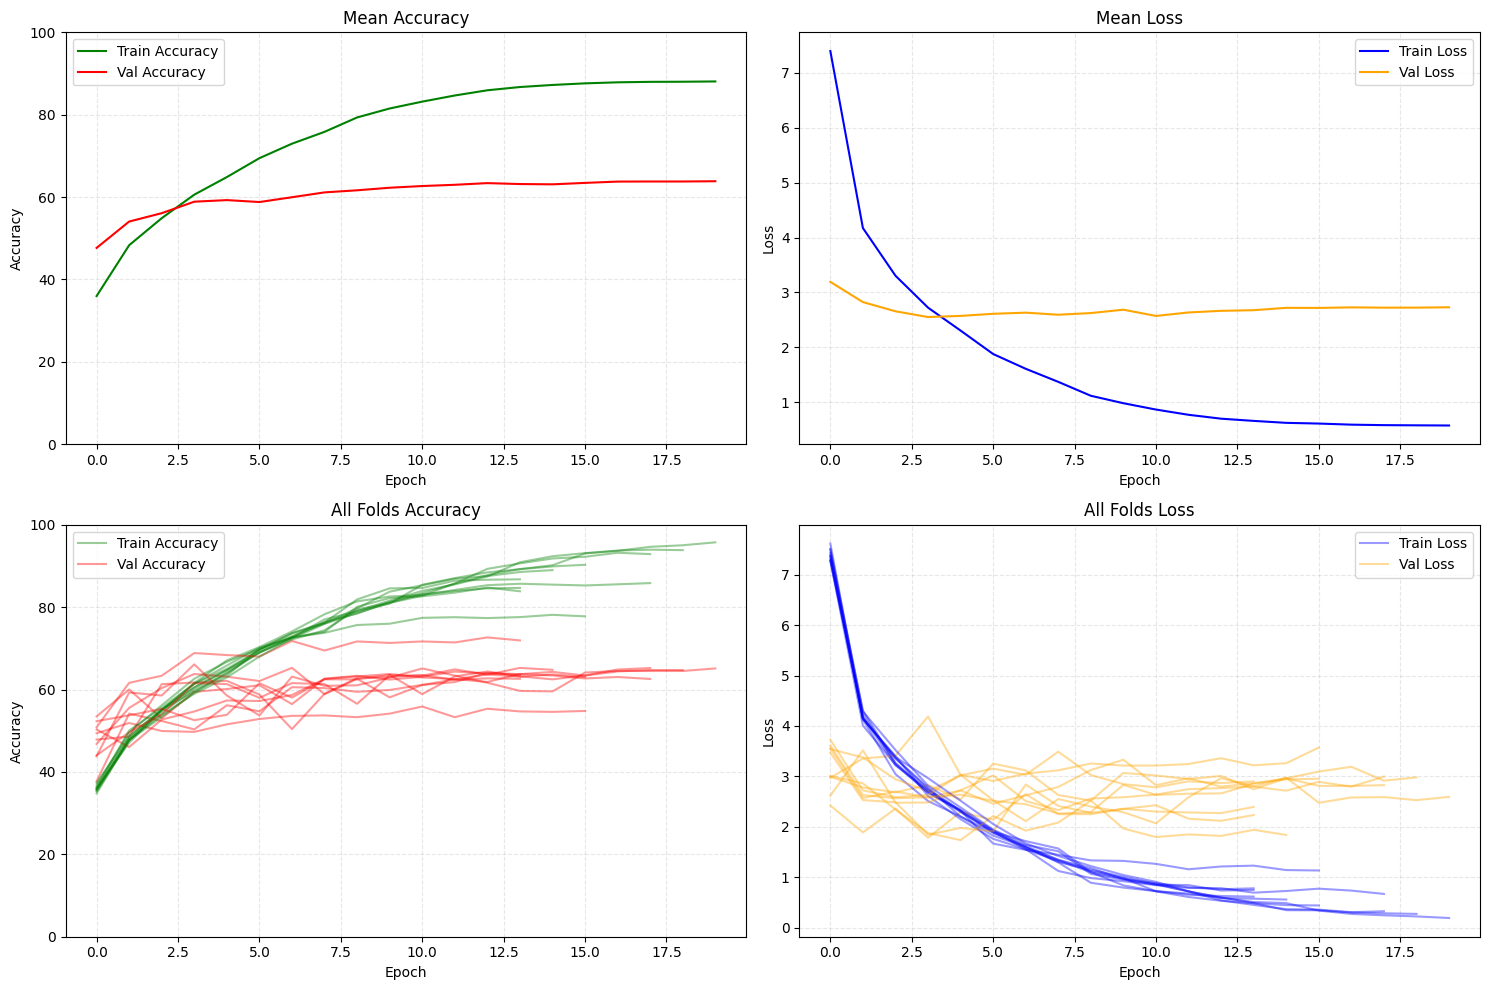

In [36]:
plot_k_fold_histories(rect_results[1], "rectange")

In [40]:
pprint.pprint(window_results)

{'Hamming': ([{'final_val_acc': 64.83390607101947,
               'final_val_loss': 2.7527654397937504,
               'fold': 1},
              {'final_val_acc': 60.6981981981982,
               'final_val_loss': 2.44263454749515,
               'fold': 2},
              {'final_val_acc': 58.7027027027027,
               'final_val_loss': 3.515091130965598,
               'fold': 3},
              {'final_val_acc': 66.66666666666667,
               'final_val_loss': 2.3807795359302433,
               'fold': 4},
              {'final_val_acc': 65.49145299145299,
               'final_val_loss': 3.3375612651308377,
               'fold': 5},
              {'final_val_acc': 61.11786148238153,
               'final_val_loss': 3.156644203341924,
               'fold': 6},
              {'final_val_acc': 61.33651551312649,
               'final_val_loss': 1.9896236404224679,
               'fold': 7},
              {'final_val_acc': 61.29032258064516,
               'final_val_loss': 2.336


Window Type Comparison:
             Mean Accuracy  Std Accuracy
Hann             65.085343      4.528986
Hamming          63.802065      3.897035
Rectangular      63.847620      4.166480


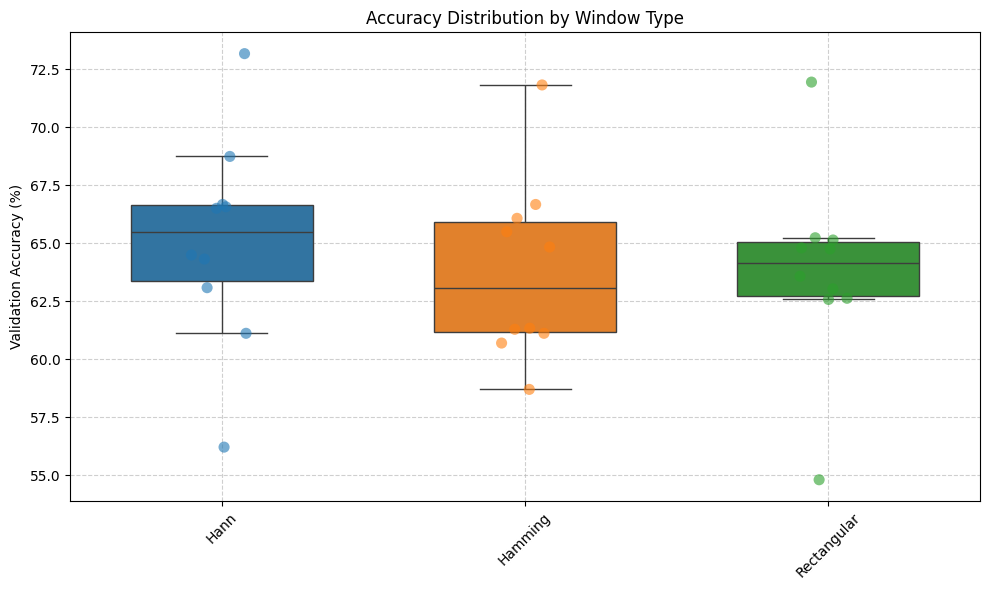

In [44]:
# Compare results
final_stats = compare_window_results(window_results)
final_stats.to_csv('window_comparison_results.csv')

-----